In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

/Users/1233day/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import logging

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [4]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [5]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [6]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [7]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [8]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [9]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [10]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [11]:
# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
    bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
    labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
    train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
    test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=100)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=100)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [12]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [13]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [14]:
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )

KeyError: "['임신 시도 또는 마지막 임신 경과 연수'] not found in axis"

In [15]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
       '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부',
       '임신시도_bin', '총_생성_배아_bin', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [16]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', '총_생성_배아_bin','PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인',"임신시도_bin"] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [17]:
len(categorical_columns) + len(numeric_columns)

59

In [18]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [19]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 67), (90067, 67))

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 수치형 변수(정수, 실수)를 선택하여 스케일링
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

X.shape, test.shape

((256351, 67), (90067, 67))

In [21]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [22]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [23]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [24]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 40)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_cpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="cpu" )
    # model_cpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_cpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-25 15:10:25,527] A new study created in memory with name: no-name-946eb145-d076-4f03-b83d-368d597aeca9


Seed 4972 Start!
0:	test: 0.7161758	best: 0.7161758 (0)	total: 168ms	remaining: 6m 37s
300:	test: 0.7387540	best: 0.7387540 (300)	total: 37.2s	remaining: 4m 15s
600:	test: 0.7400686	best: 0.7400728 (589)	total: 1m 16s	remaining: 3m 43s
900:	test: 0.7406008	best: 0.7406119 (892)	total: 1m 55s	remaining: 3m 7s
1200:	test: 0.7407464	best: 0.7407542 (1190)	total: 2m 39s	remaining: 2m 34s
1500:	test: 0.7408787	best: 0.7408936 (1467)	total: 3m 29s	remaining: 2m
1800:	test: 0.7409551	best: 0.7410085 (1708)	total: 4m 17s	remaining: 1m 20s


[I 2025-02-25 15:15:17,651] Trial 0 finished with value: 0.7410084705745688 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410084706
bestIteration = 1708

Shrink model to first 1709 iterations.
저장 완료
0:	test: 0.6946616	best: 0.6946616 (0)	total: 54.3ms	remaining: 1m 58s


Training has stopped (degenerate solution on iteration 232, probably too small l2-regularization, try to increase it)
[I 2025-02-25 15:15:27,704] Trial 1 finished with value: 0.7282318075732872 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7410084705745688.



bestTest = 0.7282318076
bestIteration = 231

Shrink model to first 232 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 49.2ms	remaining: 2m 4s
300:	test: 0.7408920	best: 0.7408920 (300)	total: 14.4s	remaining: 1m 46s
600:	test: 0.7400776	best: 0.7409930 (315)	total: 29.4s	remaining: 1m 34s


[I 2025-02-25 15:15:58,019] Trial 2 finished with value: 0.7409929968448441 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409929968
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 51.2ms	remaining: 1m 59s
300:	test: 0.7391779	best: 0.7391779 (300)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7402539	best: 0.7402637 (597)	total: 28.5s	remaining: 1m 22s
900:	test: 0.7402192	best: 0.7404415 (803)	total: 43.4s	remaining: 1m 9s


[I 2025-02-25 15:16:51,686] Trial 3 finished with value: 0.7404415412298581 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404415412
bestIteration = 803

Shrink model to first 804 iterations.
0:	test: 0.7228048	best: 0.7228048 (0)	total: 105ms	remaining: 3m 3s
300:	test: 0.7381428	best: 0.7381428 (300)	total: 37.1s	remaining: 2m 57s
600:	test: 0.7389412	best: 0.7389631 (597)	total: 1m 16s	remaining: 2m 24s
900:	test: 0.7388022	best: 0.7390259 (786)	total: 1m 54s	remaining: 1m 46s


[I 2025-02-25 15:19:13,207] Trial 4 finished with value: 0.7390258795965623 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390258796
bestIteration = 786

Shrink model to first 787 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 47.9ms	remaining: 1m 39s
300:	test: 0.7404055	best: 0.7404070 (299)	total: 14s	remaining: 1m 22s
600:	test: 0.7406651	best: 0.7408965 (394)	total: 29s	remaining: 1m 11s


[I 2025-02-25 15:19:47,051] Trial 5 finished with value: 0.7408965371794098 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408965372
bestIteration = 394

Shrink model to first 395 iterations.
0:	test: 0.6962144	best: 0.6962144 (0)	total: 53.4ms	remaining: 1m 46s
300:	test: 0.7405063	best: 0.7405161 (298)	total: 17.2s	remaining: 1m 37s
600:	test: 0.7412080	best: 0.7412148 (592)	total: 35.1s	remaining: 1m 21s


[I 2025-02-25 15:20:40,300] Trial 6 finished with value: 0.7412148425603788 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412148426
bestIteration = 592

Shrink model to first 593 iterations.
저장 완료
0:	test: 0.7126516	best: 0.7126516 (0)	total: 68.3ms	remaining: 2m 11s
300:	test: 0.7402127	best: 0.7406367 (155)	total: 24.5s	remaining: 2m 12s


[I 2025-02-25 15:21:18,225] Trial 7 finished with value: 0.7406367000227655 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406367
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.7126608	best: 0.7126608 (0)	total: 68.7ms	remaining: 2m 10s
300:	test: 0.7406911	best: 0.7406963 (299)	total: 23.2s	remaining: 2m 3s
600:	test: 0.7405032	best: 0.7408918 (452)	total: 48.5s	remaining: 1m 45s


[I 2025-02-25 15:22:19,926] Trial 8 finished with value: 0.7408918398680769 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408918399
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7096826	best: 0.7096826 (0)	total: 62.8ms	remaining: 2m 45s
300:	test: 0.7401592	best: 0.7401601 (299)	total: 19.9s	remaining: 2m 34s
600:	test: 0.7410061	best: 0.7411606 (470)	total: 41.3s	remaining: 2m 19s


[I 2025-02-25 15:23:13,893] Trial 9 finished with value: 0.7411605554593284 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411605555
bestIteration = 470

Shrink model to first 471 iterations.
0:	test: 0.7096801	best: 0.7096801 (0)	total: 61.2ms	remaining: 3m
300:	test: 0.7409185	best: 0.7409185 (300)	total: 20.2s	remaining: 2m 57s
600:	test: 0.7414339	best: 0.7415364 (498)	total: 41.1s	remaining: 2m 40s


[I 2025-02-25 15:24:09,165] Trial 10 finished with value: 0.7415363840434073 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7415363840434073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741536384
bestIteration = 498

Shrink model to first 499 iterations.
저장 완료
0:	test: 0.7097053	best: 0.7097053 (0)	total: 61.5ms	remaining: 3m 4s
300:	test: 0.7405844	best: 0.7406033 (290)	total: 20.2s	remaining: 3m
600:	test: 0.7411199	best: 0.7411331 (593)	total: 41.2s	remaining: 2m 44s
900:	test: 0.7412395	best: 0.7413265 (821)	total: 1m 2s	remaining: 2m 25s


[I 2025-02-25 15:25:28,076] Trial 11 finished with value: 0.7413264662427026 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7415363840434073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413264662
bestIteration = 821

Shrink model to first 822 iterations.
0:	test: 0.7097047	best: 0.7097047 (0)	total: 64.8ms	remaining: 3m 7s
300:	test: 0.7411432	best: 0.7411452 (297)	total: 19.8s	remaining: 2m 50s
600:	test: 0.7417803	best: 0.7418075 (572)	total: 40.9s	remaining: 2m 36s
900:	test: 0.7418311	best: 0.7418644 (704)	total: 1m 2s	remaining: 2m 17s
1200:	test: 0.7419140	best: 0.7419473 (1169)	total: 1m 23s	remaining: 1m 58s


[I 2025-02-25 15:27:11,870] Trial 12 finished with value: 0.7419473292981775 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419473293
bestIteration = 1169

Shrink model to first 1170 iterations.
저장 완료
0:	test: 0.7126708	best: 0.7126708 (0)	total: 79.2ms	remaining: 3m 55s
300:	test: 0.7405791	best: 0.7405791 (300)	total: 26.9s	remaining: 3m 58s
600:	test: 0.7405330	best: 0.7408797 (443)	total: 55.8s	remaining: 3m 40s


[I 2025-02-25 15:28:21,868] Trial 13 finished with value: 0.7408796816539593 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.0628933885949758, 'l2_leaf_reg': 7.828901342687942}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408796817
bestIteration = 443

Shrink model to first 444 iterations.
0:	test: 0.7181905	best: 0.7181905 (0)	total: 76.6ms	remaining: 3m 31s
300:	test: 0.7396999	best: 0.7396999 (300)	total: 25.2s	remaining: 3m 25s
600:	test: 0.7402756	best: 0.7404333 (518)	total: 53.2s	remaining: 3m 10s


[I 2025-02-25 15:29:36,528] Trial 14 finished with value: 0.7404332901622759 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.030866060002221384, 'l2_leaf_reg': 0.02939703823210393}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404332902
bestIteration = 518

Shrink model to first 519 iterations.
0:	test: 0.7097050	best: 0.7097050 (0)	total: 60.7ms	remaining: 1m 31s
300:	test: 0.7407421	best: 0.7407514 (296)	total: 20.9s	remaining: 1m 24s
600:	test: 0.7406826	best: 0.7408506 (437)	total: 42.4s	remaining: 1m 4s


[I 2025-02-25 15:30:29,173] Trial 15 finished with value: 0.7408506043835532 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.08625378621185843, 'l2_leaf_reg': 9.663069382488304}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408506044
bestIteration = 437

Shrink model to first 438 iterations.
0:	test: 0.7181964	best: 0.7181964 (0)	total: 79.4ms	remaining: 3m 44s
300:	test: 0.7408305	best: 0.7408389 (297)	total: 27s	remaining: 3m 46s
600:	test: 0.7403778	best: 0.7408479 (318)	total: 56.7s	remaining: 3m 29s


[I 2025-02-25 15:31:27,809] Trial 16 finished with value: 0.7408478527041333 and parameters: {'iterations': 2824, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 1.8341589839267998}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408478527
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.6962144	best: 0.6962144 (0)	total: 53ms	remaining: 2m 14s
300:	test: 0.7405460	best: 0.7405460 (300)	total: 17.5s	remaining: 2m 10s
600:	test: 0.7411116	best: 0.7411116 (600)	total: 35.5s	remaining: 1m 54s
900:	test: 0.7412044	best: 0.7412244 (881)	total: 53.7s	remaining: 1m 38s
1200:	test: 0.7412922	best: 0.7413022 (1184)	total: 1m 12s	remaining: 1m 20s
1500:	test: 0.7412923	best: 0.7413411 (1346)	total: 1m 30s	remaining: 1m 3s


[I 2025-02-25 15:33:07,895] Trial 17 finished with value: 0.7413410545113728 and parameters: {'iterations': 2546, 'depth': 5, 'learning_rate': 0.0774911016692127, 'l2_leaf_reg': 80.62911323694684}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413410545
bestIteration = 1346

Shrink model to first 1347 iterations.
0:	test: 0.7126516	best: 0.7126516 (0)	total: 68.3ms	remaining: 3m 12s
300:	test: 0.7403266	best: 0.7404758 (280)	total: 23.6s	remaining: 3m 16s


[I 2025-02-25 15:33:55,258] Trial 18 finished with value: 0.7404758399410103 and parameters: {'iterations': 2815, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404758399
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.6962156	best: 0.6962156 (0)	total: 56ms	remaining: 2m 17s
300:	test: 0.7390692	best: 0.7390715 (298)	total: 16.7s	remaining: 1m 59s
600:	test: 0.7407096	best: 0.7407156 (599)	total: 34.7s	remaining: 1m 47s
900:	test: 0.7410902	best: 0.7411116 (878)	total: 53.1s	remaining: 1m 31s
1200:	test: 0.7409903	best: 0.7411384 (1030)	total: 1m 11s	remaining: 1m 15s


[I 2025-02-25 15:35:15,122] Trial 19 finished with value: 0.7411383633434879 and parameters: {'iterations': 2460, 'depth': 5, 'learning_rate': 0.032760769261710856, 'l2_leaf_reg': 0.31055845032241847}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411383633
bestIteration = 1030

Shrink model to first 1031 iterations.
0:	test: 0.7097050	best: 0.7097050 (0)	total: 61.9ms	remaining: 2m 48s
300:	test: 0.7408404	best: 0.7408575 (295)	total: 20.5s	remaining: 2m 45s
600:	test: 0.7408149	best: 0.7409364 (355)	total: 42.4s	remaining: 2m 29s


[I 2025-02-25 15:36:01,731] Trial 20 finished with value: 0.7409364385163361 and parameters: {'iterations': 2723, 'depth': 6, 'learning_rate': 0.08459797786417986, 'l2_leaf_reg': 20.419787539717326}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409364385
bestIteration = 355

Shrink model to first 356 iterations.
0:	test: 0.6962144	best: 0.6962144 (0)	total: 54.3ms	remaining: 2m 20s
300:	test: 0.7406370	best: 0.7406392 (299)	total: 18.1s	remaining: 2m 18s
600:	test: 0.7410517	best: 0.7410517 (600)	total: 36s	remaining: 1m 59s
900:	test: 0.7412321	best: 0.7412321 (900)	total: 54.2s	remaining: 1m 41s
1200:	test: 0.7412549	best: 0.7412927 (1078)	total: 1m 12s	remaining: 1m 24s
1500:	test: 0.7411726	best: 0.7413012 (1316)	total: 1m 31s	remaining: 1m 6s


[I 2025-02-25 15:37:40,415] Trial 21 finished with value: 0.741301188910543 and parameters: {'iterations': 2596, 'depth': 5, 'learning_rate': 0.07744540398025425, 'l2_leaf_reg': 89.64660875312273}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413011889
bestIteration = 1316

Shrink model to first 1317 iterations.
0:	test: 0.6962153	best: 0.6962153 (0)	total: 55.7ms	remaining: 2m 41s
300:	test: 0.7406852	best: 0.7406894 (296)	total: 17.6s	remaining: 2m 31s
600:	test: 0.7407936	best: 0.7409956 (482)	total: 35.9s	remaining: 2m 17s


[I 2025-02-25 15:38:27,808] Trial 22 finished with value: 0.7409956413159748 and parameters: {'iterations': 2901, 'depth': 5, 'learning_rate': 0.07182943923727259, 'l2_leaf_reg': 2.2815014894024164}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409956413
bestIteration = 482

Shrink model to first 483 iterations.
0:	test: 0.7097050	best: 0.7097050 (0)	total: 61.8ms	remaining: 2m 45s
300:	test: 0.7407147	best: 0.7408213 (270)	total: 20.8s	remaining: 2m 44s


[I 2025-02-25 15:39:08,427] Trial 23 finished with value: 0.7408212650484405 and parameters: {'iterations': 2684, 'depth': 6, 'learning_rate': 0.09983741797136365, 'l2_leaf_reg': 24.246184155884688}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740821265
bestIteration = 270

Shrink model to first 271 iterations.
0:	test: 0.7126267	best: 0.7126267 (0)	total: 69.4ms	remaining: 3m 18s
300:	test: 0.7407499	best: 0.7407603 (296)	total: 23.3s	remaining: 3m 17s
600:	test: 0.7411031	best: 0.7411125 (559)	total: 48.3s	remaining: 3m 1s
900:	test: 0.7413171	best: 0.7413594 (892)	total: 1m 13s	remaining: 2m 40s


[I 2025-02-25 15:40:47,094] Trial 24 finished with value: 0.7413593712460969 and parameters: {'iterations': 2861, 'depth': 7, 'learning_rate': 0.0634339002537276, 'l2_leaf_reg': 36.88308849820684}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413593712
bestIteration = 892

Shrink model to first 893 iterations.
0:	test: 0.7126294	best: 0.7126294 (0)	total: 76.6ms	remaining: 3m 42s
300:	test: 0.7408396	best: 0.7408396 (300)	total: 25.2s	remaining: 3m 37s
600:	test: 0.7413352	best: 0.7414315 (544)	total: 54.2s	remaining: 3m 27s


[I 2025-02-25 15:42:05,387] Trial 25 finished with value: 0.7414314668351674 and parameters: {'iterations': 2903, 'depth': 8, 'learning_rate': 0.05439067859873772, 'l2_leaf_reg': 24.803606523449552}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414314668
bestIteration = 544

Shrink model to first 545 iterations.
0:	test: 0.7182085	best: 0.7182085 (0)	total: 81.1ms	remaining: 4m 2s
300:	test: 0.7409072	best: 0.7409126 (291)	total: 26.7s	remaining: 3m 58s
600:	test: 0.7409495	best: 0.7412784 (505)	total: 56.2s	remaining: 3m 43s


[I 2025-02-25 15:43:22,135] Trial 26 finished with value: 0.741278448841225 and parameters: {'iterations': 2991, 'depth': 8, 'learning_rate': 0.05361821486127472, 'l2_leaf_reg': 4.342397790956773}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412784488
bestIteration = 505

Shrink model to first 506 iterations.
0:	test: 0.7179652	best: 0.7179652 (0)	total: 88.1ms	remaining: 4m 13s
300:	test: 0.7399095	best: 0.7399423 (255)	total: 30.4s	remaining: 4m 20s
600:	test: 0.7392041	best: 0.7400509 (348)	total: 1m 4s	remaining: 4m 4s


[I 2025-02-25 15:44:32,243] Trial 27 finished with value: 0.7400509298139176 and parameters: {'iterations': 2884, 'depth': 9, 'learning_rate': 0.044604437558391635, 'l2_leaf_reg': 0.45255823702076187}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400509298
bestIteration = 348

Shrink model to first 349 iterations.
0:	test: 0.7124200	best: 0.7124200 (0)	total: 89ms	remaining: 4m 5s
300:	test: 0.7409200	best: 0.7409231 (279)	total: 30.5s	remaining: 4m 8s
600:	test: 0.7409041	best: 0.7410345 (359)	total: 1m 4s	remaining: 3m 49s


[I 2025-02-25 15:45:43,019] Trial 28 finished with value: 0.7410344705700104 and parameters: {'iterations': 2758, 'depth': 9, 'learning_rate': 0.054998305185314914, 'l2_leaf_reg': 20.474793951514382}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410344706
bestIteration = 359

Shrink model to first 360 iterations.
0:	test: 0.7179852	best: 0.7179852 (0)	total: 90.4ms	remaining: 3m 36s
300:	test: 0.7399097	best: 0.7399097 (300)	total: 29.8s	remaining: 3m 27s
600:	test: 0.7405723	best: 0.7406129 (579)	total: 1m	remaining: 2m 59s
900:	test: 0.7409121	best: 0.7409339 (862)	total: 1m 34s	remaining: 2m 36s
1200:	test: 0.7407890	best: 0.7409907 (1069)	total: 2m 8s	remaining: 2m 7s


[I 2025-02-25 15:48:11,212] Trial 29 finished with value: 0.7409906938519675 and parameters: {'iterations': 2392, 'depth': 9, 'learning_rate': 0.023174536645179013, 'l2_leaf_reg': 4.438928364247818}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409906939
bestIteration = 1069

Shrink model to first 1070 iterations.
0:	test: 0.7126685	best: 0.7126685 (0)	total: 72.4ms	remaining: 2m 45s
300:	test: 0.7410246	best: 0.7410461 (292)	total: 23.9s	remaining: 2m 37s
600:	test: 0.7412868	best: 0.7413864 (594)	total: 49.5s	remaining: 2m 19s


[I 2025-02-25 15:49:26,153] Trial 30 finished with value: 0.7413863519988497 and parameters: {'iterations': 2291, 'depth': 7, 'learning_rate': 0.06845494143715, 'l2_leaf_reg': 13.45496577396606}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741386352
bestIteration = 594

Shrink model to first 595 iterations.
0:	test: 0.7126294	best: 0.7126294 (0)	total: 74.2ms	remaining: 2m 48s
300:	test: 0.7412379	best: 0.7412379 (300)	total: 23.4s	remaining: 2m 33s
600:	test: 0.7416348	best: 0.7416916 (540)	total: 48.6s	remaining: 2m 14s


[I 2025-02-25 15:50:35,771] Trial 31 finished with value: 0.7416915541444862 and parameters: {'iterations': 2268, 'depth': 7, 'learning_rate': 0.06792247328915654, 'l2_leaf_reg': 24.36196292994454}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416915541
bestIteration = 540

Shrink model to first 541 iterations.
0:	test: 0.7097053	best: 0.7097053 (0)	total: 62.5ms	remaining: 2m 15s
300:	test: 0.7409886	best: 0.7409976 (298)	total: 21.3s	remaining: 2m 12s
600:	test: 0.7416441	best: 0.7416682 (583)	total: 43.6s	remaining: 1m 53s
900:	test: 0.7417734	best: 0.7417832 (896)	total: 1m 5s	remaining: 1m 32s


[I 2025-02-25 15:52:03,526] Trial 32 finished with value: 0.7417832013489439 and parameters: {'iterations': 2171, 'depth': 6, 'learning_rate': 0.06664214223634575, 'l2_leaf_reg': 31.781786477153968}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417832013
bestIteration = 896

Shrink model to first 897 iterations.
0:	test: 0.7097053	best: 0.7097053 (0)	total: 64.2ms	remaining: 2m 19s
300:	test: 0.7412324	best: 0.7412324 (300)	total: 22.1s	remaining: 2m 17s
600:	test: 0.7415967	best: 0.7415995 (595)	total: 43.7s	remaining: 1m 54s
900:	test: 0.7415394	best: 0.7416687 (847)	total: 1m 6s	remaining: 1m 33s
1200:	test: 0.7416842	best: 0.7417499 (1158)	total: 1m 28s	remaining: 1m 11s


[I 2025-02-25 15:53:51,639] Trial 33 finished with value: 0.7417499389845861 and parameters: {'iterations': 2172, 'depth': 6, 'learning_rate': 0.08276021446119664, 'l2_leaf_reg': 41.20006472619695}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741749939
bestIteration = 1158

Shrink model to first 1159 iterations.
0:	test: 0.7097034	best: 0.7097034 (0)	total: 66ms	remaining: 2m 24s
300:	test: 0.7407758	best: 0.7407996 (268)	total: 21.3s	remaining: 2m 14s
600:	test: 0.7406367	best: 0.7410676 (404)	total: 43.4s	remaining: 1m 54s


[I 2025-02-25 15:54:42,962] Trial 34 finished with value: 0.7410675661659185 and parameters: {'iterations': 2192, 'depth': 6, 'learning_rate': 0.08099395505829877, 'l2_leaf_reg': 5.355032994485218}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410675662
bestIteration = 404

Shrink model to first 405 iterations.
0:	test: 0.7126320	best: 0.7126320 (0)	total: 74.2ms	remaining: 2m 39s
300:	test: 0.7412218	best: 0.7413200 (279)	total: 24.2s	remaining: 2m 28s


[I 2025-02-25 15:55:31,064] Trial 35 finished with value: 0.7413199821265517 and parameters: {'iterations': 2145, 'depth': 7, 'learning_rate': 0.08971532944062331, 'l2_leaf_reg': 41.09509812202617}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413199821
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7096947	best: 0.7096947 (0)	total: 62.5ms	remaining: 1m 52s
300:	test: 0.7406804	best: 0.7406804 (300)	total: 21.1s	remaining: 1m 44s
600:	test: 0.7405744	best: 0.7408030 (403)	total: 43.3s	remaining: 1m 26s


[I 2025-02-25 15:56:22,243] Trial 36 finished with value: 0.7408029800791354 and parameters: {'iterations': 1798, 'depth': 6, 'learning_rate': 0.06669985198732055, 'l2_leaf_reg': 1.1449658944976202}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408029801
bestIteration = 403

Shrink model to first 404 iterations.
0:	test: 0.6962147	best: 0.6962147 (0)	total: 55.5ms	remaining: 2m 5s
300:	test: 0.7408395	best: 0.7408395 (300)	total: 17.9s	remaining: 1m 56s
600:	test: 0.7410690	best: 0.7411694 (452)	total: 36.5s	remaining: 1m 40s


[I 2025-02-25 15:57:08,467] Trial 37 finished with value: 0.7411693663924201 and parameters: {'iterations': 2253, 'depth': 5, 'learning_rate': 0.07417884959553789, 'l2_leaf_reg': 12.447848838228719}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411693664
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7126322	best: 0.7126322 (0)	total: 69.6ms	remaining: 2m 46s
300:	test: 0.7409875	best: 0.7410542 (259)	total: 24.1s	remaining: 2m 47s
600:	test: 0.7413183	best: 0.7414059 (571)	total: 51.7s	remaining: 2m 34s
900:	test: 0.7412959	best: 0.7414953 (694)	total: 1m 17s	remaining: 2m 8s


[I 2025-02-25 15:58:34,706] Trial 38 finished with value: 0.7414953034153011 and parameters: {'iterations': 2395, 'depth': 7, 'learning_rate': 0.08268523317959117, 'l2_leaf_reg': 37.621055271832695}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414953034
bestIteration = 694

Shrink model to first 695 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 58.9ms	remaining: 2m
300:	test: 0.7400013	best: 0.7400013 (300)	total: 14.4s	remaining: 1m 23s
600:	test: 0.7407767	best: 0.7408100 (583)	total: 29.2s	remaining: 1m 10s
900:	test: 0.7408857	best: 0.7409472 (832)	total: 44.3s	remaining: 56.1s


[I 2025-02-25 15:59:30,927] Trial 39 finished with value: 0.7409471911106635 and parameters: {'iterations': 2043, 'depth': 4, 'learning_rate': 0.058334609809085614, 'l2_leaf_reg': 3.3852956662506277}. Best is trial 12 with value: 0.7419473292981775.
[I 2025-02-25 15:59:30,930] A new study created in memory with name: no-name-d36bd2b4-a441-4587-92cd-a00cfae7a5b0


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409471911
bestIteration = 832

Shrink model to first 833 iterations.


[I 2025-02-25 15:59:54,011] Trial 0 finished with value: 0.7312648213970655 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7312648213970655.
[I 2025-02-25 16:00:10,846] Trial 1 finished with value: 0.740679198182694 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.740679198182694.
[I 2025-02-25 16:00:30,452] Trial 2 finished with value: 0.7407712424548891 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7419473292981775
LGBM val score : 0.7409660081507365
Ensemble val score : 0.7420357721659947


[I 2025-02-25 16:12:36,010] A new study created in memory with name: no-name-f45ca1a4-4ec4-48f6-85b1-6ad1fb00fddb


0:	test: 0.7227589	best: 0.7227589 (0)	total: 151ms	remaining: 5m 57s
300:	test: 0.7330597	best: 0.7330597 (300)	total: 41.5s	remaining: 4m 44s
600:	test: 0.7344199	best: 0.7344225 (596)	total: 1m 22s	remaining: 4m 3s
900:	test: 0.7348073	best: 0.7348178 (897)	total: 2m 4s	remaining: 3m 23s
1200:	test: 0.7350766	best: 0.7350805 (1198)	total: 2m 51s	remaining: 2m 46s
1500:	test: 0.7351321	best: 0.7351767 (1430)	total: 3m 42s	remaining: 2m 8s


[I 2025-02-25 16:16:58,459] Trial 0 finished with value: 0.7351766526465233 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351766526
bestIteration = 1430

Shrink model to first 1431 iterations.
저장 완료
0:	test: 0.6888096	best: 0.6888096 (0)	total: 63.6ms	remaining: 2m 19s
300:	test: 0.7236600	best: 0.7236600 (300)	total: 14.6s	remaining: 1m 31s


Training has stopped (degenerate solution on iteration 346, probably too small l2-regularization, try to increase it)
[I 2025-02-25 16:17:15,297] Trial 1 finished with value: 0.7247429245465473 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7351766526465233.



bestTest = 0.7247429245
bestIteration = 345

Shrink model to first 346 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 57.9ms	remaining: 2m 26s
300:	test: 0.7343409	best: 0.7343409 (300)	total: 14.8s	remaining: 1m 49s
600:	test: 0.7340241	best: 0.7344169 (352)	total: 30.3s	remaining: 1m 37s


[I 2025-02-25 16:17:48,423] Trial 2 finished with value: 0.7344168798461395 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344168798
bestIteration = 352

Shrink model to first 353 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 54.5ms	remaining: 2m 7s
300:	test: 0.7337850	best: 0.7337850 (300)	total: 14.3s	remaining: 1m 36s
600:	test: 0.7344127	best: 0.7346932 (516)	total: 29.5s	remaining: 1m 25s


[I 2025-02-25 16:18:29,004] Trial 3 finished with value: 0.7346932330694971 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346932331
bestIteration = 516

Shrink model to first 517 iterations.
0:	test: 0.7227306	best: 0.7227306 (0)	total: 138ms	remaining: 4m 1s
300:	test: 0.7326636	best: 0.7326759 (298)	total: 38.4s	remaining: 3m 4s
600:	test: 0.7334423	best: 0.7334554 (590)	total: 1m 21s	remaining: 2m 34s


[I 2025-02-25 16:20:34,052] Trial 4 finished with value: 0.7334553622032569 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7334553622
bestIteration = 590

Shrink model to first 591 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 65.3ms	remaining: 2m 15s
300:	test: 0.7344814	best: 0.7344814 (300)	total: 15.9s	remaining: 1m 34s
600:	test: 0.7345071	best: 0.7346733 (566)	total: 32.6s	remaining: 1m 20s
900:	test: 0.7345130	best: 0.7346927 (821)	total: 48s	remaining: 1m 2s


[I 2025-02-25 16:21:33,701] Trial 5 finished with value: 0.734692748573704 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346927486
bestIteration = 821

Shrink model to first 822 iterations.
0:	test: 0.6975347	best: 0.6975347 (0)	total: 72.2ms	remaining: 2m 24s
300:	test: 0.7349218	best: 0.7349218 (298)	total: 18.7s	remaining: 1m 45s
600:	test: 0.7350271	best: 0.7351283 (475)	total: 38s	remaining: 1m 28s
900:	test: 0.7351566	best: 0.7351754 (747)	total: 56.2s	remaining: 1m 8s


[I 2025-02-25 16:22:39,108] Trial 6 finished with value: 0.7351754175793787 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351754176
bestIteration = 747

Shrink model to first 748 iterations.
0:	test: 0.7121280	best: 0.7121280 (0)	total: 85.2ms	remaining: 2m 44s
300:	test: 0.7342498	best: 0.7347529 (166)	total: 26.2s	remaining: 2m 21s


[I 2025-02-25 16:23:20,728] Trial 7 finished with value: 0.7347529015063101 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347529015
bestIteration = 166

Shrink model to first 167 iterations.
0:	test: 0.7121274	best: 0.7121274 (0)	total: 87.5ms	remaining: 2m 46s
300:	test: 0.7352481	best: 0.7353171 (297)	total: 25.5s	remaining: 2m 15s
600:	test: 0.7351487	best: 0.7354021 (413)	total: 51.7s	remaining: 1m 52s


[I 2025-02-25 16:24:22,472] Trial 8 finished with value: 0.7354020662998975 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354020663
bestIteration = 413

Shrink model to first 414 iterations.
저장 완료
0:	test: 0.7118659	best: 0.7118659 (0)	total: 77ms	remaining: 3m 23s
300:	test: 0.7343442	best: 0.7343819 (297)	total: 20.8s	remaining: 2m 41s
600:	test: 0.7349371	best: 0.7350599 (487)	total: 43.2s	remaining: 2m 26s


[I 2025-02-25 16:25:19,912] Trial 9 finished with value: 0.7350599487295433 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350599487
bestIteration = 487

Shrink model to first 488 iterations.
0:	test: 0.7154641	best: 0.7154641 (0)	total: 96.8ms	remaining: 4m 44s
300:	test: 0.7343450	best: 0.7343450 (300)	total: 26.7s	remaining: 3m 54s
600:	test: 0.7351176	best: 0.7352153 (505)	total: 56.3s	remaining: 3m 39s


[I 2025-02-25 16:26:37,080] Trial 10 finished with value: 0.7352152812578299 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352152813
bestIteration = 505

Shrink model to first 506 iterations.
0:	test: 0.7154648	best: 0.7154648 (0)	total: 97.1ms	remaining: 4m 50s
300:	test: 0.7345951	best: 0.7345980 (298)	total: 27s	remaining: 4m 1s
600:	test: 0.7353313	best: 0.7353494 (593)	total: 56.2s	remaining: 3m 43s
900:	test: 0.7349323	best: 0.7353888 (629)	total: 1m 26s	remaining: 3m 20s


[I 2025-02-25 16:28:06,490] Trial 11 finished with value: 0.7353887506081416 and parameters: {'iterations': 2994, 'depth': 8, 'learning_rate': 0.031221552622542375, 'l2_leaf_reg': 0.4673950385408126}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353887506
bestIteration = 629

Shrink model to first 630 iterations.
0:	test: 0.7154648	best: 0.7154648 (0)	total: 95.7ms	remaining: 2m 29s
300:	test: 0.7337962	best: 0.7344370 (216)	total: 27.4s	remaining: 1m 55s


[I 2025-02-25 16:28:55,750] Trial 12 finished with value: 0.7344369903928296 and parameters: {'iterations': 1565, 'depth': 8, 'learning_rate': 0.061287874640168535, 'l2_leaf_reg': 0.028450890806958902}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344369904
bestIteration = 216

Shrink model to first 217 iterations.
0:	test: 0.7154746	best: 0.7154746 (0)	total: 96.5ms	remaining: 4m 46s
300:	test: 0.7343632	best: 0.7343650 (299)	total: 25.9s	remaining: 3m 50s
600:	test: 0.7350954	best: 0.7350954 (600)	total: 53.4s	remaining: 3m 30s
900:	test: 0.7348994	best: 0.7351569 (676)	total: 1m 22s	remaining: 3m 10s


[I 2025-02-25 16:30:26,058] Trial 13 finished with value: 0.7351569273137013 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.026319078501895434, 'l2_leaf_reg': 2.079573379652083}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351569273
bestIteration = 676

Shrink model to first 677 iterations.
0:	test: 0.7121233	best: 0.7121233 (0)	total: 80.1ms	remaining: 3m 36s
300:	test: 0.7352129	best: 0.7352129 (300)	total: 23.8s	remaining: 3m 9s
600:	test: 0.7352602	best: 0.7354736 (441)	total: 49.1s	remaining: 2m 51s


[I 2025-02-25 16:31:27,273] Trial 14 finished with value: 0.7354736207687493 and parameters: {'iterations': 2702, 'depth': 7, 'learning_rate': 0.0536289472022267, 'l2_leaf_reg': 5.542114755250782}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354736208
bestIteration = 441

Shrink model to first 442 iterations.
저장 완료
0:	test: 0.7118659	best: 0.7118659 (0)	total: 75.1ms	remaining: 3m 21s
300:	test: 0.7348053	best: 0.7348190 (296)	total: 20.3s	remaining: 2m 40s
600:	test: 0.7351223	best: 0.7351451 (586)	total: 41.8s	remaining: 2m 24s
900:	test: 0.7350383	best: 0.7352107 (725)	total: 1m 3s	remaining: 2m 5s


[I 2025-02-25 16:32:39,918] Trial 15 finished with value: 0.7352107420882275 and parameters: {'iterations': 2684, 'depth': 6, 'learning_rate': 0.05665316438649348, 'l2_leaf_reg': 16.81902590307642}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352107421
bestIteration = 725

Shrink model to first 726 iterations.
0:	test: 0.7121241	best: 0.7121241 (0)	total: 84.1ms	remaining: 2m 30s
300:	test: 0.7350853	best: 0.7351682 (250)	total: 24.2s	remaining: 2m
600:	test: 0.7349781	best: 0.7352024 (320)	total: 49.9s	remaining: 1m 38s


[I 2025-02-25 16:33:31,638] Trial 16 finished with value: 0.7352023587224961 and parameters: {'iterations': 1793, 'depth': 7, 'learning_rate': 0.07180185194389979, 'l2_leaf_reg': 3.055459031171782}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352023587
bestIteration = 320

Shrink model to first 321 iterations.
0:	test: 0.7200459	best: 0.7200459 (0)	total: 109ms	remaining: 2m 56s
300:	test: 0.7338165	best: 0.7338989 (276)	total: 30.6s	remaining: 2m 13s


[I 2025-02-25 16:34:33,919] Trial 17 finished with value: 0.7338989181018318 and parameters: {'iterations': 1618, 'depth': 9, 'learning_rate': 0.05122368438861319, 'l2_leaf_reg': 0.016368401574579163}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7338989181
bestIteration = 276

Shrink model to first 277 iterations.
0:	test: 0.7118585	best: 0.7118585 (0)	total: 74.2ms	remaining: 3m 28s
300:	test: 0.7344773	best: 0.7345113 (296)	total: 20.9s	remaining: 2m 53s
600:	test: 0.7349343	best: 0.7349535 (544)	total: 42.3s	remaining: 2m 35s
900:	test: 0.7349823	best: 0.7350306 (810)	total: 1m 3s	remaining: 2m 14s


[I 2025-02-25 16:35:52,860] Trial 18 finished with value: 0.7350306208489532 and parameters: {'iterations': 2806, 'depth': 6, 'learning_rate': 0.06566065400200083, 'l2_leaf_reg': 70.64174190249958}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350306208
bestIteration = 810

Shrink model to first 811 iterations.
0:	test: 0.7121280	best: 0.7121280 (0)	total: 82ms	remaining: 3m 21s
300:	test: 0.7345898	best: 0.7347519 (241)	total: 25.3s	remaining: 3m 1s


[I 2025-02-25 16:36:39,037] Trial 19 finished with value: 0.7347518769168461 and parameters: {'iterations': 2455, 'depth': 7, 'learning_rate': 0.08088060835396044, 'l2_leaf_reg': 0.15888451859639016}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347518769
bestIteration = 241

Shrink model to first 242 iterations.
0:	test: 0.7200655	best: 0.7200655 (0)	total: 110ms	remaining: 4m 2s
300:	test: 0.7349505	best: 0.7349509 (298)	total: 29.7s	remaining: 3m 8s
600:	test: 0.7351704	best: 0.7353849 (518)	total: 1m 2s	remaining: 2m 48s


[I 2025-02-25 16:38:06,453] Trial 20 finished with value: 0.7353848627279658 and parameters: {'iterations': 2212, 'depth': 9, 'learning_rate': 0.04279597597675146, 'l2_leaf_reg': 10.195742626338639}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353848627
bestIteration = 518

Shrink model to first 519 iterations.
0:	test: 0.7154645	best: 0.7154645 (0)	total: 94ms	remaining: 4m 25s
300:	test: 0.7343555	best: 0.7343555 (300)	total: 26.1s	remaining: 3m 38s
600:	test: 0.7350963	best: 0.7351444 (565)	total: 54s	remaining: 3m 19s
900:	test: 0.7348822	best: 0.7351662 (676)	total: 1m 23s	remaining: 2m 58s


[I 2025-02-25 16:39:37,496] Trial 21 finished with value: 0.735166184360371 and parameters: {'iterations': 2826, 'depth': 8, 'learning_rate': 0.026821593185006206, 'l2_leaf_reg': 0.6301851649810912}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351661844
bestIteration = 676

Shrink model to first 677 iterations.
0:	test: 0.7200537	best: 0.7200537 (0)	total: 109ms	remaining: 5m 4s
300:	test: 0.7350967	best: 0.7351053 (288)	total: 29.8s	remaining: 4m 8s
600:	test: 0.7350653	best: 0.7352864 (357)	total: 1m 3s	remaining: 3m 52s


[I 2025-02-25 16:40:47,539] Trial 22 finished with value: 0.7352863830011045 and parameters: {'iterations': 2809, 'depth': 9, 'learning_rate': 0.037794990249860175, 'l2_leaf_reg': 2.599005419010019}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735286383
bestIteration = 357

Shrink model to first 358 iterations.
0:	test: 0.7118659	best: 0.7118659 (0)	total: 74.8ms	remaining: 3m 44s
300:	test: 0.7346530	best: 0.7346625 (299)	total: 20.7s	remaining: 3m 5s
600:	test: 0.7348869	best: 0.7350157 (451)	total: 42.5s	remaining: 2m 49s


[I 2025-02-25 16:41:41,281] Trial 23 finished with value: 0.7350156570772453 and parameters: {'iterations': 2997, 'depth': 6, 'learning_rate': 0.04944348258885028, 'l2_leaf_reg': 0.6882988302351228}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350156571
bestIteration = 451

Shrink model to first 452 iterations.
0:	test: 0.7121282	best: 0.7121282 (0)	total: 80.1ms	remaining: 3m 33s
300:	test: 0.7337236	best: 0.7337236 (300)	total: 22.9s	remaining: 3m
600:	test: 0.7347018	best: 0.7347018 (600)	total: 46.7s	remaining: 2m 40s
900:	test: 0.7352204	best: 0.7352414 (856)	total: 1m 12s	remaining: 2m 21s
1200:	test: 0.7352075	best: 0.7353091 (1038)	total: 1m 37s	remaining: 1m 59s


[I 2025-02-25 16:43:31,301] Trial 24 finished with value: 0.735309078849117 and parameters: {'iterations': 2663, 'depth': 7, 'learning_rate': 0.020074307522457792, 'l2_leaf_reg': 0.008900028072033614}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353090788
bestIteration = 1038

Shrink model to first 1039 iterations.
0:	test: 0.6975347	best: 0.6975347 (0)	total: 67.5ms	remaining: 2m 6s
300:	test: 0.7346407	best: 0.7346407 (300)	total: 17.6s	remaining: 1m 31s
600:	test: 0.7348601	best: 0.7349069 (581)	total: 36.1s	remaining: 1m 16s
900:	test: 0.7347837	best: 0.7349928 (734)	total: 54.5s	remaining: 58.6s


[I 2025-02-25 16:44:34,244] Trial 25 finished with value: 0.7349928420909231 and parameters: {'iterations': 1870, 'depth': 5, 'learning_rate': 0.0548892563351544, 'l2_leaf_reg': 0.12415444093463615}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349928421
bestIteration = 734

Shrink model to first 735 iterations.
0:	test: 0.7154851	best: 0.7154851 (0)	total: 95.7ms	remaining: 3m 19s
300:	test: 0.7343439	best: 0.7343439 (300)	total: 25.8s	remaining: 2m 32s
600:	test: 0.7351522	best: 0.7351530 (599)	total: 52.5s	remaining: 2m 9s
900:	test: 0.7352910	best: 0.7353500 (863)	total: 1m 21s	remaining: 1m 46s


[I 2025-02-25 16:46:21,217] Trial 26 finished with value: 0.7353500386000181 and parameters: {'iterations': 2081, 'depth': 8, 'learning_rate': 0.02844629502655595, 'l2_leaf_reg': 24.010123939175305}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353500386
bestIteration = 863

Shrink model to first 864 iterations.
0:	test: 0.7121240	best: 0.7121240 (0)	total: 84ms	remaining: 3m 34s
300:	test: 0.7351035	best: 0.7351316 (293)	total: 23.9s	remaining: 2m 58s
600:	test: 0.7348616	best: 0.7352023 (352)	total: 49.3s	remaining: 2m 39s


[I 2025-02-25 16:47:15,110] Trial 27 finished with value: 0.7352023428373882 and parameters: {'iterations': 2548, 'depth': 7, 'learning_rate': 0.05928575151601714, 'l2_leaf_reg': 3.44766394077007}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352023428
bestIteration = 352

Shrink model to first 353 iterations.
0:	test: 0.7200459	best: 0.7200459 (0)	total: 110ms	remaining: 5m 18s
300:	test: 0.7345514	best: 0.7345776 (288)	total: 29.4s	remaining: 4m 12s
600:	test: 0.7344094	best: 0.7349485 (406)	total: 1m 2s	remaining: 3m 59s


[I 2025-02-25 16:48:30,216] Trial 28 finished with value: 0.7349484630705313 and parameters: {'iterations': 2887, 'depth': 9, 'learning_rate': 0.03428391155105825, 'l2_leaf_reg': 0.2740556395881831}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349484631
bestIteration = 406

Shrink model to first 407 iterations.
0:	test: 0.7227609	best: 0.7227609 (0)	total: 132ms	remaining: 5m 9s
300:	test: 0.7345864	best: 0.7346014 (294)	total: 41s	remaining: 4m 38s
600:	test: 0.7342204	best: 0.7346772 (356)	total: 1m 30s	remaining: 4m 23s


[I 2025-02-25 16:50:10,044] Trial 29 finished with value: 0.734677248679602 and parameters: {'iterations': 2351, 'depth': 10, 'learning_rate': 0.04412079762167402, 'l2_leaf_reg': 5.330543741283486}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346772487
bestIteration = 356

Shrink model to first 357 iterations.
0:	test: 0.6975347	best: 0.6975347 (0)	total: 63.6ms	remaining: 2m 51s
300:	test: 0.7314818	best: 0.7314818 (300)	total: 16.8s	remaining: 2m 14s
600:	test: 0.7334989	best: 0.7334989 (600)	total: 34.3s	remaining: 1m 59s
900:	test: 0.7343993	best: 0.7343993 (900)	total: 52.2s	remaining: 1m 44s
1200:	test: 0.7347400	best: 0.7347424 (1198)	total: 1m 10s	remaining: 1m 28s
1500:	test: 0.7348628	best: 0.7348688 (1480)	total: 1m 28s	remaining: 1m 11s
1800:	test: 0.7348386	best: 0.7348729 (1524)	total: 1m 47s	remaining: 53.9s


[I 2025-02-25 16:51:59,286] Trial 30 finished with value: 0.7348728618704241 and parameters: {'iterations': 2704, 'depth': 5, 'learning_rate': 0.016738986030114342, 'l2_leaf_reg': 1.0772370240705724}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7348728619
bestIteration = 1524

Shrink model to first 1525 iterations.
0:	test: 0.7200654	best: 0.7200654 (0)	total: 110ms	remaining: 4m 2s
300:	test: 0.7348012	best: 0.7348176 (297)	total: 29.2s	remaining: 3m 5s
600:	test: 0.7348721	best: 0.7352139 (508)	total: 1m 2s	remaining: 2m 47s


[I 2025-02-25 16:53:25,223] Trial 31 finished with value: 0.7352139071959904 and parameters: {'iterations': 2211, 'depth': 9, 'learning_rate': 0.041647461292846875, 'l2_leaf_reg': 9.198668546620805}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352139072
bestIteration = 508

Shrink model to first 509 iterations.
0:	test: 0.7154617	best: 0.7154617 (0)	total: 93.9ms	remaining: 3m 18s
300:	test: 0.7352912	best: 0.7352915 (299)	total: 25.4s	remaining: 2m 33s
600:	test: 0.7355456	best: 0.7355583 (564)	total: 53.9s	remaining: 2m 16s


[I 2025-02-25 16:54:44,658] Trial 32 finished with value: 0.7355582804516765 and parameters: {'iterations': 2121, 'depth': 8, 'learning_rate': 0.04859787292000259, 'l2_leaf_reg': 32.712754099119834}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355582805
bestIteration = 564

Shrink model to first 565 iterations.
저장 완료
0:	test: 0.7154619	best: 0.7154619 (0)	total: 98.2ms	remaining: 3m 24s
300:	test: 0.7349744	best: 0.7349774 (293)	total: 26s	remaining: 2m 33s
600:	test: 0.7354288	best: 0.7354405 (594)	total: 54.5s	remaining: 2m 14s
900:	test: 0.7353368	best: 0.7355094 (682)	total: 1m 23s	remaining: 1m 49s


[I 2025-02-25 16:56:16,077] Trial 33 finished with value: 0.7355094297733912 and parameters: {'iterations': 2083, 'depth': 8, 'learning_rate': 0.049742273381682446, 'l2_leaf_reg': 31.975149329628053}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355094298
bestIteration = 682

Shrink model to first 683 iterations.
0:	test: 0.7120958	best: 0.7120958 (0)	total: 88.4ms	remaining: 3m 9s
300:	test: 0.7347334	best: 0.7347513 (293)	total: 23.1s	remaining: 2m 21s
600:	test: 0.7350264	best: 0.7351500 (422)	total: 47.7s	remaining: 2m 2s


[I 2025-02-25 16:57:14,087] Trial 34 finished with value: 0.7351499736076874 and parameters: {'iterations': 2143, 'depth': 7, 'learning_rate': 0.05090657887934604, 'l2_leaf_reg': 31.96969516450463}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351499736
bestIteration = 422

Shrink model to first 423 iterations.
0:	test: 0.7154600	best: 0.7154600 (0)	total: 93ms	remaining: 3m 4s
300:	test: 0.7350752	best: 0.7350932 (264)	total: 26.8s	remaining: 2m 30s
600:	test: 0.7353592	best: 0.7354702 (511)	total: 55s	remaining: 2m 6s


[I 2025-02-25 16:58:29,245] Trial 35 finished with value: 0.7354702412120286 and parameters: {'iterations': 1988, 'depth': 8, 'learning_rate': 0.06346004682217586, 'l2_leaf_reg': 83.50492379655651}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354702412
bestIteration = 511

Shrink model to first 512 iterations.
0:	test: 0.7154542	best: 0.7154542 (0)	total: 90.9ms	remaining: 3m 1s
300:	test: 0.7347883	best: 0.7348159 (285)	total: 26.4s	remaining: 2m 29s
600:	test: 0.7351210	best: 0.7351488 (572)	total: 54.6s	remaining: 2m 6s
900:	test: 0.7350839	best: 0.7351918 (839)	total: 1m 23s	remaining: 1m 41s


[I 2025-02-25 17:00:15,474] Trial 36 finished with value: 0.735191767326757 and parameters: {'iterations': 1998, 'depth': 8, 'learning_rate': 0.06645361536030593, 'l2_leaf_reg': 86.35381648887166}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351917673
bestIteration = 839

Shrink model to first 840 iterations.
0:	test: 0.7227346	best: 0.7227346 (0)	total: 132ms	remaining: 4m 56s
300:	test: 0.7346529	best: 0.7346802 (244)	total: 44.8s	remaining: 4m 50s
600:	test: 0.7334414	best: 0.7347000 (313)	total: 1m 36s	remaining: 4m 25s


[I 2025-02-25 17:01:54,553] Trial 37 finished with value: 0.7346999921829384 and parameters: {'iterations': 2254, 'depth': 10, 'learning_rate': 0.07999083692874183, 'l2_leaf_reg': 28.917569147361824}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346999922
bestIteration = 313

Shrink model to first 314 iterations.
0:	test: 0.7154771	best: 0.7154771 (0)	total: 94.7ms	remaining: 3m 49s
300:	test: 0.7356051	best: 0.7356217 (270)	total: 26.8s	remaining: 3m 9s
600:	test: 0.7355838	best: 0.7358506 (395)	total: 54.8s	remaining: 2m 46s


[I 2025-02-25 17:02:58,678] Trial 38 finished with value: 0.7358505862947133 and parameters: {'iterations': 2427, 'depth': 8, 'learning_rate': 0.07321769294292448, 'l2_leaf_reg': 37.69435319203417}. Best is trial 38 with value: 0.7358505862947133.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7358505863
bestIteration = 395

Shrink model to first 396 iterations.
저장 완료
0:	test: 0.7200596	best: 0.7200596 (0)	total: 106ms	remaining: 4m 18s
300:	test: 0.7346860	best: 0.7349367 (221)	total: 31.4s	remaining: 3m 42s


[I 2025-02-25 17:03:54,943] Trial 39 finished with value: 0.7349366763204175 and parameters: {'iterations': 2436, 'depth': 9, 'learning_rate': 0.07368726918707895, 'l2_leaf_reg': 7.155477229835642}. Best is trial 38 with value: 0.7358505862947133.
[I 2025-02-25 17:03:54,946] A new study created in memory with name: no-name-6d759970-aea4-456d-8920-bd55ccfd33dd


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349366763
bestIteration = 221

Shrink model to first 222 iterations.


[I 2025-02-25 17:04:17,986] Trial 0 finished with value: 0.726921535334445 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.726921535334445.
[I 2025-02-25 17:04:34,832] Trial 1 finished with value: 0.734983255428263 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.734983255428263.
[I 2025-02-25 17:04:54,453] Trial 2 finished with value: 0.7344062884504002 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best i

Cat val score : 0.7358505862947133
LGBM val score : 0.7349416364453811
Ensemble val score : 0.7359064502481675


[I 2025-02-25 17:15:33,413] A new study created in memory with name: no-name-973e881c-a87c-43f6-955a-e69748ba67a1


0:	test: 0.7276999	best: 0.7276999 (0)	total: 134ms	remaining: 5m 15s
300:	test: 0.7398668	best: 0.7398668 (300)	total: 37.5s	remaining: 4m 17s
600:	test: 0.7415244	best: 0.7415244 (600)	total: 1m 17s	remaining: 3m 47s
900:	test: 0.7421781	best: 0.7421802 (899)	total: 1m 58s	remaining: 3m 12s
1200:	test: 0.7424817	best: 0.7424817 (1200)	total: 2m 41s	remaining: 2m 36s
1500:	test: 0.7426042	best: 0.7426087 (1497)	total: 3m 29s	remaining: 2m


[I 2025-02-25 17:19:51,729] Trial 0 finished with value: 0.7426087347157264 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426087347
bestIteration = 1497

Shrink model to first 1498 iterations.
저장 완료
0:	test: 0.6943640	best: 0.6943640 (0)	total: 57.9ms	remaining: 2m 6s
300:	test: 0.7293559	best: 0.7293559 (300)	total: 13.1s	remaining: 1m 22s
600:	test: 0.7343203	best: 0.7343203 (600)	total: 26.4s	remaining: 1m 10s
900:	test: 0.7366064	best: 0.7366064 (900)	total: 40.1s	remaining: 57.5s
1200:	test: 0.7379071	best: 0.7379071 (1200)	total: 53.9s	remaining: 44.5s
1500:	test: 0.7387880	best: 0.7387880 (1500)	total: 1m 8s	remaining: 31.4s
1800:	test: 0.7393767	best: 0.7393771 (1799)	total: 1m 22s	remaining: 17.9s
2100:	test: 0.7398518	best: 0.7398518 (2100)	total: 1m 36s	remaining: 4.23s


[I 2025-02-25 17:21:33,118] Trial 1 finished with value: 0.740013040561686 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7426087347157264.


2192:	test: 0.7400130	best: 0.7400130 (2192)	total: 1m 41s	remaining: 0us

bestTest = 0.7400130406
bestIteration = 2192

0:	test: 0.6943640	best: 0.6943640 (0)	total: 54.8ms	remaining: 2m 18s
300:	test: 0.7417021	best: 0.7417255 (297)	total: 14.5s	remaining: 1m 47s
600:	test: 0.7419565	best: 0.7420987 (559)	total: 29.4s	remaining: 1m 34s


[I 2025-02-25 17:22:15,722] Trial 2 finished with value: 0.742098703611573 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420987036
bestIteration = 559

Shrink model to first 560 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 54.4ms	remaining: 2m 6s
300:	test: 0.7403322	best: 0.7403322 (300)	total: 14.1s	remaining: 1m 35s
600:	test: 0.7413935	best: 0.7414061 (598)	total: 28.8s	remaining: 1m 23s
900:	test: 0.7416791	best: 0.7416791 (900)	total: 43.7s	remaining: 1m 9s
1200:	test: 0.7415712	best: 0.7417196 (1030)	total: 58.7s	remaining: 55.4s


[I 2025-02-25 17:23:21,418] Trial 3 finished with value: 0.7417195737396481 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417195737
bestIteration = 1030

Shrink model to first 1031 iterations.
0:	test: 0.7276673	best: 0.7276673 (0)	total: 133ms	remaining: 3m 51s
300:	test: 0.7395024	best: 0.7395024 (300)	total: 37.9s	remaining: 3m 1s
600:	test: 0.7403629	best: 0.7404228 (516)	total: 1m 17s	remaining: 2m 26s
900:	test: 0.7403105	best: 0.7404553 (616)	total: 1m 57s	remaining: 1m 49s


[I 2025-02-25 17:25:21,068] Trial 4 finished with value: 0.7404552700537455 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404552701
bestIteration = 616

Shrink model to first 617 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 55.5ms	remaining: 1m 55s
300:	test: 0.7412453	best: 0.7412484 (299)	total: 14.4s	remaining: 1m 25s
600:	test: 0.7415411	best: 0.7416729 (470)	total: 29.4s	remaining: 1m 12s


[I 2025-02-25 17:25:59,152] Trial 5 finished with value: 0.7416729032924316 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416729033
bestIteration = 470

Shrink model to first 471 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 66.1ms	remaining: 2m 11s
300:	test: 0.7420459	best: 0.7420459 (300)	total: 17.5s	remaining: 1m 38s
600:	test: 0.7426518	best: 0.7426518 (600)	total: 36s	remaining: 1m 23s
900:	test: 0.7427593	best: 0.7427853 (784)	total: 54.2s	remaining: 1m 5s


[I 2025-02-25 17:27:04,957] Trial 6 finished with value: 0.7427853413748622 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427853414
bestIteration = 784

Shrink model to first 785 iterations.
저장 완료
0:	test: 0.7176315	best: 0.7176315 (0)	total: 79.2ms	remaining: 2m 32s
300:	test: 0.7414624	best: 0.7423255 (197)	total: 24.7s	remaining: 2m 13s


[I 2025-02-25 17:27:46,644] Trial 7 finished with value: 0.7423254635278477 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423254635
bestIteration = 197

Shrink model to first 198 iterations.
0:	test: 0.7176310	best: 0.7176310 (0)	total: 87.1ms	remaining: 2m 45s
300:	test: 0.7418203	best: 0.7418550 (293)	total: 23.8s	remaining: 2m 6s
600:	test: 0.7417616	best: 0.7420941 (452)	total: 49.7s	remaining: 1m 47s


[I 2025-02-25 17:28:49,807] Trial 8 finished with value: 0.7420940850164307 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742094085
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 74.1ms	remaining: 3m 15s
300:	test: 0.7414517	best: 0.7414517 (300)	total: 20.2s	remaining: 2m 37s
600:	test: 0.7424594	best: 0.7424951 (594)	total: 42.1s	remaining: 2m 22s
900:	test: 0.7424805	best: 0.7425823 (748)	total: 1m 4s	remaining: 2m 3s


[I 2025-02-25 17:30:05,263] Trial 9 finished with value: 0.742582305867341 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425823059
bestIteration = 748

Shrink model to first 749 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 75ms	remaining: 3m 40s
300:	test: 0.7421740	best: 0.7421740 (300)	total: 21.1s	remaining: 3m 5s
600:	test: 0.7427999	best: 0.7427999 (600)	total: 42.9s	remaining: 2m 47s
900:	test: 0.7428935	best: 0.7429361 (815)	total: 1m 4s	remaining: 2m 27s
1200:	test: 0.7428247	best: 0.7429930 (1001)	total: 1m 26s	remaining: 2m 6s


[I 2025-02-25 17:31:39,566] Trial 10 finished with value: 0.7429930391615726 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429930392
bestIteration = 1001

Shrink model to first 1002 iterations.
저장 완료
0:	test: 0.7175361	best: 0.7175361 (0)	total: 76.1ms	remaining: 3m 47s
300:	test: 0.7422888	best: 0.7423082 (290)	total: 20.4s	remaining: 3m 2s
600:	test: 0.7426348	best: 0.7426367 (596)	total: 42.3s	remaining: 2m 48s
900:	test: 0.7427150	best: 0.7427343 (883)	total: 1m 3s	remaining: 2m 28s
1200:	test: 0.7425930	best: 0.7427547 (923)	total: 1m 25s	remaining: 2m 7s


[I 2025-02-25 17:33:06,820] Trial 11 finished with value: 0.7427547188579726 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427547189
bestIteration = 923

Shrink model to first 924 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 74.3ms	remaining: 1m 57s
300:	test: 0.7422580	best: 0.7422858 (263)	total: 20.6s	remaining: 1m 28s
600:	test: 0.7425953	best: 0.7426511 (542)	total: 42.4s	remaining: 1m 9s
900:	test: 0.7427282	best: 0.7427504 (893)	total: 1m 4s	remaining: 49s
1200:	test: 0.7426707	best: 0.7427580 (992)	total: 1m 26s	remaining: 27.8s


[I 2025-02-25 17:34:40,130] Trial 12 finished with value: 0.7427580070753224 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427580071
bestIteration = 992

Shrink model to first 993 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 62.8ms	remaining: 3m 6s
300:	test: 0.7422585	best: 0.7423140 (280)	total: 18s	remaining: 2m 39s
600:	test: 0.7425258	best: 0.7425567 (532)	total: 36.4s	remaining: 2m 23s


[I 2025-02-25 17:35:31,011] Trial 13 finished with value: 0.742556707015847 and parameters: {'iterations': 2975, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 6.819372056732044}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742556707
bestIteration = 532

Shrink model to first 533 iterations.
0:	test: 0.7201628	best: 0.7201628 (0)	total: 94.7ms	remaining: 4m 15s
300:	test: 0.7425150	best: 0.7425439 (283)	total: 27.1s	remaining: 3m 35s
600:	test: 0.7423875	best: 0.7428031 (459)	total: 57.7s	remaining: 3m 21s


[I 2025-02-25 17:36:44,605] Trial 14 finished with value: 0.742803053270249 and parameters: {'iterations': 2702, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 11.438982664164415}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428030533
bestIteration = 459

Shrink model to first 460 iterations.
0:	test: 0.7243393	best: 0.7243393 (0)	total: 111ms	remaining: 5m 6s
300:	test: 0.7418302	best: 0.7418302 (300)	total: 29.2s	remaining: 3m 57s
600:	test: 0.7425456	best: 0.7425850 (588)	total: 1m 3s	remaining: 3m 45s


[I 2025-02-25 17:38:21,518] Trial 15 finished with value: 0.7425849507378179 and parameters: {'iterations': 2753, 'depth': 9, 'learning_rate': 0.03259885190735587, 'l2_leaf_reg': 4.722389127363701}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425849507
bestIteration = 588

Shrink model to first 589 iterations.
0:	test: 0.7201725	best: 0.7201725 (0)	total: 102ms	remaining: 4m 45s
300:	test: 0.7414156	best: 0.7414949 (210)	total: 27.3s	remaining: 3m 47s
600:	test: 0.7399978	best: 0.7415978 (374)	total: 57s	remaining: 3m 30s


[I 2025-02-25 17:39:26,111] Trial 16 finished with value: 0.7415977548179016 and parameters: {'iterations': 2815, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 0.03562900678874207}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415977548
bestIteration = 374

Shrink model to first 375 iterations.
0:	test: 0.7201714	best: 0.7201714 (0)	total: 104ms	remaining: 4m 27s
300:	test: 0.7424920	best: 0.7425204 (279)	total: 27.5s	remaining: 3m 27s
600:	test: 0.7418196	best: 0.7425790 (311)	total: 57.5s	remaining: 3m 7s


[I 2025-02-25 17:40:24,898] Trial 17 finished with value: 0.7425789501382822 and parameters: {'iterations': 2565, 'depth': 8, 'learning_rate': 0.06074791161960117, 'l2_leaf_reg': 0.5610725433980096}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425789501
bestIteration = 311

Shrink model to first 312 iterations.
0:	test: 0.7201599	best: 0.7201599 (0)	total: 99.1ms	remaining: 4m 39s
300:	test: 0.7415299	best: 0.7415299 (300)	total: 26.1s	remaining: 3m 38s
600:	test: 0.7424543	best: 0.7424759 (573)	total: 54.3s	remaining: 3m 20s
900:	test: 0.7425048	best: 0.7425999 (718)	total: 1m 23s	remaining: 2m 58s


[I 2025-02-25 17:42:00,626] Trial 18 finished with value: 0.742599886710587 and parameters: {'iterations': 2818, 'depth': 8, 'learning_rate': 0.031028793579317128, 'l2_leaf_reg': 18.78674759977375}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425998867
bestIteration = 718

Shrink model to first 719 iterations.
0:	test: 0.7176315	best: 0.7176315 (0)	total: 83.9ms	remaining: 3m 26s
300:	test: 0.7420142	best: 0.7420142 (300)	total: 24.6s	remaining: 2m 56s


[I 2025-02-25 17:42:51,252] Trial 19 finished with value: 0.7420142424924954 and parameters: {'iterations': 2460, 'depth': 7, 'learning_rate': 0.0869018854727605, 'l2_leaf_reg': 0.011209249875988852}. Best is trial 10 with value: 0.7429930391615726.


600:	test: 0.7404285	best: 0.7420142 (300)	total: 50.5s	remaining: 2m 36s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420142425
bestIteration = 300

Shrink model to first 301 iterations.
0:	test: 0.7201690	best: 0.7201690 (0)	total: 94.3ms	remaining: 4m 16s
300:	test: 0.7421277	best: 0.7421609 (287)	total: 27.7s	remaining: 3m 42s
600:	test: 0.7418348	best: 0.7421733 (331)	total: 57.7s	remaining: 3m 23s


[I 2025-02-25 17:43:52,193] Trial 20 finished with value: 0.7421732881647701 and parameters: {'iterations': 2723, 'depth': 8, 'learning_rate': 0.06354510744730268, 'l2_leaf_reg': 3.5865469747817222}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421732882
bestIteration = 331

Shrink model to first 332 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 65.5ms	remaining: 2m 18s
300:	test: 0.7420559	best: 0.7420587 (299)	total: 18.2s	remaining: 1m 49s
600:	test: 0.7424132	best: 0.7424706 (515)	total: 36.7s	remaining: 1m 32s
900:	test: 0.7425352	best: 0.7425836 (830)	total: 55.4s	remaining: 1m 14s
1200:	test: 0.7425616	best: 0.7426435 (1142)	total: 1m 14s	remaining: 56.6s


[I 2025-02-25 17:45:21,619] Trial 21 finished with value: 0.7426435072170732 and parameters: {'iterations': 2118, 'depth': 5, 'learning_rate': 0.08380763788030844, 'l2_leaf_reg': 30.78589606030415}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426435072
bestIteration = 1142

Shrink model to first 1143 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 68ms	remaining: 3m 18s
300:	test: 0.7417962	best: 0.7418203 (292)	total: 18s	remaining: 2m 36s
600:	test: 0.7423053	best: 0.7423923 (564)	total: 37.2s	remaining: 2m 23s


[I 2025-02-25 17:46:15,564] Trial 22 finished with value: 0.7423923120334633 and parameters: {'iterations': 2923, 'depth': 5, 'learning_rate': 0.07959785181297444, 'l2_leaf_reg': 27.66870336275302}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742392312
bestIteration = 564

Shrink model to first 565 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 75.7ms	remaining: 2m 30s
300:	test: 0.7421908	best: 0.7422138 (297)	total: 21s	remaining: 1m 57s
600:	test: 0.7423848	best: 0.7423951 (588)	total: 43.1s	remaining: 1m 39s
900:	test: 0.7424017	best: 0.7425418 (754)	total: 1m 5s	remaining: 1m 18s


[I 2025-02-25 17:47:32,283] Trial 23 finished with value: 0.7425418425260639 and parameters: {'iterations': 1990, 'depth': 6, 'learning_rate': 0.09942678222327378, 'l2_leaf_reg': 89.42219921015187}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425418425
bestIteration = 754

Shrink model to first 755 iterations.
0:	test: 0.7243459	best: 0.7243459 (0)	total: 131ms	remaining: 3m 51s
300:	test: 0.7418842	best: 0.7423907 (232)	total: 32s	remaining: 2m 36s


[I 2025-02-25 17:48:31,116] Trial 24 finished with value: 0.7423907433790513 and parameters: {'iterations': 1773, 'depth': 9, 'learning_rate': 0.06536832485797302, 'l2_leaf_reg': 1.6951625535387}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423907434
bestIteration = 232

Shrink model to first 233 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 64.3ms	remaining: 2m 26s
300:	test: 0.7414590	best: 0.7414590 (300)	total: 17.7s	remaining: 1m 55s
600:	test: 0.7423887	best: 0.7423978 (599)	total: 36.4s	remaining: 1m 41s
900:	test: 0.7424967	best: 0.7425021 (893)	total: 55.9s	remaining: 1m 25s
1200:	test: 0.7423583	best: 0.7425155 (913)	total: 1m 15s	remaining: 1m 7s


[I 2025-02-25 17:49:47,581] Trial 25 finished with value: 0.7425155407585422 and parameters: {'iterations': 2272, 'depth': 5, 'learning_rate': 0.053921501340878766, 'l2_leaf_reg': 21.74221684680112}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425155408
bestIteration = 913

Shrink model to first 914 iterations.
0:	test: 0.7176315	best: 0.7176315 (0)	total: 106ms	remaining: 5m 2s
300:	test: 0.7424540	best: 0.7425535 (265)	total: 24.7s	remaining: 3m 30s
600:	test: 0.7425962	best: 0.7426505 (580)	total: 51.3s	remaining: 3m 13s


[I 2025-02-25 17:51:04,566] Trial 26 finished with value: 0.7426504728369181 and parameters: {'iterations': 2867, 'depth': 7, 'learning_rate': 0.055717933695004454, 'l2_leaf_reg': 0.30721818089726916}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426504728
bestIteration = 580

Shrink model to first 581 iterations.
0:	test: 0.7242685	best: 0.7242685 (0)	total: 134ms	remaining: 5m 56s
300:	test: 0.7427518	best: 0.7427518 (300)	total: 32.8s	remaining: 4m 17s
600:	test: 0.7423584	best: 0.7428113 (351)	total: 1m 7s	remaining: 3m 51s


[I 2025-02-25 17:52:17,921] Trial 27 finished with value: 0.7428112817561775 and parameters: {'iterations': 2662, 'depth': 9, 'learning_rate': 0.07702966604555435, 'l2_leaf_reg': 38.52950245731381}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428112818
bestIteration = 351

Shrink model to first 352 iterations.
0:	test: 0.7243453	best: 0.7243453 (0)	total: 129ms	remaining: 5m 39s
300:	test: 0.7415956	best: 0.7418729 (247)	total: 31.5s	remaining: 4m 5s


[I 2025-02-25 17:53:18,793] Trial 28 finished with value: 0.7418728928304996 and parameters: {'iterations': 2645, 'depth': 9, 'learning_rate': 0.07229529190818629, 'l2_leaf_reg': 2.0304075207350003}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418728928
bestIteration = 247

Shrink model to first 248 iterations.
0:	test: 0.7277014	best: 0.7277014 (0)	total: 137ms	remaining: 5m 29s
300:	test: 0.7419714	best: 0.7426981 (217)	total: 46.3s	remaining: 5m 24s


[I 2025-02-25 17:54:44,157] Trial 29 finished with value: 0.7426980963906128 and parameters: {'iterations': 2411, 'depth': 10, 'learning_rate': 0.08761825195142714, 'l2_leaf_reg': 9.626994619429544}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426980964
bestIteration = 217

Shrink model to first 218 iterations.
0:	test: 0.7243211	best: 0.7243211 (0)	total: 137ms	remaining: 6m 9s
300:	test: 0.7419832	best: 0.7419832 (300)	total: 30.7s	remaining: 4m 4s
600:	test: 0.7420391	best: 0.7422846 (465)	total: 1m 6s	remaining: 3m 50s


[I 2025-02-25 17:56:10,460] Trial 30 finished with value: 0.7422845871737633 and parameters: {'iterations': 2697, 'depth': 9, 'learning_rate': 0.04353500972201759, 'l2_leaf_reg': 11.958707278104946}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422845872
bestIteration = 465

Shrink model to first 466 iterations.
0:	test: 0.7201475	best: 0.7201475 (0)	total: 128ms	remaining: 5m 25s
300:	test: 0.7425271	best: 0.7425271 (300)	total: 28.8s	remaining: 3m 35s
600:	test: 0.7426190	best: 0.7427497 (427)	total: 59.3s	remaining: 3m 12s


[I 2025-02-25 17:57:22,560] Trial 31 finished with value: 0.742749719020239 and parameters: {'iterations': 2553, 'depth': 8, 'learning_rate': 0.08011007589541393, 'l2_leaf_reg': 38.51349387716031}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742749719
bestIteration = 427

Shrink model to first 428 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 76.7ms	remaining: 3m 38s
300:	test: 0.7421278	best: 0.7421426 (290)	total: 21s	remaining: 2m 58s
600:	test: 0.7422552	best: 0.7423204 (430)	total: 43.9s	remaining: 2m 44s


[I 2025-02-25 17:58:16,172] Trial 32 finished with value: 0.7423204120635132 and parameters: {'iterations': 2857, 'depth': 6, 'learning_rate': 0.07555663819749076, 'l2_leaf_reg': 47.75436514950268}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423204121
bestIteration = 430

Shrink model to first 431 iterations.
0:	test: 0.7276926	best: 0.7276926 (0)	total: 141ms	remaining: 5m 11s
300:	test: 0.7417622	best: 0.7419909 (237)	total: 44.6s	remaining: 4m 43s


[I 2025-02-25 17:59:41,896] Trial 33 finished with value: 0.7419909350678262 and parameters: {'iterations': 2217, 'depth': 10, 'learning_rate': 0.06694840942705059, 'l2_leaf_reg': 10.690828615673574}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419909351
bestIteration = 237

Shrink model to first 238 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 69.6ms	remaining: 2m 50s
300:	test: 0.7417166	best: 0.7417353 (268)	total: 19.3s	remaining: 2m 17s
600:	test: 0.7422224	best: 0.7422457 (566)	total: 38.1s	remaining: 1m 57s
900:	test: 0.7421464	best: 0.7422712 (631)	total: 56.7s	remaining: 1m 37s


[I 2025-02-25 18:00:40,898] Trial 34 finished with value: 0.7422712277979604 and parameters: {'iterations': 2452, 'depth': 5, 'learning_rate': 0.09253348873603784, 'l2_leaf_reg': 51.15075349376558}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422712278
bestIteration = 631

Shrink model to first 632 iterations.
0:	test: 0.7243451	best: 0.7243451 (0)	total: 122ms	remaining: 4m 44s
300:	test: 0.7425299	best: 0.7426610 (282)	total: 31.8s	remaining: 3m 34s


[I 2025-02-25 18:01:46,148] Trial 35 finished with value: 0.7426609689220094 and parameters: {'iterations': 2328, 'depth': 9, 'learning_rate': 0.05847765248355065, 'l2_leaf_reg': 3.6247674169894712}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426609689
bestIteration = 282

Shrink model to first 283 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 64.5ms	remaining: 2m 58s
300:	test: 0.7412876	best: 0.7412876 (300)	total: 14.9s	remaining: 2m 1s
600:	test: 0.7420191	best: 0.7420193 (598)	total: 29.5s	remaining: 1m 46s
900:	test: 0.7421441	best: 0.7421872 (726)	total: 45.2s	remaining: 1m 33s
1200:	test: 0.7422416	best: 0.7422572 (1163)	total: 1m	remaining: 1m 18s


[I 2025-02-25 18:03:00,007] Trial 36 finished with value: 0.7422571813912378 and parameters: {'iterations': 2767, 'depth': 4, 'learning_rate': 0.08462824959815503, 'l2_leaf_reg': 95.01657150245457}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422571814
bestIteration = 1163

Shrink model to first 1164 iterations.
0:	test: 0.7176294	best: 0.7176294 (0)	total: 83ms	remaining: 4m 2s
300:	test: 0.7421560	best: 0.7422537 (294)	total: 24.5s	remaining: 3m 33s
600:	test: 0.7421696	best: 0.7422755 (530)	total: 50.7s	remaining: 3m 15s


[I 2025-02-25 18:04:10,907] Trial 37 finished with value: 0.7422755048632814 and parameters: {'iterations': 2922, 'depth': 7, 'learning_rate': 0.06653362574412824, 'l2_leaf_reg': 12.028469638652902}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422755049
bestIteration = 530

Shrink model to first 531 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 76.6ms	remaining: 3m 24s
300:	test: 0.7415024	best: 0.7415024 (300)	total: 21s	remaining: 2m 44s
600:	test: 0.7424113	best: 0.7424396 (591)	total: 43.2s	remaining: 2m 28s
900:	test: 0.7424641	best: 0.7425007 (820)	total: 1m 5s	remaining: 2m 9s
1200:	test: 0.7424443	best: 0.7425290 (1060)	total: 1m 28s	remaining: 1m 48s


[I 2025-02-25 18:05:52,159] Trial 38 finished with value: 0.742528975588608 and parameters: {'iterations': 2667, 'depth': 6, 'learning_rate': 0.04794659715058358, 'l2_leaf_reg': 20.04454017906448}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425289756
bestIteration = 1060

Shrink model to first 1061 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 57.8ms	remaining: 2m 2s
300:	test: 0.7357119	best: 0.7357119 (300)	total: 14.1s	remaining: 1m 25s
600:	test: 0.7387391	best: 0.7387391 (600)	total: 28.8s	remaining: 1m 12s
900:	test: 0.7400050	best: 0.7400050 (900)	total: 43.7s	remaining: 59.1s
1200:	test: 0.7407190	best: 0.7407190 (1200)	total: 58.7s	remaining: 44.9s
1500:	test: 0.7411169	best: 0.7411169 (1499)	total: 1m 14s	remaining: 30.7s
1800:	test: 0.7413656	best: 0.7413656 (1800)	total: 1m 29s	remaining: 15.8s
2100:	test: 0.7415287	best: 0.7415318 (2094)	total: 1m 44s	remaining: 899ms


[I 2025-02-25 18:07:38,305] Trial 39 finished with value: 0.7415474744798989 and parameters: {'iterations': 2119, 'depth': 4, 'learning_rate': 0.014273560543182656, 'l2_leaf_reg': 40.76990245295313}. Best is trial 10 with value: 0.7429930391615726.
[I 2025-02-25 18:07:38,309] A new study created in memory with name: no-name-a2a205f6-dc12-48db-abd5-102d720bb502


2118:	test: 0.7415466	best: 0.7415475 (2117)	total: 1m 45s	remaining: 0us

bestTest = 0.7415474745
bestIteration = 2117

Shrink model to first 2118 iterations.


[I 2025-02-25 18:08:01,644] Trial 0 finished with value: 0.7334550008170505 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7334550008170505.
[I 2025-02-25 18:08:18,596] Trial 1 finished with value: 0.7426047793238418 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7426047793238418.
[I 2025-02-25 18:08:38,450] Trial 2 finished with value: 0.7420182177407649 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7429930391615726
LGBM val score : 0.7426731964838695
Ensemble val score : 0.7432124720717959


[I 2025-02-25 18:20:29,575] A new study created in memory with name: no-name-833ed29d-737f-4281-a797-200560a0073e


0:	test: 0.7276354	best: 0.7276354 (0)	total: 166ms	remaining: 6m 32s
300:	test: 0.7393553	best: 0.7393553 (300)	total: 39.2s	remaining: 4m 29s
600:	test: 0.7408718	best: 0.7408718 (600)	total: 1m 22s	remaining: 4m 1s
900:	test: 0.7412751	best: 0.7412751 (900)	total: 2m 3s	remaining: 3m 21s
1200:	test: 0.7416185	best: 0.7416207 (1197)	total: 2m 51s	remaining: 2m 46s
1500:	test: 0.7417440	best: 0.7417550 (1496)	total: 3m 43s	remaining: 2m 8s
1800:	test: 0.7416225	best: 0.7417667 (1545)	total: 4m 36s	remaining: 1m 26s


[I 2025-02-25 18:25:14,888] Trial 0 finished with value: 0.7417667327348012 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417667327
bestIteration = 1545

Shrink model to first 1546 iterations.
저장 완료
0:	test: 0.6977785	best: 0.6977785 (0)	total: 67.5ms	remaining: 2m 28s
300:	test: 0.7302361	best: 0.7302361 (300)	total: 14s	remaining: 1m 28s
600:	test: 0.7345481	best: 0.7345481 (600)	total: 28.2s	remaining: 1m 14s
900:	test: 0.7364696	best: 0.7364696 (900)	total: 43.1s	remaining: 1m 1s
1200:	test: 0.7373969	best: 0.7373969 (1200)	total: 57.7s	remaining: 47.7s
1500:	test: 0.7379846	best: 0.7379846 (1500)	total: 1m 12s	remaining: 33.3s
1800:	test: 0.7383823	best: 0.7383823 (1800)	total: 1m 26s	remaining: 18.9s
2100:	test: 0.7387894	best: 0.7387905 (2099)	total: 1m 41s	remaining: 4.46s


[I 2025-02-25 18:27:01,545] Trial 1 finished with value: 0.7389434485126474 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7417667327348012.


2192:	test: 0.7389427	best: 0.7389434 (2191)	total: 1m 46s	remaining: 0us

bestTest = 0.7389434485
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 57.5ms	remaining: 2m 25s
300:	test: 0.7400714	best: 0.7400783 (295)	total: 15.1s	remaining: 1m 52s
600:	test: 0.7396923	best: 0.7401265 (362)	total: 30.6s	remaining: 1m 38s


[I 2025-02-25 18:27:35,473] Trial 2 finished with value: 0.740126498616432 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401264986
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 53.2ms	remaining: 2m 4s
300:	test: 0.7392826	best: 0.7392826 (300)	total: 14.1s	remaining: 1m 35s
600:	test: 0.7401348	best: 0.7401357 (593)	total: 29.1s	remaining: 1m 23s
900:	test: 0.7402464	best: 0.7404161 (686)	total: 44.7s	remaining: 1m 11s


[I 2025-02-25 18:28:24,918] Trial 3 finished with value: 0.7404160874070205 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404160874
bestIteration = 686

Shrink model to first 687 iterations.
0:	test: 0.7276728	best: 0.7276728 (0)	total: 181ms	remaining: 5m 14s
300:	test: 0.7389076	best: 0.7389096 (299)	total: 40.2s	remaining: 3m 12s
600:	test: 0.7397227	best: 0.7397236 (598)	total: 1m 21s	remaining: 2m 35s
900:	test: 0.7398770	best: 0.7398932 (896)	total: 2m 3s	remaining: 1m 55s
1200:	test: 0.7394819	best: 0.7400718 (1031)	total: 2m 49s	remaining: 1m 16s


[I 2025-02-25 18:31:34,838] Trial 4 finished with value: 0.7400718115713467 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400718116
bestIteration = 1031

Shrink model to first 1032 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 54.2ms	remaining: 1m 52s
300:	test: 0.7400256	best: 0.7400256 (300)	total: 14.6s	remaining: 1m 26s
600:	test: 0.7401818	best: 0.7403486 (427)	total: 29.9s	remaining: 1m 13s


[I 2025-02-25 18:32:11,250] Trial 5 finished with value: 0.7403486180791781 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403486181
bestIteration = 427

Shrink model to first 428 iterations.
0:	test: 0.7049946	best: 0.7049946 (0)	total: 70.6ms	remaining: 2m 21s
300:	test: 0.7406340	best: 0.7406340 (300)	total: 18.3s	remaining: 1m 42s
600:	test: 0.7412274	best: 0.7412299 (592)	total: 37s	remaining: 1m 25s


[I 2025-02-25 18:33:06,548] Trial 6 finished with value: 0.7412298689172336 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412298689
bestIteration = 592

Shrink model to first 593 iterations.
0:	test: 0.7191655	best: 0.7191655 (0)	total: 83ms	remaining: 2m 39s
300:	test: 0.7391793	best: 0.7404642 (171)	total: 25.3s	remaining: 2m 16s


[I 2025-02-25 18:33:46,844] Trial 7 finished with value: 0.7404641589556556 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740464159
bestIteration = 171

Shrink model to first 172 iterations.
0:	test: 0.7191653	best: 0.7191653 (0)	total: 86.2ms	remaining: 2m 44s
300:	test: 0.7410563	best: 0.7410563 (300)	total: 23.6s	remaining: 2m 5s
600:	test: 0.7407291	best: 0.7412816 (371)	total: 49.7s	remaining: 1m 47s


[I 2025-02-25 18:34:42,826] Trial 8 finished with value: 0.7412815936811954 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412815937
bestIteration = 371

Shrink model to first 372 iterations.
0:	test: 0.7196370	best: 0.7196370 (0)	total: 75.9ms	remaining: 3m 20s
300:	test: 0.7402143	best: 0.7402143 (300)	total: 21.3s	remaining: 2m 45s
600:	test: 0.7406507	best: 0.7408860 (433)	total: 43.2s	remaining: 2m 26s


[I 2025-02-25 18:35:35,975] Trial 9 finished with value: 0.7408860457625894 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408860458
bestIteration = 433

Shrink model to first 434 iterations.
0:	test: 0.7285333	best: 0.7285333 (0)	total: 132ms	remaining: 6m 28s
300:	test: 0.7407516	best: 0.7407516 (300)	total: 38.7s	remaining: 5m 39s
600:	test: 0.7414247	best: 0.7414395 (593)	total: 1m 20s	remaining: 5m 13s
900:	test: 0.7415585	best: 0.7415897 (883)	total: 2m 14s	remaining: 5m 5s
1200:	test: 0.7416339	best: 0.7416704 (1090)	total: 3m 6s	remaining: 4m 30s


[I 2025-02-25 18:39:15,781] Trial 10 finished with value: 0.7416704149185369 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416704149
bestIteration = 1090

Shrink model to first 1091 iterations.
0:	test: 0.7285168	best: 0.7285168 (0)	total: 133ms	remaining: 6m 37s
300:	test: 0.7407714	best: 0.7407714 (300)	total: 39.5s	remaining: 5m 53s
600:	test: 0.7413494	best: 0.7413668 (590)	total: 1m 20s	remaining: 5m 21s
900:	test: 0.7416473	best: 0.7416667 (886)	total: 2m 14s	remaining: 5m 12s
1200:	test: 0.7417720	best: 0.7418164 (1081)	total: 3m 7s	remaining: 4m 39s


[I 2025-02-25 18:42:55,125] Trial 11 finished with value: 0.7418163807252675 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418163807
bestIteration = 1081

Shrink model to first 1082 iterations.
저장 완료
0:	test: 0.7244070	best: 0.7244070 (0)	total: 110ms	remaining: 5m 12s
300:	test: 0.7405211	best: 0.7405211 (300)	total: 28.7s	remaining: 4m 1s
600:	test: 0.7413852	best: 0.7413865 (599)	total: 58.7s	remaining: 3m 37s
900:	test: 0.7414427	best: 0.7414601 (839)	total: 1m 32s	remaining: 3m 17s


[I 2025-02-25 18:44:54,167] Trial 12 finished with value: 0.7414600850169917 and parameters: {'iterations': 2831, 'depth': 9, 'learning_rate': 0.02603853414531855, 'l2_leaf_reg': 9.386190522738517}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741460085
bestIteration = 839

Shrink model to first 840 iterations.
0:	test: 0.7244039	best: 0.7244039 (0)	total: 110ms	remaining: 4m 26s
300:	test: 0.7402006	best: 0.7402064 (297)	total: 28.8s	remaining: 3m 22s
600:	test: 0.7413617	best: 0.7413617 (600)	total: 57.9s	remaining: 2m 55s
900:	test: 0.7412765	best: 0.7414598 (671)	total: 1m 32s	remaining: 2m 36s


[I 2025-02-25 18:46:35,599] Trial 13 finished with value: 0.7414597554334351 and parameters: {'iterations': 2421, 'depth': 9, 'learning_rate': 0.022316119918197153, 'l2_leaf_reg': 6.676773824742184}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414597554
bestIteration = 671

Shrink model to first 672 iterations.
0:	test: 0.7244133	best: 0.7244133 (0)	total: 113ms	remaining: 2m 52s
300:	test: 0.7409946	best: 0.7410046 (298)	total: 29.1s	remaining: 1m 59s
600:	test: 0.7414798	best: 0.7415859 (557)	total: 1m 1s	remaining: 1m 35s


[I 2025-02-25 18:48:06,069] Trial 14 finished with value: 0.7415858906343599 and parameters: {'iterations': 1533, 'depth': 9, 'learning_rate': 0.03443594749665465, 'l2_leaf_reg': 11.564056006203653}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415858906
bestIteration = 557

Shrink model to first 558 iterations.
0:	test: 0.7210596	best: 0.7210596 (0)	total: 96ms	remaining: 4m 20s
300:	test: 0.7402588	best: 0.7404914 (271)	total: 27.3s	remaining: 3m 39s


[I 2025-02-25 18:49:00,833] Trial 15 finished with value: 0.7404913714389529 and parameters: {'iterations': 2717, 'depth': 8, 'learning_rate': 0.06347916602487957, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404913714
bestIteration = 271

Shrink model to first 272 iterations.
0:	test: 0.7276688	best: 0.7276688 (0)	total: 137ms	remaining: 6m 39s
300:	test: 0.7394860	best: 0.7394860 (300)	total: 38.9s	remaining: 5m 37s
600:	test: 0.7403866	best: 0.7404008 (595)	total: 1m 21s	remaining: 5m 14s
900:	test: 0.7407806	best: 0.7408404 (869)	total: 2m 5s	remaining: 4m 41s


[I 2025-02-25 18:51:49,177] Trial 16 finished with value: 0.7408403527748029 and parameters: {'iterations': 2918, 'depth': 10, 'learning_rate': 0.015627704142452237, 'l2_leaf_reg': 1.1564999623873626}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408403528
bestIteration = 869

Shrink model to first 870 iterations.
0:	test: 0.7210939	best: 0.7210939 (0)	total: 103ms	remaining: 4m 16s
300:	test: 0.7352725	best: 0.7352725 (300)	total: 26.6s	remaining: 3m 13s
600:	test: 0.7381163	best: 0.7381181 (596)	total: 53.2s	remaining: 2m 47s
900:	test: 0.7393673	best: 0.7393675 (899)	total: 1m 20s	remaining: 2m 21s
1200:	test: 0.7399724	best: 0.7399741 (1197)	total: 1m 48s	remaining: 1m 56s
1500:	test: 0.7403839	best: 0.7403839 (1500)	total: 2m 14s	remaining: 1m 29s
1800:	test: 0.7406144	best: 0.7406144 (1800)	total: 2m 39s	remaining: 1m 1s
2100:	test: 0.7408937	best: 0.7408939 (2098)	total: 3m 5s	remaining: 34.7s
2400:	test: 0.7410777	best: 0.7410777 (2400)	total: 3m 30s	remaining: 8.25s


[I 2025-02-25 18:55:28,908] Trial 17 finished with value: 0.7411188032295313 and parameters: {'iterations': 2495, 'depth': 8, 'learning_rate': 0.005588768772785566, 'l2_leaf_reg': 27.028519492661054}. Best is trial 11 with value: 0.7418163807252675.


2494:	test: 0.7411182	best: 0.7411188 (2471)	total: 3m 39s	remaining: 0us

bestTest = 0.7411188032
bestIteration = 2471

Shrink model to first 2472 iterations.
0:	test: 0.7210591	best: 0.7210591 (0)	total: 94.4ms	remaining: 3m 32s
300:	test: 0.7408469	best: 0.7408469 (300)	total: 26s	remaining: 2m 49s
600:	test: 0.7415967	best: 0.7416428 (594)	total: 55s	remaining: 2m 31s


[I 2025-02-25 18:56:54,311] Trial 18 finished with value: 0.7416428410845932 and parameters: {'iterations': 2255, 'depth': 8, 'learning_rate': 0.03519084982617142, 'l2_leaf_reg': 1.4779556720626297}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416428411
bestIteration = 594

Shrink model to first 595 iterations.
0:	test: 0.7243897	best: 0.7243897 (0)	total: 122ms	remaining: 5m 28s
300:	test: 0.7397585	best: 0.7397585 (300)	total: 29.9s	remaining: 3m 58s
600:	test: 0.7405395	best: 0.7405775 (584)	total: 59.9s	remaining: 3m 29s
900:	test: 0.7407132	best: 0.7408197 (877)	total: 1m 33s	remaining: 3m 6s


[I 2025-02-25 18:58:59,494] Trial 19 finished with value: 0.7408196723993451 and parameters: {'iterations': 2701, 'depth': 9, 'learning_rate': 0.018357749662516517, 'l2_leaf_reg': 0.01183860899423477}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408196724
bestIteration = 877

Shrink model to first 878 iterations.
0:	test: 0.7276703	best: 0.7276703 (0)	total: 139ms	remaining: 3m 59s
300:	test: 0.7389651	best: 0.7405021 (207)	total: 41.4s	remaining: 3m 16s


[I 2025-02-25 19:00:14,257] Trial 20 finished with value: 0.7405020650355558 and parameters: {'iterations': 1726, 'depth': 10, 'learning_rate': 0.06188102046855032, 'l2_leaf_reg': 0.1981116111851234}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740502065
bestIteration = 207

Shrink model to first 208 iterations.
0:	test: 0.7285457	best: 0.7285457 (0)	total: 137ms	remaining: 6m 48s
300:	test: 0.7405035	best: 0.7405035 (300)	total: 38.9s	remaining: 5m 44s
600:	test: 0.7413328	best: 0.7413485 (574)	total: 1m 21s	remaining: 5m 20s
900:	test: 0.7416669	best: 0.7416677 (894)	total: 2m 14s	remaining: 5m 8s
1200:	test: 0.7415864	best: 0.7416680 (901)	total: 3m 11s	remaining: 4m 42s


[I 2025-02-25 19:03:26,031] Trial 21 finished with value: 0.7416680165032573 and parameters: {'iterations': 2973, 'depth': 10, 'learning_rate': 0.02759145971902276, 'l2_leaf_reg': 89.94798088783348}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416680165
bestIteration = 901

Shrink model to first 902 iterations.
0:	test: 0.7277048	best: 0.7277048 (0)	total: 143ms	remaining: 6m 48s
300:	test: 0.7412912	best: 0.7412923 (299)	total: 40s	remaining: 5m 40s
600:	test: 0.7415483	best: 0.7417218 (511)	total: 1m 32s	remaining: 5m 48s


[I 2025-02-25 19:05:36,916] Trial 22 finished with value: 0.7417218180407146 and parameters: {'iterations': 2862, 'depth': 10, 'learning_rate': 0.04218380389992917, 'l2_leaf_reg': 25.03453806107939}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741721818
bestIteration = 511

Shrink model to first 512 iterations.
0:	test: 0.7243988	best: 0.7243988 (0)	total: 132ms	remaining: 6m 9s
300:	test: 0.7412960	best: 0.7413014 (299)	total: 30.9s	remaining: 4m 16s
600:	test: 0.7409325	best: 0.7413716 (309)	total: 1m 6s	remaining: 4m 1s


[I 2025-02-25 19:06:44,316] Trial 23 finished with value: 0.7413715541086141 and parameters: {'iterations': 2798, 'depth': 9, 'learning_rate': 0.047298021911019686, 'l2_leaf_reg': 3.9556904634485073}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413715541
bestIteration = 309

Shrink model to first 310 iterations.
0:	test: 0.7276809	best: 0.7276809 (0)	total: 157ms	remaining: 6m 46s
300:	test: 0.7411864	best: 0.7411872 (298)	total: 42.4s	remaining: 5m 22s
600:	test: 0.7413430	best: 0.7414675 (540)	total: 1m 35s	remaining: 5m 15s


[I 2025-02-25 19:09:04,370] Trial 24 finished with value: 0.7414675383704353 and parameters: {'iterations': 2591, 'depth': 10, 'learning_rate': 0.038657187348447655, 'l2_leaf_reg': 19.9876353039472}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414675384
bestIteration = 540

Shrink model to first 541 iterations.
0:	test: 0.7210699	best: 0.7210699 (0)	total: 106ms	remaining: 4m 57s
300:	test: 0.7385450	best: 0.7385450 (300)	total: 27.2s	remaining: 3m 47s
600:	test: 0.7401204	best: 0.7401226 (598)	total: 54.2s	remaining: 3m 19s
900:	test: 0.7408053	best: 0.7408086 (897)	total: 1m 21s	remaining: 2m 53s
1200:	test: 0.7411533	best: 0.7411684 (1157)	total: 1m 52s	remaining: 2m 30s
1500:	test: 0.7412734	best: 0.7412806 (1470)	total: 2m 23s	remaining: 2m 5s


[I 2025-02-25 19:11:54,570] Trial 25 finished with value: 0.7412806366976153 and parameters: {'iterations': 2815, 'depth': 8, 'learning_rate': 0.012829861275356536, 'l2_leaf_reg': 3.4892405147608914}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412806367
bestIteration = 1470

Shrink model to first 1471 iterations.
0:	test: 0.7244002	best: 0.7244002 (0)	total: 123ms	remaining: 5m 1s
300:	test: 0.7408814	best: 0.7408814 (300)	total: 28.4s	remaining: 3m 22s
600:	test: 0.7415468	best: 0.7415660 (598)	total: 59.6s	remaining: 3m 2s
900:	test: 0.7416307	best: 0.7417003 (860)	total: 1m 32s	remaining: 2m 37s


[I 2025-02-25 19:13:55,570] Trial 26 finished with value: 0.741700311720922 and parameters: {'iterations': 2442, 'depth': 9, 'learning_rate': 0.03481372185899784, 'l2_leaf_reg': 45.92734552929962}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417003117
bestIteration = 860

Shrink model to first 861 iterations.
0:	test: 0.7191721	best: 0.7191721 (0)	total: 90.8ms	remaining: 4m 17s
300:	test: 0.7412089	best: 0.7412089 (300)	total: 23.3s	remaining: 3m 16s
600:	test: 0.7413621	best: 0.7414287 (423)	total: 48.3s	remaining: 2m 59s


[I 2025-02-25 19:14:54,743] Trial 27 finished with value: 0.7414286991322725 and parameters: {'iterations': 2834, 'depth': 7, 'learning_rate': 0.05799664233548174, 'l2_leaf_reg': 22.28408833031154}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414286991
bestIteration = 423

Shrink model to first 424 iterations.
0:	test: 0.7276719	best: 0.7276719 (0)	total: 134ms	remaining: 6m
300:	test: 0.7404519	best: 0.7405027 (272)	total: 40.8s	remaining: 5m 25s
600:	test: 0.7404650	best: 0.7407359 (474)	total: 1m 25s	remaining: 4m 57s


[I 2025-02-25 19:16:48,957] Trial 28 finished with value: 0.7407358708164609 and parameters: {'iterations': 2700, 'depth': 10, 'learning_rate': 0.027394808652976624, 'l2_leaf_reg': 0.5371243279683481}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407358708
bestIteration = 474

Shrink model to first 475 iterations.
0:	test: 0.7243987	best: 0.7243987 (0)	total: 119ms	remaining: 4m 16s
300:	test: 0.7384888	best: 0.7384888 (300)	total: 29.7s	remaining: 3m 3s
600:	test: 0.7402536	best: 0.7402576 (599)	total: 1m	remaining: 2m 37s
900:	test: 0.7407780	best: 0.7407811 (894)	total: 1m 30s	remaining: 2m 6s
1200:	test: 0.7411639	best: 0.7411639 (1200)	total: 1m 59s	remaining: 1m 36s
1500:	test: 0.7413783	best: 0.7413952 (1469)	total: 2m 33s	remaining: 1m 7s
1800:	test: 0.7413961	best: 0.7414503 (1631)	total: 3m 7s	remaining: 37.8s


[I 2025-02-25 19:20:11,957] Trial 29 finished with value: 0.741450312665993 and parameters: {'iterations': 2164, 'depth': 9, 'learning_rate': 0.00996264353251737, 'l2_leaf_reg': 2.7290983851008663}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414503127
bestIteration = 1631

Shrink model to first 1632 iterations.
0:	test: 0.7196427	best: 0.7196427 (0)	total: 80.5ms	remaining: 3m 6s
300:	test: 0.7401635	best: 0.7401635 (300)	total: 19.8s	remaining: 2m 12s
600:	test: 0.7411199	best: 0.7411231 (560)	total: 41.6s	remaining: 1m 59s
900:	test: 0.7411587	best: 0.7412248 (785)	total: 1m 3s	remaining: 1m 40s


[I 2025-02-25 19:21:29,233] Trial 30 finished with value: 0.741224817949956 and parameters: {'iterations': 2322, 'depth': 6, 'learning_rate': 0.04439035082394222, 'l2_leaf_reg': 29.508756308739617}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412248179
bestIteration = 785

Shrink model to first 786 iterations.
0:	test: 0.7286925	best: 0.7286925 (0)	total: 135ms	remaining: 5m 31s
300:	test: 0.7410379	best: 0.7410379 (299)	total: 39.1s	remaining: 4m 38s
600:	test: 0.7415230	best: 0.7415256 (593)	total: 1m 25s	remaining: 4m 23s
900:	test: 0.7415530	best: 0.7415700 (880)	total: 2m 16s	remaining: 3m 54s


[I 2025-02-25 19:24:33,655] Trial 31 finished with value: 0.7415699673805991 and parameters: {'iterations': 2448, 'depth': 10, 'learning_rate': 0.030190694057920853, 'l2_leaf_reg': 43.273608783296396}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415699674
bestIteration = 880

Shrink model to first 881 iterations.
0:	test: 0.7244133	best: 0.7244133 (0)	total: 108ms	remaining: 5m 23s
300:	test: 0.7400986	best: 0.7401005 (299)	total: 29s	remaining: 4m 18s
600:	test: 0.7410915	best: 0.7411000 (599)	total: 56.7s	remaining: 3m 45s
900:	test: 0.7414089	best: 0.7414267 (876)	total: 1m 29s	remaining: 3m 27s
1200:	test: 0.7413029	best: 0.7414318 (1039)	total: 2m 3s	remaining: 3m 3s


[I 2025-02-25 19:26:52,835] Trial 32 finished with value: 0.7414317964235276 and parameters: {'iterations': 2986, 'depth': 9, 'learning_rate': 0.02053769423580474, 'l2_leaf_reg': 11.540304414932017}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414317964
bestIteration = 1039

Shrink model to first 1040 iterations.
0:	test: 0.7276509	best: 0.7276509 (0)	total: 133ms	remaining: 5m 15s
300:	test: 0.7408431	best: 0.7408431 (300)	total: 38.5s	remaining: 4m 25s
600:	test: 0.7410459	best: 0.7410947 (539)	total: 1m 29s	remaining: 4m 24s


[I 2025-02-25 19:29:04,391] Trial 33 finished with value: 0.7410946880374892 and parameters: {'iterations': 2375, 'depth': 10, 'learning_rate': 0.040659538218382446, 'l2_leaf_reg': 39.71439761712648}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741094688
bestIteration = 539

Shrink model to first 540 iterations.
0:	test: 0.7244038	best: 0.7244038 (0)	total: 113ms	remaining: 4m 46s
300:	test: 0.7407367	best: 0.7407367 (300)	total: 30.4s	remaining: 3m 46s
600:	test: 0.7412504	best: 0.7413909 (511)	total: 1m 7s	remaining: 3m 38s


[I 2025-02-25 19:30:38,242] Trial 34 finished with value: 0.7413908526156656 and parameters: {'iterations': 2544, 'depth': 9, 'learning_rate': 0.0317214250784226, 'l2_leaf_reg': 6.536244876084377}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413908526
bestIteration = 511

Shrink model to first 512 iterations.
0:	test: 0.7276780	best: 0.7276780 (0)	total: 146ms	remaining: 5m 20s
300:	test: 0.7416577	best: 0.7417272 (274)	total: 41.8s	remaining: 4m 23s
600:	test: 0.7414967	best: 0.7419417 (481)	total: 1m 32s	remaining: 4m 7s


[I 2025-02-25 19:32:42,162] Trial 35 finished with value: 0.7419416701274264 and parameters: {'iterations': 2201, 'depth': 10, 'learning_rate': 0.050634814098513316, 'l2_leaf_reg': 16.018720582622652}. Best is trial 35 with value: 0.7419416701274264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419416701
bestIteration = 481

Shrink model to first 482 iterations.
저장 완료
0:	test: 0.7276878	best: 0.7276878 (0)	total: 144ms	remaining: 5m 14s
300:	test: 0.7411214	best: 0.7412278 (294)	total: 41.8s	remaining: 4m 21s
600:	test: 0.7414323	best: 0.7415192 (527)	total: 1m 34s	remaining: 4m 7s


[I 2025-02-25 19:34:55,139] Trial 36 finished with value: 0.7415191757749002 and parameters: {'iterations': 2181, 'depth': 10, 'learning_rate': 0.05004951851851157, 'l2_leaf_reg': 14.421938149457361}. Best is trial 35 with value: 0.7419416701274264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415191758
bestIteration = 527

Shrink model to first 528 iterations.
0:	test: 0.7276726	best: 0.7276726 (0)	total: 131ms	remaining: 4m 30s
300:	test: 0.7341517	best: 0.7381654 (83)	total: 43.3s	remaining: 4m 12s


[I 2025-02-25 19:35:51,852] Trial 37 finished with value: 0.7381653533569348 and parameters: {'iterations': 2060, 'depth': 10, 'learning_rate': 0.07417884959553789, 'l2_leaf_reg': 0.00011207505346582873}. Best is trial 35 with value: 0.7419416701274264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381653534
bestIteration = 83

Shrink model to first 84 iterations.
0:	test: 0.7276745	best: 0.7276745 (0)	total: 137ms	remaining: 4m 2s
300:	test: 0.7375877	best: 0.7391943 (121)	total: 43.3s	remaining: 3m 31s


[I 2025-02-25 19:36:55,815] Trial 38 finished with value: 0.7391942854245699 and parameters: {'iterations': 1772, 'depth': 10, 'learning_rate': 0.056899063594922195, 'l2_leaf_reg': 0.007732432465843723}. Best is trial 35 with value: 0.7419416701274264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391942854
bestIteration = 121

Shrink model to first 122 iterations.
0:	test: 0.7049946	best: 0.7049946 (0)	total: 66.8ms	remaining: 2m 32s
300:	test: 0.7409035	best: 0.7409567 (277)	total: 18.3s	remaining: 1m 59s
600:	test: 0.7408038	best: 0.7410422 (463)	total: 37.1s	remaining: 1m 43s
900:	test: 0.7410292	best: 0.7411658 (816)	total: 56s	remaining: 1m 25s


[I 2025-02-25 19:38:05,764] Trial 39 finished with value: 0.7411657907262271 and parameters: {'iterations': 2277, 'depth': 5, 'learning_rate': 0.08103129583237369, 'l2_leaf_reg': 1.8932255568425416}. Best is trial 35 with value: 0.7419416701274264.
[I 2025-02-25 19:38:05,769] A new study created in memory with name: no-name-f36a00c7-0833-4ab6-8d6a-e31deedc5437


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411657907
bestIteration = 816

Shrink model to first 817 iterations.


[I 2025-02-25 19:38:29,426] Trial 0 finished with value: 0.7302683725043259 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7302683725043259.
[I 2025-02-25 19:38:46,274] Trial 1 finished with value: 0.7407350925227609 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7407350925227609.
[I 2025-02-25 19:39:05,822] Trial 2 finished with value: 0.7402131592373979 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7419416701274264
LGBM val score : 0.7408497717169277
Ensemble val score : 0.7419887370418468


[I 2025-02-25 19:50:18,405] A new study created in memory with name: no-name-c3ae5d11-0b30-4cc9-b721-d9f4b3d9df09


0:	test: 0.7094093	best: 0.7094093 (0)	total: 121ms	remaining: 4m 45s
300:	test: 0.7411434	best: 0.7411434 (300)	total: 37.3s	remaining: 4m 15s
600:	test: 0.7430200	best: 0.7430200 (600)	total: 1m 17s	remaining: 3m 48s
900:	test: 0.7435986	best: 0.7435991 (899)	total: 1m 57s	remaining: 3m 11s
1200:	test: 0.7439908	best: 0.7439908 (1200)	total: 2m 44s	remaining: 2m 39s
1500:	test: 0.7442091	best: 0.7442295 (1451)	total: 3m 34s	remaining: 2m 3s


[I 2025-02-25 19:54:36,403] Trial 0 finished with value: 0.7442294843130774 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442294843
bestIteration = 1451

Shrink model to first 1452 iterations.
저장 완료
0:	test: 0.6908910	best: 0.6908910 (0)	total: 61.6ms	remaining: 2m 15s
300:	test: 0.7307479	best: 0.7307479 (300)	total: 13.8s	remaining: 1m 27s
600:	test: 0.7356841	best: 0.7356841 (600)	total: 27.7s	remaining: 1m 13s
900:	test: 0.7381136	best: 0.7381136 (900)	total: 42.1s	remaining: 1m
1200:	test: 0.7393996	best: 0.7393996 (1200)	total: 56.5s	remaining: 46.7s
1500:	test: 0.7401512	best: 0.7401512 (1500)	total: 1m 10s	remaining: 32.7s
1800:	test: 0.7407515	best: 0.7407515 (1800)	total: 1m 25s	remaining: 18.6s
2100:	test: 0.7412422	best: 0.7412422 (2100)	total: 1m 40s	remaining: 4.41s


[I 2025-02-25 19:56:22,258] Trial 1 finished with value: 0.7414113781265607 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7442294843130774.


2192:	test: 0.7414114	best: 0.7414114 (2192)	total: 1m 45s	remaining: 0us

bestTest = 0.7414113781
bestIteration = 2192

0:	test: 0.6908910	best: 0.6908910 (0)	total: 58.3ms	remaining: 2m 27s
300:	test: 0.7432519	best: 0.7432519 (300)	total: 15.3s	remaining: 1m 53s
600:	test: 0.7434330	best: 0.7438538 (443)	total: 30.8s	remaining: 1m 39s


[I 2025-02-25 19:57:00,884] Trial 2 finished with value: 0.743853763029391 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743853763
bestIteration = 443

Shrink model to first 444 iterations.
0:	test: 0.6908910	best: 0.6908910 (0)	total: 54.9ms	remaining: 2m 8s
300:	test: 0.7420684	best: 0.7420718 (299)	total: 15s	remaining: 1m 41s
600:	test: 0.7433505	best: 0.7434102 (594)	total: 30.3s	remaining: 1m 27s
900:	test: 0.7434070	best: 0.7434623 (653)	total: 45.8s	remaining: 1m 12s


[I 2025-02-25 19:57:49,567] Trial 3 finished with value: 0.7434622932109377 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434622932
bestIteration = 653

Shrink model to first 654 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 99.7ms	remaining: 2m 53s
300:	test: 0.7412935	best: 0.7412935 (300)	total: 39.5s	remaining: 3m 9s
600:	test: 0.7427172	best: 0.7427305 (597)	total: 1m 21s	remaining: 2m 34s
900:	test: 0.7425673	best: 0.7427339 (601)	total: 2m 3s	remaining: 1m 55s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427339136
bestIteration = 601

Shrink model to first 602 iterations.


[I 2025-02-25 19:59:53,589] Trial 4 finished with value: 0.7427339135507572 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7442294843130774.


0:	test: 0.6908910	best: 0.6908910 (0)	total: 54.9ms	remaining: 1m 54s
300:	test: 0.7425958	best: 0.7425958 (300)	total: 15.1s	remaining: 1m 29s
600:	test: 0.7429640	best: 0.7430578 (534)	total: 30.8s	remaining: 1m 15s


[I 2025-02-25 20:00:36,938] Trial 5 finished with value: 0.7430578385945299 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430578386
bestIteration = 534

Shrink model to first 535 iterations.
0:	test: 0.6928633	best: 0.6928633 (0)	total: 65.7ms	remaining: 2m 11s
300:	test: 0.7432811	best: 0.7432811 (300)	total: 18.2s	remaining: 1m 42s
600:	test: 0.7437303	best: 0.7437794 (550)	total: 36.5s	remaining: 1m 24s
900:	test: 0.7439195	best: 0.7439968 (847)	total: 55s	remaining: 1m 6s
1200:	test: 0.7439815	best: 0.7440460 (997)	total: 1m 13s	remaining: 48.9s


[I 2025-02-25 20:01:57,128] Trial 6 finished with value: 0.7440460134859556 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440460135
bestIteration = 997

Shrink model to first 998 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 87.1ms	remaining: 2m 47s
300:	test: 0.7423089	best: 0.7432835 (148)	total: 25.1s	remaining: 2m 15s


[I 2025-02-25 20:02:35,343] Trial 7 finished with value: 0.7432835080295608 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743283508
bestIteration = 148

Shrink model to first 149 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 89.6ms	remaining: 2m 50s
300:	test: 0.7436716	best: 0.7436716 (300)	total: 24s	remaining: 2m 7s
600:	test: 0.7440263	best: 0.7441198 (558)	total: 49.9s	remaining: 1m 48s


[I 2025-02-25 20:03:47,845] Trial 8 finished with value: 0.7441198441735297 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441198442
bestIteration = 558

Shrink model to first 559 iterations.
0:	test: 0.6951126	best: 0.6951126 (0)	total: 77.8ms	remaining: 3m 25s
300:	test: 0.7426888	best: 0.7427012 (299)	total: 20.9s	remaining: 2m 42s
600:	test: 0.7435336	best: 0.7436660 (531)	total: 43.3s	remaining: 2m 26s
900:	test: 0.7436499	best: 0.7437850 (835)	total: 1m 5s	remaining: 2m 6s


[I 2025-02-25 20:05:11,643] Trial 9 finished with value: 0.7437849872799807 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437849873
bestIteration = 835

Shrink model to first 836 iterations.
0:	test: 0.7093449	best: 0.7093449 (0)	total: 98.4ms	remaining: 4m 49s
300:	test: 0.7431125	best: 0.7431139 (299)	total: 39.7s	remaining: 5m 48s
600:	test: 0.7439177	best: 0.7439206 (597)	total: 1m 21s	remaining: 5m 17s
900:	test: 0.7441784	best: 0.7441898 (884)	total: 2m 17s	remaining: 5m 11s
1200:	test: 0.7442076	best: 0.7442686 (1063)	total: 3m 13s	remaining: 4m 40s


[I 2025-02-25 20:08:55,513] Trial 10 finished with value: 0.7442685578335277 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7442685578335277.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442685578
bestIteration = 1063

Shrink model to first 1064 iterations.
저장 완료
0:	test: 0.7093913	best: 0.7093913 (0)	total: 97.4ms	remaining: 4m 51s
300:	test: 0.7433932	best: 0.7433939 (299)	total: 38.7s	remaining: 5m 45s
600:	test: 0.7441291	best: 0.7441291 (600)	total: 1m 22s	remaining: 5m 27s
900:	test: 0.7442391	best: 0.7442438 (899)	total: 2m 16s	remaining: 5m 17s
1200:	test: 0.7442456	best: 0.7442561 (1119)	total: 3m 10s	remaining: 4m 45s
1500:	test: 0.7441264	best: 0.7442921 (1310)	total: 4m 6s	remaining: 4m 5s


[I 2025-02-25 20:13:23,670] Trial 11 finished with value: 0.7442921488685881 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7442921488685881.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442921489
bestIteration = 1310

Shrink model to first 1311 iterations.
저장 완료
0:	test: 0.7093816	best: 0.7093816 (0)	total: 94.7ms	remaining: 4m 34s
300:	test: 0.7432372	best: 0.7432374 (299)	total: 29.8s	remaining: 4m 16s
600:	test: 0.7441720	best: 0.7441720 (600)	total: 59.3s	remaining: 3m 46s
900:	test: 0.7444469	best: 0.7444549 (887)	total: 1m 31s	remaining: 3m 23s
1200:	test: 0.7445038	best: 0.7445156 (1192)	total: 2m 4s	remaining: 2m 56s


[I 2025-02-25 20:16:02,155] Trial 12 finished with value: 0.7445156065199918 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7445156065
bestIteration = 1192

Shrink model to first 1193 iterations.
저장 완료
0:	test: 0.7093438	best: 0.7093438 (0)	total: 116ms	remaining: 5m 45s
300:	test: 0.7432032	best: 0.7432196 (290)	total: 29.8s	remaining: 4m 25s
600:	test: 0.7440171	best: 0.7440425 (595)	total: 1m 2s	remaining: 4m 6s
900:	test: 0.7438022	best: 0.7440685 (630)	total: 1m 36s	remaining: 3m 42s


[I 2025-02-25 20:17:42,446] Trial 13 finished with value: 0.7440684688475557 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02991325011301619, 'l2_leaf_reg': 6.51790052016232}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440684688
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.7094094	best: 0.7094094 (0)	total: 97.5ms	remaining: 4m 28s
300:	test: 0.7428751	best: 0.7428799 (298)	total: 26.7s	remaining: 3m 37s
600:	test: 0.7441108	best: 0.7441216 (592)	total: 54.4s	remaining: 3m 14s
900:	test: 0.7442131	best: 0.7442982 (698)	total: 1m 24s	remaining: 2m 52s


[I 2025-02-25 20:19:16,309] Trial 14 finished with value: 0.7442981885865357 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.028213940573808334, 'l2_leaf_reg': 11.34882823847059}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442981886
bestIteration = 698

Shrink model to first 699 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 104ms	remaining: 4m 43s
300:	test: 0.7427564	best: 0.7428543 (248)	total: 27.6s	remaining: 3m 41s


[I 2025-02-25 20:20:09,245] Trial 15 finished with value: 0.7428542591995666 and parameters: {'iterations': 2718, 'depth': 8, 'learning_rate': 0.06211785996573631, 'l2_leaf_reg': 0.030020115275661678}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428542592
bestIteration = 248

Shrink model to first 249 iterations.
0:	test: 0.7093483	best: 0.7093483 (0)	total: 92.7ms	remaining: 4m 13s
300:	test: 0.7431256	best: 0.7431256 (300)	total: 26.4s	remaining: 3m 34s
600:	test: 0.7440239	best: 0.7441265 (514)	total: 55.7s	remaining: 3m 18s


[I 2025-02-25 20:21:26,375] Trial 16 finished with value: 0.7441265470294769 and parameters: {'iterations': 2740, 'depth': 8, 'learning_rate': 0.035870893236084424, 'l2_leaf_reg': 7.271286562073501}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744126547
bestIteration = 514

Shrink model to first 515 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 98.3ms	remaining: 4m 36s
300:	test: 0.7423898	best: 0.7423900 (299)	total: 26.4s	remaining: 3m 39s
600:	test: 0.7435235	best: 0.7435298 (599)	total: 53s	remaining: 3m 14s
900:	test: 0.7439206	best: 0.7439379 (888)	total: 1m 22s	remaining: 2m 55s
1200:	test: 0.7437848	best: 0.7439555 (915)	total: 1m 53s	remaining: 2m 31s


[I 2025-02-25 20:23:21,391] Trial 17 finished with value: 0.7439555447851003 and parameters: {'iterations': 2811, 'depth': 8, 'learning_rate': 0.021754312478655786, 'l2_leaf_reg': 1.1573000967262355}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439555448
bestIteration = 915

Shrink model to first 916 iterations.
0:	test: 0.7094129	best: 0.7094129 (0)	total: 95.3ms	remaining: 3m 58s
300:	test: 0.7436141	best: 0.7436192 (298)	total: 29.3s	remaining: 3m 34s
600:	test: 0.7440046	best: 0.7442308 (420)	total: 1m 3s	remaining: 3m 20s


[I 2025-02-25 20:24:38,560] Trial 18 finished with value: 0.744230766909328 and parameters: {'iterations': 2507, 'depth': 9, 'learning_rate': 0.0414161631329224, 'l2_leaf_reg': 18.777065184428203}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442307669
bestIteration = 420

Shrink model to first 421 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 95.8ms	remaining: 4m 30s
300:	test: 0.7432354	best: 0.7434586 (225)	total: 32.2s	remaining: 4m 30s


[I 2025-02-25 20:25:37,305] Trial 19 finished with value: 0.7434585645487728 and parameters: {'iterations': 2831, 'depth': 9, 'learning_rate': 0.06099268797854106, 'l2_leaf_reg': 1.4969676709690884}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434585645
bestIteration = 225

Shrink model to first 226 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 89.2ms	remaining: 2m 18s
300:	test: 0.7411252	best: 0.7411252 (300)	total: 23.1s	remaining: 1m 35s
600:	test: 0.7429389	best: 0.7429441 (598)	total: 47.7s	remaining: 1m 15s
900:	test: 0.7434924	best: 0.7435169 (895)	total: 1m 14s	remaining: 53.5s
1200:	test: 0.7435597	best: 0.7436731 (1134)	total: 1m 43s	remaining: 30s


[I 2025-02-25 20:27:42,607] Trial 20 finished with value: 0.7436731035897162 and parameters: {'iterations': 1551, 'depth': 7, 'learning_rate': 0.019347020037057214, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436731036
bestIteration = 1134

Shrink model to first 1135 iterations.
0:	test: 0.7094226	best: 0.7094226 (0)	total: 114ms	remaining: 5m 39s
300:	test: 0.7431696	best: 0.7431696 (300)	total: 30.8s	remaining: 4m 34s
600:	test: 0.7439990	best: 0.7440312 (591)	total: 1m 4s	remaining: 4m 13s
900:	test: 0.7440868	best: 0.7441531 (745)	total: 1m 39s	remaining: 3m 49s


[I 2025-02-25 20:29:39,266] Trial 21 finished with value: 0.7441531202000919 and parameters: {'iterations': 2983, 'depth': 9, 'learning_rate': 0.029321454590493203, 'l2_leaf_reg': 31.45979022834493}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441531202
bestIteration = 745

Shrink model to first 746 iterations.
0:	test: 0.7093835	best: 0.7093835 (0)	total: 106ms	remaining: 5m 2s
300:	test: 0.7433777	best: 0.7433786 (299)	total: 38.6s	remaining: 5m 27s
600:	test: 0.7439621	best: 0.7439917 (544)	total: 1m 28s	remaining: 5m 33s
900:	test: 0.7439882	best: 0.7440372 (774)	total: 2m 22s	remaining: 5m 9s


[I 2025-02-25 20:32:33,475] Trial 22 finished with value: 0.7440372219438542 and parameters: {'iterations': 2856, 'depth': 10, 'learning_rate': 0.035031557180612315, 'l2_leaf_reg': 83.89712726394282}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440372219
bestIteration = 774

Shrink model to first 775 iterations.
0:	test: 0.7093301	best: 0.7093301 (0)	total: 100ms	remaining: 4m 21s
300:	test: 0.7416569	best: 0.7416569 (300)	total: 25.5s	remaining: 3m 16s
600:	test: 0.7431777	best: 0.7431852 (587)	total: 51.8s	remaining: 2m 53s
900:	test: 0.7439715	best: 0.7439715 (900)	total: 1m 19s	remaining: 2m 31s
1200:	test: 0.7443120	best: 0.7443200 (1153)	total: 1m 49s	remaining: 2m 9s


[I 2025-02-25 20:34:48,659] Trial 23 finished with value: 0.7443199530139328 and parameters: {'iterations': 2616, 'depth': 8, 'learning_rate': 0.016200910754911722, 'l2_leaf_reg': 3.2331186231461966}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744319953
bestIteration = 1153

Shrink model to first 1154 iterations.
0:	test: 0.7093301	best: 0.7093301 (0)	total: 99.6ms	remaining: 4m 17s
300:	test: 0.7412831	best: 0.7412831 (300)	total: 25.8s	remaining: 3m 15s
600:	test: 0.7429909	best: 0.7429909 (600)	total: 52.3s	remaining: 2m 52s
900:	test: 0.7437076	best: 0.7437076 (899)	total: 1m 18s	remaining: 2m 27s
1200:	test: 0.7442545	best: 0.7442545 (1200)	total: 1m 48s	remaining: 2m 5s
1500:	test: 0.7443349	best: 0.7443458 (1435)	total: 2m 18s	remaining: 1m 40s
1800:	test: 0.7443251	best: 0.7443517 (1561)	total: 2m 48s	remaining: 1m 13s


[I 2025-02-25 20:37:43,063] Trial 24 finished with value: 0.7443516684822088 and parameters: {'iterations': 2588, 'depth': 8, 'learning_rate': 0.014571007666602959, 'l2_leaf_reg': 3.2478036349542916}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443516685
bestIteration = 1561

Shrink model to first 1562 iterations.
0:	test: 0.6951126	best: 0.6951126 (0)	total: 76.9ms	remaining: 3m 13s
300:	test: 0.7400713	best: 0.7400713 (300)	total: 19.7s	remaining: 2m 25s
600:	test: 0.7423016	best: 0.7423016 (600)	total: 40.1s	remaining: 2m 8s
900:	test: 0.7434443	best: 0.7434446 (899)	total: 1m 1s	remaining: 1m 50s
1200:	test: 0.7439880	best: 0.7439967 (1199)	total: 1m 23s	remaining: 1m 32s
1500:	test: 0.7441213	best: 0.7441407 (1490)	total: 1m 46s	remaining: 1m 12s
1800:	test: 0.7442018	best: 0.7442463 (1760)	total: 2m 8s	remaining: 51.6s


[I 2025-02-25 20:40:11,740] Trial 25 finished with value: 0.7442463446959873 and parameters: {'iterations': 2524, 'depth': 6, 'learning_rate': 0.015198395384985052, 'l2_leaf_reg': 0.20332923076999443}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442463447
bestIteration = 1760

Shrink model to first 1761 iterations.
0:	test: 0.7093301	best: 0.7093301 (0)	total: 96.9ms	remaining: 4m 13s
300:	test: 0.7368246	best: 0.7368246 (300)	total: 25.4s	remaining: 3m 15s
600:	test: 0.7401138	best: 0.7401138 (600)	total: 52s	remaining: 2m 54s
900:	test: 0.7416776	best: 0.7416776 (900)	total: 1m 18s	remaining: 2m 29s
1200:	test: 0.7424268	best: 0.7424268 (1200)	total: 1m 45s	remaining: 2m 4s
1500:	test: 0.7428974	best: 0.7428976 (1497)	total: 2m 12s	remaining: 1m 38s
1800:	test: 0.7432941	best: 0.7432985 (1799)	total: 2m 39s	remaining: 1m 11s
2100:	test: 0.7435111	best: 0.7435111 (2100)	total: 3m 5s	remaining: 45.3s
2400:	test: 0.7438154	best: 0.7438160 (2399)	total: 3m 36s	remaining: 19.2s


[I 2025-02-25 20:44:10,126] Trial 26 finished with value: 0.7440578427560187 and parameters: {'iterations': 2614, 'depth': 8, 'learning_rate': 0.005470798765879862, 'l2_leaf_reg': 3.2028118814456628}. Best is trial 12 with value: 0.7445156065199918.


2613:	test: 0.7440578	best: 0.7440578 (2613)	total: 3m 57s	remaining: 0us

bestTest = 0.7440578428
bestIteration = 2613

0:	test: 0.6951126	best: 0.6951126 (0)	total: 79.7ms	remaining: 3m 13s
300:	test: 0.7407731	best: 0.7407731 (300)	total: 20.6s	remaining: 2m 25s
600:	test: 0.7425429	best: 0.7425429 (600)	total: 41.3s	remaining: 2m 5s
900:	test: 0.7435940	best: 0.7435940 (900)	total: 1m 3s	remaining: 1m 47s
1200:	test: 0.7437695	best: 0.7437778 (1199)	total: 1m 25s	remaining: 1m 27s
1500:	test: 0.7438707	best: 0.7439138 (1378)	total: 1m 47s	remaining: 1m 6s


[I 2025-02-25 20:46:11,068] Trial 27 finished with value: 0.7439137512075862 and parameters: {'iterations': 2429, 'depth': 6, 'learning_rate': 0.019186395442138175, 'l2_leaf_reg': 0.3452450470308163}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439137512
bestIteration = 1378

Shrink model to first 1379 iterations.
0:	test: 0.7093301	best: 0.7093301 (0)	total: 96.3ms	remaining: 3m 37s
300:	test: 0.7404688	best: 0.7404688 (300)	total: 28.4s	remaining: 3m 4s
600:	test: 0.7425953	best: 0.7426042 (599)	total: 58.5s	remaining: 2m 41s
900:	test: 0.7432848	best: 0.7432848 (899)	total: 1m 27s	remaining: 2m 11s
1200:	test: 0.7437919	best: 0.7437919 (1200)	total: 1m 58s	remaining: 1m 44s
1500:	test: 0.7440908	best: 0.7440980 (1495)	total: 2m 33s	remaining: 1m 16s
1800:	test: 0.7442136	best: 0.7442166 (1729)	total: 3m 7s	remaining: 47.3s
2100:	test: 0.7442034	best: 0.7442504 (1841)	total: 3m 42s	remaining: 16.3s


[I 2025-02-25 20:49:58,573] Trial 28 finished with value: 0.7442504466214572 and parameters: {'iterations': 2255, 'depth': 9, 'learning_rate': 0.010309086338461974, 'l2_leaf_reg': 3.1734446402372085}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442504466
bestIteration = 1841

Shrink model to first 1842 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 93.9ms	remaining: 4m 6s
300:	test: 0.7412856	best: 0.7412856 (300)	total: 25.5s	remaining: 3m 16s
600:	test: 0.7427754	best: 0.7427754 (600)	total: 51.7s	remaining: 2m 54s
900:	test: 0.7434809	best: 0.7434809 (900)	total: 1m 18s	remaining: 2m 31s
1200:	test: 0.7437073	best: 0.7437808 (1115)	total: 1m 48s	remaining: 2m 9s


[I 2025-02-25 20:52:08,880] Trial 29 finished with value: 0.7437808019659 and parameters: {'iterations': 2628, 'depth': 8, 'learning_rate': 0.015519519966341898, 'l2_leaf_reg': 0.7360131115740657}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743780802
bestIteration = 1115

Shrink model to first 1116 iterations.
0:	test: 0.7094108	best: 0.7094108 (0)	total: 127ms	remaining: 5m 8s
300:	test: 0.7392103	best: 0.7392103 (300)	total: 22.3s	remaining: 2m 36s
600:	test: 0.7418711	best: 0.7418711 (600)	total: 45.8s	remaining: 2m 19s
900:	test: 0.7427717	best: 0.7427725 (899)	total: 1m 9s	remaining: 1m 56s
1200:	test: 0.7432873	best: 0.7432873 (1200)	total: 1m 31s	remaining: 1m 33s
1500:	test: 0.7437345	best: 0.7437345 (1499)	total: 1m 56s	remaining: 1m 11s
1800:	test: 0.7439321	best: 0.7439419 (1792)	total: 2m 21s	remaining: 49s
2100:	test: 0.7440782	best: 0.7440814 (2090)	total: 2m 46s	remaining: 25.6s
2400:	test: 0.7441524	best: 0.7441548 (2381)	total: 3m 11s	remaining: 1.84s


[I 2025-02-25 20:55:23,134] Trial 30 finished with value: 0.7441616576054749 and parameters: {'iterations': 2424, 'depth': 7, 'learning_rate': 0.010408502929191554, 'l2_leaf_reg': 27.008329047491006}. Best is trial 12 with value: 0.7445156065199918.


2423:	test: 0.7441609	best: 0.7441617 (2419)	total: 3m 13s	remaining: 0us

bestTest = 0.7441616576
bestIteration = 2419

Shrink model to first 2420 iterations.
0:	test: 0.7094099	best: 0.7094099 (0)	total: 96ms	remaining: 4m 21s
300:	test: 0.7424059	best: 0.7424059 (300)	total: 26.3s	remaining: 3m 32s
600:	test: 0.7436914	best: 0.7437070 (597)	total: 53.4s	remaining: 3m 9s
900:	test: 0.7440766	best: 0.7440842 (895)	total: 1m 23s	remaining: 2m 49s
1200:	test: 0.7441654	best: 0.7441783 (1197)	total: 1m 52s	remaining: 2m 23s


[I 2025-02-25 20:57:45,871] Trial 31 finished with value: 0.74417825988078 and parameters: {'iterations': 2729, 'depth': 8, 'learning_rate': 0.02375516484162759, 'l2_leaf_reg': 12.31813747120809}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441782599
bestIteration = 1197

Shrink model to first 1198 iterations.
0:	test: 0.7092893	best: 0.7092893 (0)	total: 96.4ms	remaining: 4m 36s
300:	test: 0.7434191	best: 0.7434212 (299)	total: 29.2s	remaining: 4m 9s
600:	test: 0.7440140	best: 0.7442467 (522)	total: 1m 2s	remaining: 3m 55s


[I 2025-02-25 20:59:13,843] Trial 32 finished with value: 0.7442466504542264 and parameters: {'iterations': 2872, 'depth': 9, 'learning_rate': 0.031889323726669264, 'l2_leaf_reg': 2.816388825905687}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442466505
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.7093509	best: 0.7093509 (0)	total: 92.9ms	remaining: 4m 8s
300:	test: 0.7436403	best: 0.7436403 (300)	total: 26s	remaining: 3m 24s
600:	test: 0.7441454	best: 0.7442004 (549)	total: 55.6s	remaining: 3m 11s


[I 2025-02-25 21:00:34,465] Trial 33 finished with value: 0.7442004134550271 and parameters: {'iterations': 2673, 'depth': 8, 'learning_rate': 0.04447258205200968, 'l2_leaf_reg': 8.312121230443442}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442004135
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.7094091	best: 0.7094091 (0)	total: 98.2ms	remaining: 3m 48s
300:	test: 0.7422178	best: 0.7422202 (298)	total: 29.5s	remaining: 3m 18s
600:	test: 0.7436475	best: 0.7436475 (600)	total: 58.2s	remaining: 2m 47s
900:	test: 0.7443008	best: 0.7443053 (896)	total: 1m 30s	remaining: 2m 23s
1200:	test: 0.7443906	best: 0.7444341 (1018)	total: 2m 4s	remaining: 1m 56s
1500:	test: 0.7444513	best: 0.7444790 (1450)	total: 2m 37s	remaining: 1m 27s
1800:	test: 0.7444962	best: 0.7445130 (1605)	total: 3m 12s	remaining: 56.6s
2100:	test: 0.7445024	best: 0.7445514 (1941)	total: 3m 46s	remaining: 24.9s


[I 2025-02-25 21:04:37,372] Trial 34 finished with value: 0.7445513643504444 and parameters: {'iterations': 2332, 'depth': 9, 'learning_rate': 0.017892094569218992, 'l2_leaf_reg': 25.847208754576794}. Best is trial 34 with value: 0.7445513643504444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7445513644
bestIteration = 1941

Shrink model to first 1942 iterations.
저장 완료
0:	test: 0.7094151	best: 0.7094151 (0)	total: 97.2ms	remaining: 3m 39s
300:	test: 0.7379245	best: 0.7379245 (300)	total: 29.1s	remaining: 3m 9s
600:	test: 0.7409556	best: 0.7409556 (600)	total: 58.5s	remaining: 2m 41s
900:	test: 0.7422314	best: 0.7422314 (900)	total: 1m 27s	remaining: 2m 11s
1200:	test: 0.7428424	best: 0.7428469 (1193)	total: 1m 55s	remaining: 1m 41s
1500:	test: 0.7432142	best: 0.7432142 (1499)	total: 2m 22s	remaining: 1m 12s
1800:	test: 0.7434686	best: 0.7434703 (1798)	total: 2m 50s	remaining: 43.3s
2100:	test: 0.7437221	best: 0.7437221 (2100)	total: 3m 19s	remaining: 14.9s


[I 2025-02-25 21:08:12,497] Trial 35 finished with value: 0.7438644208880179 and parameters: {'iterations': 2258, 'depth': 9, 'learning_rate': 0.005975757579929757, 'l2_leaf_reg': 38.78141012875935}. Best is trial 34 with value: 0.7445513643504444.


2257:	test: 0.7438644	best: 0.7438644 (2256)	total: 3m 34s	remaining: 0us

bestTest = 0.7438644209
bestIteration = 2256

Shrink model to first 2257 iterations.
0:	test: 0.7094098	best: 0.7094098 (0)	total: 101ms	remaining: 3m 36s
300:	test: 0.7424247	best: 0.7424247 (300)	total: 40.1s	remaining: 4m 5s
600:	test: 0.7435287	best: 0.7435287 (600)	total: 1m 18s	remaining: 3m 22s
900:	test: 0.7440859	best: 0.7440859 (900)	total: 2m 5s	remaining: 2m 52s
1200:	test: 0.7441868	best: 0.7441881 (1198)	total: 2m 59s	remaining: 2m 20s
1500:	test: 0.7440907	best: 0.7441939 (1221)	total: 3m 51s	remaining: 1m 39s


[I 2025-02-25 21:12:08,537] Trial 36 finished with value: 0.7441939289978223 and parameters: {'iterations': 2143, 'depth': 10, 'learning_rate': 0.017597126918475633, 'l2_leaf_reg': 23.291337636744505}. Best is trial 34 with value: 0.7445513643504444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744193929
bestIteration = 1221

Shrink model to first 1222 iterations.
0:	test: 0.7093396	best: 0.7093396 (0)	total: 97.3ms	remaining: 3m 46s
300:	test: 0.7409612	best: 0.7409612 (300)	total: 28.9s	remaining: 3m 14s
600:	test: 0.7428908	best: 0.7428908 (600)	total: 58.7s	remaining: 2m 48s
900:	test: 0.7434791	best: 0.7434791 (900)	total: 1m 27s	remaining: 2m 19s
1200:	test: 0.7439798	best: 0.7439823 (1198)	total: 1m 58s	remaining: 1m 51s
1500:	test: 0.7442585	best: 0.7442851 (1433)	total: 2m 36s	remaining: 1m 26s
1800:	test: 0.7443984	best: 0.7444032 (1788)	total: 3m 10s	remaining: 55.5s
2100:	test: 0.7442849	best: 0.7444052 (1812)	total: 3m 44s	remaining: 24s


[I 2025-02-25 21:15:55,229] Trial 37 finished with value: 0.7444052476500375 and parameters: {'iterations': 2325, 'depth': 9, 'learning_rate': 0.011287350101743643, 'l2_leaf_reg': 5.107652188233132}. Best is trial 34 with value: 0.7445513643504444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444052477
bestIteration = 1812

Shrink model to first 1813 iterations.
0:	test: 0.7094280	best: 0.7094280 (0)	total: 97ms	remaining: 3m 46s
300:	test: 0.7408176	best: 0.7408176 (300)	total: 28.7s	remaining: 3m 14s
600:	test: 0.7429348	best: 0.7429363 (599)	total: 58.1s	remaining: 2m 47s
900:	test: 0.7435584	best: 0.7435584 (900)	total: 1m 26s	remaining: 2m 18s
1200:	test: 0.7439505	best: 0.7439505 (1200)	total: 1m 55s	remaining: 1m 49s
1500:	test: 0.7441415	best: 0.7441432 (1496)	total: 2m 28s	remaining: 1m 23s
1800:	test: 0.7442447	best: 0.7442493 (1641)	total: 3m 2s	remaining: 54.4s
2100:	test: 0.7442817	best: 0.7442824 (2072)	total: 3m 35s	remaining: 24.4s


[I 2025-02-25 21:19:57,612] Trial 38 finished with value: 0.7443122216984535 and parameters: {'iterations': 2339, 'depth': 9, 'learning_rate': 0.011506070483114337, 'l2_leaf_reg': 35.102286587217954}. Best is trial 34 with value: 0.7445513643504444.


2338:	test: 0.7443101	best: 0.7443122 (2330)	total: 4m 1s	remaining: 0us

bestTest = 0.7443122217
bestIteration = 2330

Shrink model to first 2331 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 102ms	remaining: 4m 6s
300:	test: 0.7413533	best: 0.7431134 (182)	total: 42.5s	remaining: 4m 59s


[I 2025-02-25 21:21:10,011] Trial 39 finished with value: 0.7431133595257224 and parameters: {'iterations': 2421, 'depth': 10, 'learning_rate': 0.08103129583237369, 'l2_leaf_reg': 0.5876215431135136}. Best is trial 34 with value: 0.7445513643504444.
[I 2025-02-25 21:21:10,018] A new study created in memory with name: no-name-f6f0a739-fced-4f6c-93ad-9ee36e1ef143


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431133595
bestIteration = 182

Shrink model to first 183 iterations.


[I 2025-02-25 21:21:33,007] Trial 0 finished with value: 0.7360093527395096 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7360093527395096.
[I 2025-02-25 21:21:49,877] Trial 1 finished with value: 0.7436975205691112 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7436975205691112.
[I 2025-02-25 21:22:09,279] Trial 2 finished with value: 0.7434001329579777 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7445513643504444
LGBM val score : 0.7440029492248497
Ensemble val score : 0.7446654518825638


[I 2025-02-25 21:33:27,191] A new study created in memory with name: no-name-7e5cdb20-8cb7-41b6-b3e1-2b74ce6eb742


0:	test: 0.7208588	best: 0.7208588 (0)	total: 143ms	remaining: 5m 39s
300:	test: 0.7359928	best: 0.7359928 (300)	total: 40.2s	remaining: 4m 35s
600:	test: 0.7375359	best: 0.7375359 (600)	total: 1m 22s	remaining: 4m 1s
900:	test: 0.7380788	best: 0.7380863 (897)	total: 2m 4s	remaining: 3m 22s
1200:	test: 0.7383713	best: 0.7383738 (1198)	total: 2m 51s	remaining: 2m 46s
1500:	test: 0.7385280	best: 0.7385323 (1488)	total: 3m 41s	remaining: 2m 7s
1800:	test: 0.7385156	best: 0.7385575 (1525)	total: 4m 33s	remaining: 1m 25s


[I 2025-02-25 21:38:05,752] Trial 0 finished with value: 0.7385574704298428 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7385574704298428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385574704
bestIteration = 1525

Shrink model to first 1526 iterations.
저장 완료
0:	test: 0.6976802	best: 0.6976802 (0)	total: 63.3ms	remaining: 2m 18s
300:	test: 0.7282151	best: 0.7282151 (300)	total: 13.4s	remaining: 1m 24s
600:	test: 0.7319163	best: 0.7319163 (600)	total: 27s	remaining: 1m 11s
900:	test: 0.7341131	best: 0.7341131 (900)	total: 40.9s	remaining: 58.6s
1200:	test: 0.7353158	best: 0.7353158 (1200)	total: 55s	remaining: 45.5s
1500:	test: 0.7360635	best: 0.7360635 (1500)	total: 1m 9s	remaining: 31.9s
1800:	test: 0.7365992	best: 0.7365992 (1800)	total: 1m 23s	remaining: 18.2s
2100:	test: 0.7370394	best: 0.7370401 (2099)	total: 1m 37s	remaining: 4.28s


[I 2025-02-25 21:39:48,382] Trial 1 finished with value: 0.7371549375317651 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7385574704298428.


2192:	test: 0.7371549	best: 0.7371549 (2192)	total: 1m 42s	remaining: 0us

bestTest = 0.7371549375
bestIteration = 2192

0:	test: 0.6976802	best: 0.6976802 (0)	total: 54.7ms	remaining: 2m 18s
300:	test: 0.7379913	best: 0.7380121 (254)	total: 14.7s	remaining: 1m 49s
600:	test: 0.7377207	best: 0.7381740 (413)	total: 29.7s	remaining: 1m 35s


[I 2025-02-25 21:40:23,948] Trial 2 finished with value: 0.7381740098889045 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7385574704298428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381740099
bestIteration = 413

Shrink model to first 414 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 52.7ms	remaining: 2m 2s
300:	test: 0.7373149	best: 0.7373497 (293)	total: 14.3s	remaining: 1m 36s
600:	test: 0.7383327	best: 0.7383327 (600)	total: 29.2s	remaining: 1m 24s
900:	test: 0.7380976	best: 0.7383327 (604)	total: 44.3s	remaining: 1m 10s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383327302
bestIteration = 604

Shrink model to first 605 iterations.


[I 2025-02-25 21:41:08,608] Trial 3 finished with value: 0.7383327301821884 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7385574704298428.


0:	test: 0.7208055	best: 0.7208055 (0)	total: 132ms	remaining: 3m 49s
300:	test: 0.7352726	best: 0.7352726 (300)	total: 39.4s	remaining: 3m 8s
600:	test: 0.7365286	best: 0.7365534 (570)	total: 1m 21s	remaining: 2m 34s
900:	test: 0.7329105	best: 0.7366104 (627)	total: 2m 2s	remaining: 1m 54s


[I 2025-02-25 21:43:15,090] Trial 4 finished with value: 0.736610441670874 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7385574704298428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366104417
bestIteration = 627

Shrink model to first 628 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 51.9ms	remaining: 1m 47s
300:	test: 0.7377589	best: 0.7377589 (300)	total: 14.6s	remaining: 1m 26s
600:	test: 0.7380365	best: 0.7381548 (395)	total: 29.6s	remaining: 1m 12s


[I 2025-02-25 21:43:49,646] Trial 5 finished with value: 0.7381548146248946 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7385574704298428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381548146
bestIteration = 395

Shrink model to first 396 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 65.7ms	remaining: 2m 11s
300:	test: 0.7383801	best: 0.7383801 (300)	total: 18.7s	remaining: 1m 45s
600:	test: 0.7388418	best: 0.7388425 (597)	total: 37.1s	remaining: 1m 26s
900:	test: 0.7389526	best: 0.7389843 (830)	total: 55.5s	remaining: 1m 7s
1200:	test: 0.7392333	best: 0.7392335 (1195)	total: 1m 14s	remaining: 49.1s
1500:	test: 0.7392416	best: 0.7392765 (1446)	total: 1m 32s	remaining: 30.6s
1800:	test: 0.7392024	best: 0.7393248 (1597)	total: 1m 51s	remaining: 12.1s


[I 2025-02-25 21:45:47,402] Trial 6 finished with value: 0.739324776687683 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393247767
bestIteration = 1597

Shrink model to first 1598 iterations.
저장 완료
0:	test: 0.7178156	best: 0.7178156 (0)	total: 90ms	remaining: 2m 53s
300:	test: 0.7373915	best: 0.7381713 (165)	total: 24.5s	remaining: 2m 12s


[I 2025-02-25 21:46:26,112] Trial 7 finished with value: 0.7381712898318407 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381712898
bestIteration = 165

Shrink model to first 166 iterations.
0:	test: 0.7178156	best: 0.7178156 (0)	total: 90.7ms	remaining: 2m 52s
300:	test: 0.7385613	best: 0.7385824 (297)	total: 23.6s	remaining: 2m 5s
600:	test: 0.7384613	best: 0.7386243 (343)	total: 49.1s	remaining: 1m 46s


[I 2025-02-25 21:47:19,124] Trial 8 finished with value: 0.7386243322120927 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386243322
bestIteration = 343

Shrink model to first 344 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 72.9ms	remaining: 3m 12s
300:	test: 0.7377768	best: 0.7377870 (298)	total: 20.6s	remaining: 2m 39s
600:	test: 0.7385985	best: 0.7385998 (588)	total: 42.6s	remaining: 2m 24s
900:	test: 0.7383640	best: 0.7386166 (747)	total: 1m 4s	remaining: 2m 4s


[I 2025-02-25 21:48:35,106] Trial 9 finished with value: 0.7386166485472481 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386166485
bestIteration = 747

Shrink model to first 748 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 74.6ms	remaining: 3m 39s
300:	test: 0.7384862	best: 0.7385035 (295)	total: 20.9s	remaining: 3m 3s
600:	test: 0.7391082	best: 0.7391082 (600)	total: 42.6s	remaining: 2m 46s
900:	test: 0.7391622	best: 0.7391951 (891)	total: 1m 4s	remaining: 2m 25s


[I 2025-02-25 21:50:00,568] Trial 10 finished with value: 0.7391950756309286 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391950756
bestIteration = 891

Shrink model to first 892 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 79ms	remaining: 3m 56s
300:	test: 0.7384860	best: 0.7385028 (299)	total: 20.7s	remaining: 3m 4s
600:	test: 0.7386925	best: 0.7387610 (448)	total: 42.4s	remaining: 2m 48s


[I 2025-02-25 21:50:53,991] Trial 11 finished with value: 0.7387609545235367 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387609545
bestIteration = 448

Shrink model to first 449 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 74.5ms	remaining: 1m 58s
300:	test: 0.7387336	best: 0.7387479 (287)	total: 20.8s	remaining: 1m 28s
600:	test: 0.7391693	best: 0.7391717 (593)	total: 42.4s	remaining: 1m 9s
900:	test: 0.7392484	best: 0.7392598 (881)	total: 1m 4s	remaining: 49s
1200:	test: 0.7391990	best: 0.7392736 (924)	total: 1m 25s	remaining: 27.7s
1500:	test: 0.7392222	best: 0.7393180 (1256)	total: 1m 47s	remaining: 6.24s


[I 2025-02-25 21:52:46,020] Trial 12 finished with value: 0.7393179944140114 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393179944
bestIteration = 1256

Shrink model to first 1257 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 64.6ms	remaining: 1m 43s
300:	test: 0.7385163	best: 0.7385163 (300)	total: 17.8s	remaining: 1m 17s
600:	test: 0.7385904	best: 0.7386909 (433)	total: 36.4s	remaining: 1m 1s


[I 2025-02-25 21:53:30,822] Trial 13 finished with value: 0.7386908683816723 and parameters: {'iterations': 1609, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 7.181938049755379}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386908684
bestIteration = 433

Shrink model to first 434 iterations.
0:	test: 0.7179558	best: 0.7179558 (0)	total: 93.8ms	remaining: 2m 23s
300:	test: 0.7386780	best: 0.7386780 (300)	total: 27.2s	remaining: 1m 51s
600:	test: 0.7384237	best: 0.7387235 (328)	total: 56.5s	remaining: 1m 27s


[I 2025-02-25 21:54:30,129] Trial 14 finished with value: 0.7387234614158039 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.08440970345452611, 'l2_leaf_reg': 11.438982664164415}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387234614
bestIteration = 328

Shrink model to first 329 iterations.
0:	test: 0.7179683	best: 0.7179683 (0)	total: 95.3ms	remaining: 2m 50s
300:	test: 0.7369864	best: 0.7374323 (213)	total: 27.3s	remaining: 2m 15s


[I 2025-02-25 21:55:18,668] Trial 15 finished with value: 0.7374322880510094 and parameters: {'iterations': 1791, 'depth': 8, 'learning_rate': 0.061699055612357404, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7374322881
bestIteration = 213

Shrink model to first 214 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 61.1ms	remaining: 2m 6s
300:	test: 0.7373221	best: 0.7373221 (300)	total: 17.3s	remaining: 1m 42s
600:	test: 0.7385385	best: 0.7385385 (600)	total: 35.8s	remaining: 1m 27s
900:	test: 0.7387984	best: 0.7387984 (900)	total: 54.5s	remaining: 1m 11s
1200:	test: 0.7387431	best: 0.7388092 (1048)	total: 1m 13s	remaining: 53.4s


[I 2025-02-25 21:56:41,238] Trial 16 finished with value: 0.7388091650531897 and parameters: {'iterations': 2077, 'depth': 5, 'learning_rate': 0.03364783552115578, 'l2_leaf_reg': 1.715511331143154}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388091651
bestIteration = 1048

Shrink model to first 1049 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 63.8ms	remaining: 1m 45s
300:	test: 0.7383385	best: 0.7383394 (299)	total: 17.5s	remaining: 1m 18s
600:	test: 0.7387790	best: 0.7387942 (594)	total: 36s	remaining: 1m 2s
900:	test: 0.7390158	best: 0.7390315 (893)	total: 54.4s	remaining: 45.1s


[I 2025-02-25 21:57:53,968] Trial 17 finished with value: 0.7390314632058159 and parameters: {'iterations': 1648, 'depth': 5, 'learning_rate': 0.06167112187391388, 'l2_leaf_reg': 30.65193510830995}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390314632
bestIteration = 893

Shrink model to first 894 iterations.
0:	test: 0.7179683	best: 0.7179683 (0)	total: 92.9ms	remaining: 2m 57s
300:	test: 0.7383105	best: 0.7383955 (276)	total: 27.7s	remaining: 2m 28s
600:	test: 0.7380186	best: 0.7385273 (384)	total: 57.1s	remaining: 2m 4s


[I 2025-02-25 21:58:59,850] Trial 18 finished with value: 0.738527259927446 and parameters: {'iterations': 1910, 'depth': 8, 'learning_rate': 0.085092199736808, 'l2_leaf_reg': 1.6241109247683418}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385272599
bestIteration = 384

Shrink model to first 385 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 72.8ms	remaining: 2m 7s
300:	test: 0.7383926	best: 0.7385685 (230)	total: 21.8s	remaining: 1m 45s
600:	test: 0.7380331	best: 0.7385883 (380)	total: 44.1s	remaining: 1m 25s


[I 2025-02-25 21:59:50,096] Trial 19 finished with value: 0.738588344070239 and parameters: {'iterations': 1759, 'depth': 6, 'learning_rate': 0.09780615690776343, 'l2_leaf_reg': 0.297757337111882}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385883441
bestIteration = 380

Shrink model to first 381 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 63.4ms	remaining: 2m 10s
300:	test: 0.7378995	best: 0.7379785 (278)	total: 17.6s	remaining: 1m 43s
600:	test: 0.7381794	best: 0.7382501 (580)	total: 36.3s	remaining: 1m 28s


[I 2025-02-25 22:00:44,068] Trial 20 finished with value: 0.7382500722145369 and parameters: {'iterations': 2066, 'depth': 5, 'learning_rate': 0.05872101875677211, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382500722
bestIteration = 580

Shrink model to first 581 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 74.3ms	remaining: 3m 40s
300:	test: 0.7382942	best: 0.7383001 (276)	total: 20.5s	remaining: 3m 1s
600:	test: 0.7386279	best: 0.7386633 (558)	total: 42.3s	remaining: 2m 46s
900:	test: 0.7386714	best: 0.7386839 (888)	total: 1m 3s	remaining: 2m 26s
1200:	test: 0.7387112	best: 0.7387246 (1165)	total: 1m 25s	remaining: 2m 6s
1500:	test: 0.7387643	best: 0.7388017 (1469)	total: 1m 47s	remaining: 1m 45s
1800:	test: 0.7388137	best: 0.7388598 (1773)	total: 2m 9s	remaining: 1m 24s
2100:	test: 0.7388496	best: 0.7389127 (2016)	total: 2m 31s	remaining: 1m 2s
2400:	test: 0.7389111	best: 0.7389528 (2269)	total: 2m 53s	remaining: 41.1s


[I 2025-02-25 22:03:50,392] Trial 21 finished with value: 0.7389528039205926 and parameters: {'iterations': 2969, 'depth': 6, 'learning_rate': 0.07105586576499134, 'l2_leaf_reg': 89.94798088783348}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389528039
bestIteration = 2269

Shrink model to first 2270 iterations.
0:	test: 0.7178168	best: 0.7178168 (0)	total: 93.3ms	remaining: 4m 14s
300:	test: 0.7387248	best: 0.7387871 (264)	total: 24s	remaining: 3m 13s
600:	test: 0.7388221	best: 0.7388785 (555)	total: 49s	remaining: 2m 53s


[I 2025-02-25 22:05:01,189] Trial 22 finished with value: 0.7388785006975576 and parameters: {'iterations': 2731, 'depth': 7, 'learning_rate': 0.07959785181297444, 'l2_leaf_reg': 25.03453806107939}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388785007
bestIteration = 555

Shrink model to first 556 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 76.2ms	remaining: 3m 11s
300:	test: 0.7383630	best: 0.7383630 (299)	total: 20.7s	remaining: 2m 32s
600:	test: 0.7387918	best: 0.7388079 (593)	total: 42.4s	remaining: 2m 15s
900:	test: 0.7387674	best: 0.7388439 (663)	total: 1m 4s	remaining: 1m 55s


[I 2025-02-25 22:06:09,991] Trial 23 finished with value: 0.738843890453224 and parameters: {'iterations': 2519, 'depth': 6, 'learning_rate': 0.07604645047811122, 'l2_leaf_reg': 89.42219921015187}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388438905
bestIteration = 663

Shrink model to first 664 iterations.
0:	test: 0.7178168	best: 0.7178168 (0)	total: 85.9ms	remaining: 3m 56s
300:	test: 0.7387523	best: 0.7387523 (300)	total: 23.9s	remaining: 3m 15s
600:	test: 0.7386303	best: 0.7389440 (335)	total: 49.2s	remaining: 2m 56s


[I 2025-02-25 22:07:02,319] Trial 24 finished with value: 0.7389439686987428 and parameters: {'iterations': 2758, 'depth': 7, 'learning_rate': 0.08738100704541421, 'l2_leaf_reg': 20.442592185090394}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389439687
bestIteration = 335

Shrink model to first 336 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 63.8ms	remaining: 3m 2s
300:	test: 0.7385227	best: 0.7385227 (299)	total: 17.7s	remaining: 2m 30s
600:	test: 0.7388036	best: 0.7388619 (507)	total: 36.2s	remaining: 2m 15s
900:	test: 0.7388945	best: 0.7389742 (819)	total: 54.9s	remaining: 1m 59s


[I 2025-02-25 22:08:11,157] Trial 25 finished with value: 0.7389742228808881 and parameters: {'iterations': 2855, 'depth': 5, 'learning_rate': 0.06617993573708425, 'l2_leaf_reg': 4.0608493607930525}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389742229
bestIteration = 819

Shrink model to first 820 iterations.
0:	test: 0.7196028	best: 0.7196028 (0)	total: 111ms	remaining: 4m 3s
300:	test: 0.7382878	best: 0.7382894 (299)	total: 28.7s	remaining: 3m
600:	test: 0.7387970	best: 0.7388195 (566)	total: 1m 2s	remaining: 2m 45s
900:	test: 0.7384525	best: 0.7388379 (657)	total: 1m 35s	remaining: 2m 17s


[I 2025-02-25 22:09:53,270] Trial 26 finished with value: 0.7388379182403422 and parameters: {'iterations': 2197, 'depth': 9, 'learning_rate': 0.05402291381864038, 'l2_leaf_reg': 47.603174472514176}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388379182
bestIteration = 657

Shrink model to first 658 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 74.6ms	remaining: 2m 59s
300:	test: 0.7382540	best: 0.7382540 (300)	total: 21.1s	remaining: 2m 27s
600:	test: 0.7381856	best: 0.7383406 (522)	total: 43.1s	remaining: 2m 9s
900:	test: 0.7381419	best: 0.7383434 (768)	total: 1m 5s	remaining: 1m 49s


[I 2025-02-25 22:11:11,292] Trial 27 finished with value: 0.7383433800990429 and parameters: {'iterations': 2410, 'depth': 6, 'learning_rate': 0.08920838367446865, 'l2_leaf_reg': 4.407099690672046}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383433801
bestIteration = 768

Shrink model to first 769 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 65.5ms	remaining: 2m 10s
300:	test: 0.7380916	best: 0.7380988 (299)	total: 17.9s	remaining: 1m 40s
600:	test: 0.7383165	best: 0.7383863 (447)	total: 36.3s	remaining: 1m 23s
900:	test: 0.7386229	best: 0.7386268 (896)	total: 54.8s	remaining: 1m 6s
1200:	test: 0.7387343	best: 0.7388292 (1097)	total: 1m 13s	remaining: 48.4s


[I 2025-02-25 22:12:38,183] Trial 28 finished with value: 0.7388292259703965 and parameters: {'iterations': 1987, 'depth': 5, 'learning_rate': 0.07981931117606446, 'l2_leaf_reg': 21.23387831352059}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738829226
bestIteration = 1097

Shrink model to first 1098 iterations.
0:	test: 0.7178156	best: 0.7178156 (0)	total: 87.9ms	remaining: 3m 28s
300:	test: 0.7382747	best: 0.7385686 (197)	total: 24.9s	remaining: 2m 51s


[I 2025-02-25 22:13:20,760] Trial 29 finished with value: 0.7385686405327925 and parameters: {'iterations': 2376, 'depth': 7, 'learning_rate': 0.09988354792996892, 'l2_leaf_reg': 0.4605310011338355}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385686405
bestIteration = 197

Shrink model to first 198 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 75.5ms	remaining: 1m 54s
300:	test: 0.7371156	best: 0.7371156 (300)	total: 20s	remaining: 1m 20s
600:	test: 0.7384681	best: 0.7384716 (597)	total: 41.2s	remaining: 1m 2s
900:	test: 0.7387347	best: 0.7387622 (810)	total: 1m 3s	remaining: 43s
1200:	test: 0.7388976	best: 0.7389195 (1074)	total: 1m 26s	remaining: 22.6s
1500:	test: 0.7389878	best: 0.7389878 (1500)	total: 1m 50s	remaining: 1.03s


[I 2025-02-25 22:15:12,883] Trial 30 finished with value: 0.7389947523626694 and parameters: {'iterations': 1515, 'depth': 6, 'learning_rate': 0.025793422522118456, 'l2_leaf_reg': 8.725628147533598}. Best is trial 6 with value: 0.739324776687683.


1514:	test: 0.7389918	best: 0.7389948 (1507)	total: 1m 51s	remaining: 0us

bestTest = 0.7389947524
bestIteration = 1507

Shrink model to first 1508 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 63.5ms	remaining: 1m 45s
300:	test: 0.7382812	best: 0.7382812 (300)	total: 17.6s	remaining: 1m 19s
600:	test: 0.7386390	best: 0.7387227 (540)	total: 36s	remaining: 1m 3s


[I 2025-02-25 22:16:03,778] Trial 31 finished with value: 0.7387227188600799 and parameters: {'iterations': 1658, 'depth': 5, 'learning_rate': 0.06426978529907086, 'l2_leaf_reg': 31.783631690271346}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387227189
bestIteration = 540

Shrink model to first 541 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 64.9ms	remaining: 1m 49s
300:	test: 0.7379822	best: 0.7379861 (299)	total: 17.5s	remaining: 1m 20s
600:	test: 0.7386384	best: 0.7386508 (596)	total: 36s	remaining: 1m 5s
900:	test: 0.7386782	best: 0.7387208 (669)	total: 54.2s	remaining: 47.7s


[I 2025-02-25 22:17:02,581] Trial 32 finished with value: 0.7387207890093748 and parameters: {'iterations': 1693, 'depth': 5, 'learning_rate': 0.057249990120068095, 'l2_leaf_reg': 45.741233025931095}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738720789
bestIteration = 669

Shrink model to first 670 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 63.4ms	remaining: 1m 57s
300:	test: 0.7383225	best: 0.7383228 (299)	total: 17.8s	remaining: 1m 31s
600:	test: 0.7386073	best: 0.7386184 (583)	total: 36.3s	remaining: 1m 15s
900:	test: 0.7386186	best: 0.7387220 (751)	total: 54.9s	remaining: 57.7s


[I 2025-02-25 22:18:07,034] Trial 33 finished with value: 0.7387219604208111 and parameters: {'iterations': 1849, 'depth': 5, 'learning_rate': 0.0761625688016566, 'l2_leaf_reg': 18.430528376549255}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387219604
bestIteration = 751

Shrink model to first 752 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 51.7ms	remaining: 1m 22s
300:	test: 0.7373267	best: 0.7373267 (300)	total: 14.1s	remaining: 1m
600:	test: 0.7381081	best: 0.7381320 (565)	total: 29.1s	remaining: 48.1s
900:	test: 0.7381892	best: 0.7382188 (864)	total: 44.1s	remaining: 33.9s
1200:	test: 0.7382778	best: 0.7382856 (1175)	total: 59.4s	remaining: 19.4s
1500:	test: 0.7383290	best: 0.7383482 (1479)	total: 1m 14s	remaining: 4.58s


[I 2025-02-25 22:19:26,783] Trial 34 finished with value: 0.7383638698719618 and parameters: {'iterations': 1593, 'depth': 4, 'learning_rate': 0.04819589092453752, 'l2_leaf_reg': 4.555351413600973}. Best is trial 6 with value: 0.739324776687683.


1592:	test: 0.7383131	best: 0.7383639 (1551)	total: 1m 19s	remaining: 0us

bestTest = 0.7383638699
bestIteration = 1551

Shrink model to first 1552 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 58.6ms	remaining: 1m 45s
300:	test: 0.7377525	best: 0.7377525 (299)	total: 14.2s	remaining: 1m 10s
600:	test: 0.7384520	best: 0.7384604 (598)	total: 28.8s	remaining: 57.9s
900:	test: 0.7386309	best: 0.7386310 (899)	total: 43.7s	remaining: 43.9s
1200:	test: 0.7387567	best: 0.7387689 (1187)	total: 58.7s	remaining: 29.6s
1500:	test: 0.7388110	best: 0.7388111 (1498)	total: 1m 13s	remaining: 15s
1800:	test: 0.7388850	best: 0.7389313 (1706)	total: 1m 28s	remaining: 296ms


[I 2025-02-25 22:20:56,154] Trial 35 finished with value: 0.7389313134843449 and parameters: {'iterations': 1807, 'depth': 4, 'learning_rate': 0.06865426316905118, 'l2_leaf_reg': 88.28290561140568}. Best is trial 6 with value: 0.739324776687683.


1806:	test: 0.7388868	best: 0.7389313 (1706)	total: 1m 29s	remaining: 0us

bestTest = 0.7389313135
bestIteration = 1706

Shrink model to first 1707 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 56.5ms	remaining: 2m 5s
300:	test: 0.7379966	best: 0.7380158 (286)	total: 14.4s	remaining: 1m 32s
600:	test: 0.7385298	best: 0.7385298 (600)	total: 29.4s	remaining: 1m 19s
900:	test: 0.7386346	best: 0.7386769 (750)	total: 44.3s	remaining: 1m 5s
1200:	test: 0.7387258	best: 0.7387258 (1200)	total: 59.5s	remaining: 50.8s
1500:	test: 0.7387321	best: 0.7387337 (1238)	total: 1m 14s	remaining: 36.1s
1800:	test: 0.7387548	best: 0.7387865 (1639)	total: 1m 30s	remaining: 21.3s


[I 2025-02-25 22:22:34,843] Trial 36 finished with value: 0.7387865151181645 and parameters: {'iterations': 2226, 'depth': 4, 'learning_rate': 0.07324446218229402, 'l2_leaf_reg': 38.05591617113966}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387865151
bestIteration = 1639

Shrink model to first 1640 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 96.7ms	remaining: 2m 41s
300:	test: 0.7380235	best: 0.7380235 (300)	total: 19.9s	remaining: 1m 30s
600:	test: 0.7386246	best: 0.7387261 (512)	total: 41.8s	remaining: 1m 14s
900:	test: 0.7386605	best: 0.7387528 (749)	total: 1m 3s	remaining: 54.5s


[I 2025-02-25 22:23:49,826] Trial 37 finished with value: 0.738752774497914 and parameters: {'iterations': 1670, 'depth': 6, 'learning_rate': 0.042253640335554704, 'l2_leaf_reg': 11.194515308666915}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387527745
bestIteration = 749

Shrink model to first 750 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 54.2ms	remaining: 2m 14s
300:	test: 0.7377744	best: 0.7377744 (300)	total: 14.4s	remaining: 1m 44s
600:	test: 0.7383133	best: 0.7383377 (579)	total: 29.2s	remaining: 1m 31s
900:	test: 0.7384537	best: 0.7384861 (866)	total: 44.1s	remaining: 1m 17s
1200:	test: 0.7386600	best: 0.7386600 (1199)	total: 59.2s	remaining: 1m 2s
1500:	test: 0.7386272	best: 0.7386877 (1224)	total: 1m 14s	remaining: 48.5s


[I 2025-02-25 22:25:05,767] Trial 38 finished with value: 0.7386877393233273 and parameters: {'iterations': 2479, 'depth': 4, 'learning_rate': 0.0615279412833666, 'l2_leaf_reg': 44.908205637414255}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386877393
bestIteration = 1224

Shrink model to first 1225 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 63.3ms	remaining: 2m 7s
300:	test: 0.7384679	best: 0.7385357 (264)	total: 18.1s	remaining: 1m 42s
600:	test: 0.7386094	best: 0.7386471 (487)	total: 36.8s	remaining: 1m 26s
900:	test: 0.7388468	best: 0.7388540 (887)	total: 55.5s	remaining: 1m 8s
1200:	test: 0.7386820	best: 0.7388904 (937)	total: 1m 14s	remaining: 50.1s


[I 2025-02-25 22:26:22,915] Trial 39 finished with value: 0.7388903736473692 and parameters: {'iterations': 2008, 'depth': 5, 'learning_rate': 0.09288897495755882, 'l2_leaf_reg': 2.73626174078341}. Best is trial 6 with value: 0.739324776687683.
[I 2025-02-25 22:26:22,919] A new study created in memory with name: no-name-f7ec76cc-92d0-42a5-a835-72ff4d27a0c1


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388903736
bestIteration = 937

Shrink model to first 938 iterations.


[I 2025-02-25 22:26:45,999] Trial 0 finished with value: 0.7279367038512101 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7279367038512101.
[I 2025-02-25 22:27:02,855] Trial 1 finished with value: 0.7381791760118827 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7381791760118827.
[I 2025-02-25 22:27:22,303] Trial 2 finished with value: 0.7378619379405122 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7393247766876829
LGBM val score : 0.7384086773521203
Ensemble val score : 0.7393815166809465


[I 2025-02-25 22:39:03,784] A new study created in memory with name: no-name-4c59baa7-d20c-4c6e-bf71-88509596170a


0:	test: 0.7229403	best: 0.7229403 (0)	total: 139ms	remaining: 5m 29s
300:	test: 0.7361889	best: 0.7361889 (300)	total: 39.9s	remaining: 4m 33s
600:	test: 0.7378598	best: 0.7378598 (600)	total: 1m 21s	remaining: 3m 59s
900:	test: 0.7383825	best: 0.7383837 (888)	total: 2m 3s	remaining: 3m 21s
1200:	test: 0.7386644	best: 0.7386823 (1189)	total: 2m 49s	remaining: 2m 44s
1500:	test: 0.7388129	best: 0.7388304 (1491)	total: 3m 41s	remaining: 2m 7s


[I 2025-02-25 22:43:35,539] Trial 0 finished with value: 0.738830385469174 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388303855
bestIteration = 1491

Shrink model to first 1492 iterations.
저장 완료
0:	test: 0.6948811	best: 0.6948811 (0)	total: 54.5ms	remaining: 1m 59s
300:	test: 0.7267726	best: 0.7267726 (300)	total: 13.5s	remaining: 1m 25s


Training has stopped (degenerate solution on iteration 312, probably too small l2-regularization, try to increase it)
[I 2025-02-25 22:43:49,715] Trial 1 finished with value: 0.727160403536071 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.738830385469174.



bestTest = 0.7271604035
bestIteration = 311

Shrink model to first 312 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 54.4ms	remaining: 2m 17s
300:	test: 0.7381259	best: 0.7381259 (300)	total: 14.8s	remaining: 1m 49s
600:	test: 0.7378947	best: 0.7385006 (396)	total: 29.9s	remaining: 1m 36s


[I 2025-02-25 22:44:24,602] Trial 2 finished with value: 0.7385006470479685 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738500647
bestIteration = 396

Shrink model to first 397 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 54.6ms	remaining: 2m 7s
300:	test: 0.7368505	best: 0.7368614 (298)	total: 14.3s	remaining: 1m 36s
600:	test: 0.7381444	best: 0.7381444 (600)	total: 29.2s	remaining: 1m 24s
900:	test: 0.7383724	best: 0.7384316 (781)	total: 44.3s	remaining: 1m 10s


[I 2025-02-25 22:45:18,254] Trial 3 finished with value: 0.7384315933365225 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384315933
bestIteration = 781

Shrink model to first 782 iterations.
0:	test: 0.7228466	best: 0.7228466 (0)	total: 136ms	remaining: 3m 56s
300:	test: 0.7354001	best: 0.7354001 (300)	total: 38.8s	remaining: 3m 5s
600:	test: 0.7364288	best: 0.7364439 (594)	total: 1m 17s	remaining: 2m 27s
900:	test: 0.7365051	best: 0.7365153 (898)	total: 1m 58s	remaining: 1m 50s


[I 2025-02-25 22:48:01,378] Trial 4 finished with value: 0.7365152952660461 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7365152953
bestIteration = 898

Shrink model to first 899 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 55.4ms	remaining: 1m 55s
300:	test: 0.7379054	best: 0.7379054 (300)	total: 14.5s	remaining: 1m 25s
600:	test: 0.7385746	best: 0.7387123 (588)	total: 29.6s	remaining: 1m 12s


[I 2025-02-25 22:48:46,093] Trial 5 finished with value: 0.7387122754293092 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387122754
bestIteration = 588

Shrink model to first 589 iterations.
0:	test: 0.6979852	best: 0.6979852 (0)	total: 66.1ms	remaining: 2m 11s
300:	test: 0.7381322	best: 0.7381332 (299)	total: 18.5s	remaining: 1m 44s
600:	test: 0.7388140	best: 0.7388140 (600)	total: 37.5s	remaining: 1m 27s
900:	test: 0.7388923	best: 0.7389218 (848)	total: 56.7s	remaining: 1m 8s
1200:	test: 0.7388877	best: 0.7389366 (1127)	total: 1m 16s	remaining: 50.5s


[I 2025-02-25 22:50:17,144] Trial 6 finished with value: 0.7389365629959339 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738936563
bestIteration = 1127

Shrink model to first 1128 iterations.
저장 완료
0:	test: 0.7169161	best: 0.7169161 (0)	total: 90.1ms	remaining: 2m 53s
300:	test: 0.7375938	best: 0.7378516 (240)	total: 25.8s	remaining: 2m 19s


[I 2025-02-25 22:51:04,618] Trial 7 finished with value: 0.7378516136363282 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378516136
bestIteration = 240

Shrink model to first 241 iterations.
0:	test: 0.7169300	best: 0.7169300 (0)	total: 87ms	remaining: 2m 45s
300:	test: 0.7380227	best: 0.7380483 (297)	total: 24.4s	remaining: 2m 9s
600:	test: 0.7384953	best: 0.7385795 (509)	total: 50.3s	remaining: 1m 49s
900:	test: 0.7384678	best: 0.7386459 (801)	total: 1m 16s	remaining: 1m 25s


[I 2025-02-25 22:52:39,337] Trial 8 finished with value: 0.7386459497166995 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386459497
bestIteration = 801

Shrink model to first 802 iterations.
0:	test: 0.7053663	best: 0.7053663 (0)	total: 77.3ms	remaining: 3m 23s
300:	test: 0.7377516	best: 0.7377516 (300)	total: 20.7s	remaining: 2m 41s
600:	test: 0.7387105	best: 0.7387213 (583)	total: 43.1s	remaining: 2m 26s
900:	test: 0.7387825	best: 0.7388481 (831)	total: 1m 5s	remaining: 2m 6s
1200:	test: 0.7388100	best: 0.7388842 (961)	total: 1m 28s	remaining: 1m 45s


[I 2025-02-25 22:54:12,640] Trial 9 finished with value: 0.7388841750939725 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388841751
bestIteration = 961

Shrink model to first 962 iterations.
0:	test: 0.7054160	best: 0.7054160 (0)	total: 78.8ms	remaining: 3m 51s
300:	test: 0.7383706	best: 0.7383839 (297)	total: 21.2s	remaining: 3m 6s
600:	test: 0.7386718	best: 0.7386718 (600)	total: 43.2s	remaining: 2m 48s
900:	test: 0.7388594	best: 0.7388815 (880)	total: 1m 5s	remaining: 2m 28s
1200:	test: 0.7389550	best: 0.7390471 (1145)	total: 1m 27s	remaining: 2m 7s


[I 2025-02-25 22:55:58,914] Trial 10 finished with value: 0.7390470648177924 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7390470648177924.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390470648
bestIteration = 1145

Shrink model to first 1146 iterations.
저장 완료
0:	test: 0.7054488	best: 0.7054488 (0)	total: 79.8ms	remaining: 3m 58s
300:	test: 0.7386451	best: 0.7386451 (300)	total: 21.2s	remaining: 3m 9s
600:	test: 0.7390108	best: 0.7390386 (493)	total: 43.4s	remaining: 2m 52s
900:	test: 0.7391526	best: 0.7391821 (781)	total: 1m 5s	remaining: 2m 33s
1200:	test: 0.7391904	best: 0.7392193 (1195)	total: 1m 28s	remaining: 2m 12s
1500:	test: 0.7392165	best: 0.7392750 (1279)	total: 1m 51s	remaining: 1m 50s


[I 2025-02-25 22:57:56,223] Trial 11 finished with value: 0.7392749579491091 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392749579
bestIteration = 1279

Shrink model to first 1280 iterations.
저장 완료
0:	test: 0.7054476	best: 0.7054476 (0)	total: 78.1ms	remaining: 3m 46s
300:	test: 0.7381084	best: 0.7381089 (299)	total: 21s	remaining: 3m 1s
600:	test: 0.7386693	best: 0.7386693 (599)	total: 43.1s	remaining: 2m 44s
900:	test: 0.7386378	best: 0.7387173 (673)	total: 1m 5s	remaining: 2m 25s


[I 2025-02-25 22:59:07,546] Trial 12 finished with value: 0.7387173343383593 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619796}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387173343
bestIteration = 673

Shrink model to first 674 iterations.
0:	test: 0.7171157	best: 0.7171157 (0)	total: 97.5ms	remaining: 4m 49s
300:	test: 0.7385443	best: 0.7385443 (300)	total: 28.4s	remaining: 4m 12s
600:	test: 0.7381801	best: 0.7385585 (334)	total: 58.8s	remaining: 3m 52s


[I 2025-02-25 23:00:09,906] Trial 13 finished with value: 0.7385584909476024 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.06703158786644411, 'l2_leaf_reg': 7.828901342687942}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385584909
bestIteration = 334

Shrink model to first 335 iterations.
0:	test: 0.7171152	best: 0.7171152 (0)	total: 104ms	remaining: 4m 45s
300:	test: 0.7376480	best: 0.7376483 (297)	total: 26.8s	remaining: 3m 38s
600:	test: 0.7384041	best: 0.7384342 (559)	total: 56.2s	remaining: 3m 21s
900:	test: 0.7384751	best: 0.7385776 (789)	total: 1m 26s	remaining: 2m 58s


[I 2025-02-25 23:01:56,026] Trial 14 finished with value: 0.7385775631141392 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.03173133903351067, 'l2_leaf_reg': 7.067045463613257}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385775631
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.7053663	best: 0.7053663 (0)	total: 78.2ms	remaining: 1m 58s
300:	test: 0.7379481	best: 0.7379481 (300)	total: 21.8s	remaining: 1m 27s
600:	test: 0.7380070	best: 0.7381431 (515)	total: 44.7s	remaining: 1m 7s


[I 2025-02-25 23:02:57,593] Trial 15 finished with value: 0.7381430925687597 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.07847702826450467, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381430926
bestIteration = 515

Shrink model to first 516 iterations.
0:	test: 0.7171381	best: 0.7171381 (0)	total: 97.1ms	remaining: 4m 30s
300:	test: 0.7382944	best: 0.7383381 (288)	total: 28.1s	remaining: 3m 51s
600:	test: 0.7381533	best: 0.7383888 (524)	total: 58.6s	remaining: 3m 33s


[I 2025-02-25 23:04:19,362] Trial 16 finished with value: 0.738388783212135 and parameters: {'iterations': 2788, 'depth': 8, 'learning_rate': 0.06054549172243656, 'l2_leaf_reg': 0.8358313275560093}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383887832
bestIteration = 524

Shrink model to first 525 iterations.
0:	test: 0.6979766	best: 0.6979766 (0)	total: 64.5ms	remaining: 3m 13s
300:	test: 0.7382614	best: 0.7382709 (297)	total: 18.6s	remaining: 2m 46s
600:	test: 0.7387709	best: 0.7387826 (590)	total: 37.5s	remaining: 2m 29s
900:	test: 0.7386153	best: 0.7387881 (684)	total: 56.6s	remaining: 2m 11s


[I 2025-02-25 23:05:21,661] Trial 17 finished with value: 0.7387881431815166 and parameters: {'iterations': 2999, 'depth': 5, 'learning_rate': 0.0793026456501316, 'l2_leaf_reg': 17.971321588436567}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387881432
bestIteration = 684

Shrink model to first 685 iterations.
0:	test: 0.7169046	best: 0.7169046 (0)	total: 89.4ms	remaining: 3m 41s
300:	test: 0.7374682	best: 0.7383353 (195)	total: 25.5s	remaining: 3m 4s


[I 2025-02-25 23:06:04,349] Trial 18 finished with value: 0.7383353033164619 and parameters: {'iterations': 2482, 'depth': 7, 'learning_rate': 0.08692110303007522, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383353033
bestIteration = 195

Shrink model to first 196 iterations.
0:	test: 0.6979556	best: 0.6979556 (0)	total: 65.3ms	remaining: 3m 1s
300:	test: 0.7378047	best: 0.7378047 (300)	total: 18.5s	remaining: 2m 31s
600:	test: 0.7386472	best: 0.7386472 (600)	total: 37.4s	remaining: 2m 15s
900:	test: 0.7387159	best: 0.7387871 (694)	total: 56.4s	remaining: 1m 57s


[I 2025-02-25 23:07:07,038] Trial 19 finished with value: 0.7387870591295773 and parameters: {'iterations': 2774, 'depth': 5, 'learning_rate': 0.057652207127723315, 'l2_leaf_reg': 2.276175005448344}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387870591
bestIteration = 694

Shrink model to first 695 iterations.
0:	test: 0.7054348	best: 0.7054348 (0)	total: 75.5ms	remaining: 3m 22s
300:	test: 0.7369580	best: 0.7369580 (300)	total: 20.8s	remaining: 2m 44s
600:	test: 0.7382218	best: 0.7382296 (596)	total: 42s	remaining: 2m 25s
900:	test: 0.7386405	best: 0.7386405 (900)	total: 1m 4s	remaining: 2m 6s
1200:	test: 0.7389387	best: 0.7389486 (1190)	total: 1m 26s	remaining: 1m 46s
1500:	test: 0.7390059	best: 0.7390227 (1486)	total: 1m 49s	remaining: 1m 25s
1800:	test: 0.7391091	best: 0.7391134 (1781)	total: 2m 11s	remaining: 1m 4s
2100:	test: 0.7391221	best: 0.7391244 (2093)	total: 2m 34s	remaining: 42.5s


[I 2025-02-25 23:10:04,651] Trial 20 finished with value: 0.7391271258258529 and parameters: {'iterations': 2680, 'depth': 6, 'learning_rate': 0.02650893197855826, 'l2_leaf_reg': 35.32323178547584}. Best is trial 11 with value: 0.7392749579491091.


2400:	test: 0.7391008	best: 0.7391271 (2101)	total: 2m 57s	remaining: 20.6s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391271258
bestIteration = 2101

Shrink model to first 2102 iterations.
0:	test: 0.7054348	best: 0.7054348 (0)	total: 76.4ms	remaining: 3m 23s
300:	test: 0.7371944	best: 0.7371960 (299)	total: 20.5s	remaining: 2m 40s
600:	test: 0.7383284	best: 0.7383284 (600)	total: 42.1s	remaining: 2m 24s
900:	test: 0.7388338	best: 0.7388338 (900)	total: 1m 4s	remaining: 2m 6s
1200:	test: 0.7390245	best: 0.7390265 (1198)	total: 1m 27s	remaining: 1m 45s
1500:	test: 0.7389857	best: 0.7390541 (1284)	total: 1m 49s	remaining: 1m 24s


[I 2025-02-25 23:12:01,167] Trial 21 finished with value: 0.7390541369661584 and parameters: {'iterations': 2660, 'depth': 6, 'learning_rate': 0.028974090854760496, 'l2_leaf_reg': 33.894253733241094}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739054137
bestIteration = 1284

Shrink model to first 1285 iterations.
0:	test: 0.7169511	best: 0.7169511 (0)	total: 91ms	remaining: 3m 59s
300:	test: 0.7372773	best: 0.7372808 (294)	total: 24.5s	remaining: 3m 9s
600:	test: 0.7383620	best: 0.7383635 (598)	total: 48.7s	remaining: 2m 45s
900:	test: 0.7388694	best: 0.7388694 (900)	total: 1m 15s	remaining: 2m 25s
1200:	test: 0.7390257	best: 0.7390333 (1171)	total: 1m 41s	remaining: 2m 1s
1500:	test: 0.7390610	best: 0.7391199 (1343)	total: 2m 8s	remaining: 1m 37s


[I 2025-02-25 23:14:22,105] Trial 22 finished with value: 0.7391199186673554 and parameters: {'iterations': 2638, 'depth': 7, 'learning_rate': 0.026057083102591225, 'l2_leaf_reg': 24.57357890684698}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391199187
bestIteration = 1343

Shrink model to first 1344 iterations.
0:	test: 0.7208508	best: 0.7208508 (0)	total: 115ms	remaining: 4m 50s
300:	test: 0.7371713	best: 0.7371713 (300)	total: 30.5s	remaining: 3m 45s
600:	test: 0.7380710	best: 0.7381131 (578)	total: 1m 3s	remaining: 3m 22s
900:	test: 0.7383384	best: 0.7383869 (822)	total: 1m 38s	remaining: 2m 58s


[I 2025-02-25 23:16:27,368] Trial 23 finished with value: 0.738386857332316 and parameters: {'iterations': 2525, 'depth': 9, 'learning_rate': 0.024068384627610958, 'l2_leaf_reg': 3.4285883150965986}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383868573
bestIteration = 822

Shrink model to first 823 iterations.
0:	test: 0.7169284	best: 0.7169284 (0)	total: 93.9ms	remaining: 4m 9s
300:	test: 0.7365933	best: 0.7365933 (300)	total: 23.5s	remaining: 3m 4s
600:	test: 0.7378477	best: 0.7378477 (600)	total: 47.6s	remaining: 2m 43s
900:	test: 0.7383523	best: 0.7383755 (808)	total: 1m 14s	remaining: 2m 25s
1200:	test: 0.7385703	best: 0.7385961 (1052)	total: 1m 40s	remaining: 2m 2s


[I 2025-02-25 23:18:21,849] Trial 24 finished with value: 0.7385960714148322 and parameters: {'iterations': 2663, 'depth': 7, 'learning_rate': 0.020074307522457792, 'l2_leaf_reg': 0.37204013368740174}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385960714
bestIteration = 1052

Shrink model to first 1053 iterations.
0:	test: 0.6979766	best: 0.6979766 (0)	total: 68ms	remaining: 3m 13s
300:	test: 0.7368463	best: 0.7368463 (300)	total: 18s	remaining: 2m 32s
600:	test: 0.7382380	best: 0.7382380 (600)	total: 36.5s	remaining: 2m 16s
900:	test: 0.7386841	best: 0.7387018 (891)	total: 55.3s	remaining: 1m 59s
1200:	test: 0.7388928	best: 0.7388962 (1182)	total: 1m 14s	remaining: 1m 42s
1500:	test: 0.7390247	best: 0.7390247 (1499)	total: 1m 33s	remaining: 1m 24s
1800:	test: 0.7389862	best: 0.7390394 (1612)	total: 1m 52s	remaining: 1m 5s


[I 2025-02-25 23:20:21,826] Trial 25 finished with value: 0.7390393930656065 and parameters: {'iterations': 2853, 'depth': 5, 'learning_rate': 0.03326960029531885, 'l2_leaf_reg': 21.902960777265868}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390393931
bestIteration = 1612

Shrink model to first 1613 iterations.
0:	test: 0.7169441	best: 0.7169441 (0)	total: 87.1ms	remaining: 3m 32s
300:	test: 0.7378829	best: 0.7378861 (297)	total: 23.5s	remaining: 2m 47s
600:	test: 0.7386298	best: 0.7386298 (600)	total: 49.5s	remaining: 2m 31s
900:	test: 0.7387873	best: 0.7388767 (826)	total: 1m 15s	remaining: 2m 8s
1200:	test: 0.7388242	best: 0.7389025 (1040)	total: 1m 41s	remaining: 1m 44s


[I 2025-02-25 23:22:15,558] Trial 26 finished with value: 0.7389025126465578 and parameters: {'iterations': 2442, 'depth': 7, 'learning_rate': 0.04286594603846035, 'l2_leaf_reg': 31.995217576802414}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389025126
bestIteration = 1040

Shrink model to first 1041 iterations.
0:	test: 0.7171161	best: 0.7171161 (0)	total: 97.6ms	remaining: 4m 14s
300:	test: 0.7369041	best: 0.7369041 (300)	total: 26.2s	remaining: 3m 21s
600:	test: 0.7379903	best: 0.7379903 (600)	total: 53.8s	remaining: 3m
900:	test: 0.7385825	best: 0.7385848 (896)	total: 1m 25s	remaining: 2m 42s
1200:	test: 0.7385156	best: 0.7385899 (1127)	total: 1m 57s	remaining: 2m 17s


[I 2025-02-25 23:24:35,919] Trial 27 finished with value: 0.738589916541184 and parameters: {'iterations': 2614, 'depth': 8, 'learning_rate': 0.021038565601864876, 'l2_leaf_reg': 3.2696655861000057}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385899165
bestIteration = 1127

Shrink model to first 1128 iterations.
0:	test: 0.7208369	best: 0.7208369 (0)	total: 112ms	remaining: 4m 12s
300:	test: 0.7378641	best: 0.7378880 (297)	total: 30s	remaining: 3m 14s
600:	test: 0.7376532	best: 0.7381494 (351)	total: 1m 5s	remaining: 2m 59s


[I 2025-02-25 23:25:47,404] Trial 28 finished with value: 0.7381494062778567 and parameters: {'iterations': 2255, 'depth': 9, 'learning_rate': 0.03787792885826816, 'l2_leaf_reg': 0.1887190167186313}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381494063
bestIteration = 351

Shrink model to first 352 iterations.
0:	test: 0.7053812	best: 0.7053812 (0)	total: 76.7ms	remaining: 3m 1s
300:	test: 0.7351434	best: 0.7351434 (300)	total: 20.3s	remaining: 2m 18s
600:	test: 0.7369567	best: 0.7369573 (598)	total: 41s	remaining: 1m 59s
900:	test: 0.7378005	best: 0.7378005 (900)	total: 1m 2s	remaining: 1m 41s
1200:	test: 0.7382493	best: 0.7382493 (1200)	total: 1m 25s	remaining: 1m 22s
1500:	test: 0.7385784	best: 0.7385784 (1499)	total: 1m 47s	remaining: 1m 1s
1800:	test: 0.7387471	best: 0.7387479 (1796)	total: 2m 10s	remaining: 40.4s
2100:	test: 0.7388538	best: 0.7388597 (2090)	total: 2m 33s	remaining: 18.9s


[I 2025-02-25 23:28:40,314] Trial 29 finished with value: 0.7389712963377406 and parameters: {'iterations': 2360, 'depth': 6, 'learning_rate': 0.014024355926696899, 'l2_leaf_reg': 10.209875448574312}. Best is trial 11 with value: 0.7392749579491091.


2359:	test: 0.7389713	best: 0.7389713 (2359)	total: 2m 52s	remaining: 0us

bestTest = 0.7389712963
bestIteration = 2359

0:	test: 0.6979756	best: 0.6979756 (0)	total: 66.7ms	remaining: 3m 9s
300:	test: 0.7377857	best: 0.7377955 (299)	total: 18.2s	remaining: 2m 33s
600:	test: 0.7385875	best: 0.7386011 (564)	total: 37.2s	remaining: 2m 18s
900:	test: 0.7387427	best: 0.7388020 (750)	total: 56.2s	remaining: 2m
1200:	test: 0.7387751	best: 0.7388337 (978)	total: 1m 15s	remaining: 1m 42s


[I 2025-02-25 23:30:01,134] Trial 30 finished with value: 0.7388337130718303 and parameters: {'iterations': 2836, 'depth': 5, 'learning_rate': 0.049773151023426956, 'l2_leaf_reg': 13.852723006555737}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388337131
bestIteration = 978

Shrink model to first 979 iterations.
0:	test: 0.7054636	best: 0.7054636 (0)	total: 76.3ms	remaining: 3m 26s
300:	test: 0.7368511	best: 0.7368511 (300)	total: 20.4s	remaining: 2m 42s
600:	test: 0.7381533	best: 0.7381533 (600)	total: 41.9s	remaining: 2m 26s
900:	test: 0.7386268	best: 0.7386268 (900)	total: 1m 4s	remaining: 2m 8s
1200:	test: 0.7389188	best: 0.7389364 (1186)	total: 1m 26s	remaining: 1m 48s
1500:	test: 0.7390657	best: 0.7390711 (1497)	total: 1m 48s	remaining: 1m 27s
1800:	test: 0.7390608	best: 0.7390865 (1557)	total: 2m 11s	remaining: 1m 6s


[I 2025-02-25 23:32:17,206] Trial 31 finished with value: 0.7390864599800268 and parameters: {'iterations': 2709, 'depth': 6, 'learning_rate': 0.026847014364250712, 'l2_leaf_reg': 43.30780518444778}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.73908646
bestIteration = 1557

Shrink model to first 1558 iterations.
0:	test: 0.7169128	best: 0.7169128 (0)	total: 89ms	remaining: 4m 3s
300:	test: 0.7318604	best: 0.7318604 (300)	total: 22.8s	remaining: 3m 4s
600:	test: 0.7346796	best: 0.7346796 (600)	total: 46.1s	remaining: 2m 44s
900:	test: 0.7361257	best: 0.7361257 (900)	total: 1m 10s	remaining: 2m 23s
1200:	test: 0.7369140	best: 0.7369140 (1200)	total: 1m 33s	remaining: 1m 59s
1500:	test: 0.7374425	best: 0.7374425 (1500)	total: 1m 56s	remaining: 1m 36s
1800:	test: 0.7377710	best: 0.7377710 (1800)	total: 2m 20s	remaining: 1m 13s
2100:	test: 0.7380353	best: 0.7380353 (2100)	total: 2m 43s	remaining: 49.8s
2400:	test: 0.7382886	best: 0.7382886 (2400)	total: 3m 7s	remaining: 26.6s
2700:	test: 0.7384169	best: 0.7384169 (2699)	total: 3m 32s	remaining: 3.22s


[I 2025-02-25 23:35:53,424] Trial 32 finished with value: 0.7384373908304105 and parameters: {'iterations': 2742, 'depth': 7, 'learning_rate': 0.00531307632259162, 'l2_leaf_reg': 36.547210165138424}. Best is trial 11 with value: 0.7392749579491091.


2741:	test: 0.7384374	best: 0.7384374 (2741)	total: 3m 35s	remaining: 0us

bestTest = 0.7384373908
bestIteration = 2741

0:	test: 0.7054650	best: 0.7054650 (0)	total: 78.5ms	remaining: 3m 22s
300:	test: 0.7366519	best: 0.7366519 (300)	total: 20.6s	remaining: 2m 35s
600:	test: 0.7379941	best: 0.7379946 (592)	total: 41.3s	remaining: 2m 16s
900:	test: 0.7384053	best: 0.7384053 (900)	total: 1m 3s	remaining: 1m 58s
1200:	test: 0.7386841	best: 0.7386857 (1198)	total: 1m 25s	remaining: 1m 38s
1500:	test: 0.7387971	best: 0.7388236 (1473)	total: 1m 48s	remaining: 1m 18s
1800:	test: 0.7388866	best: 0.7388931 (1792)	total: 2m 10s	remaining: 56.8s
2100:	test: 0.7388786	best: 0.7389072 (1844)	total: 2m 32s	remaining: 35.1s


[I 2025-02-25 23:38:29,969] Trial 33 finished with value: 0.7389071863796443 and parameters: {'iterations': 2584, 'depth': 6, 'learning_rate': 0.02651195490553083, 'l2_leaf_reg': 48.319919492026514}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389071864
bestIteration = 1844

Shrink model to first 1845 iterations.
0:	test: 0.7053658	best: 0.7053658 (0)	total: 75.8ms	remaining: 3m 3s
300:	test: 0.7356163	best: 0.7356172 (299)	total: 20.4s	remaining: 2m 23s
600:	test: 0.7373374	best: 0.7373374 (600)	total: 41.3s	remaining: 2m 5s
900:	test: 0.7382912	best: 0.7382912 (900)	total: 1m 3s	remaining: 1m 47s
1200:	test: 0.7386681	best: 0.7386714 (1189)	total: 1m 26s	remaining: 1m 27s
1500:	test: 0.7387622	best: 0.7387843 (1403)	total: 1m 48s	remaining: 1m 6s
1800:	test: 0.7389274	best: 0.7389347 (1780)	total: 2m 11s	remaining: 45.5s
2100:	test: 0.7389888	best: 0.7389998 (2052)	total: 2m 34s	remaining: 23.7s


[I 2025-02-25 23:41:24,283] Trial 34 finished with value: 0.7389997715628573 and parameters: {'iterations': 2423, 'depth': 6, 'learning_rate': 0.017400371021704095, 'l2_leaf_reg': 5.517643817261224}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389997716
bestIteration = 2052

Shrink model to first 2053 iterations.
0:	test: 0.7169595	best: 0.7169595 (0)	total: 89.9ms	remaining: 4m 4s
300:	test: 0.7375215	best: 0.7375261 (298)	total: 24s	remaining: 3m 12s
600:	test: 0.7384753	best: 0.7384753 (600)	total: 49.6s	remaining: 2m 54s
900:	test: 0.7387746	best: 0.7387902 (885)	total: 1m 15s	remaining: 2m 31s
1200:	test: 0.7389180	best: 0.7389226 (1198)	total: 1m 41s	remaining: 2m 8s
1500:	test: 0.7388368	best: 0.7389749 (1331)	total: 2m 8s	remaining: 1m 44s


[I 2025-02-25 23:43:44,981] Trial 35 finished with value: 0.7389749058733188 and parameters: {'iterations': 2715, 'depth': 7, 'learning_rate': 0.035664081066882465, 'l2_leaf_reg': 15.585198084428526}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389749059
bestIteration = 1331

Shrink model to first 1332 iterations.
0:	test: 0.6979852	best: 0.6979852 (0)	total: 64.4ms	remaining: 3m 6s
300:	test: 0.7375794	best: 0.7375868 (298)	total: 17.6s	remaining: 2m 32s
600:	test: 0.7384312	best: 0.7384350 (589)	total: 36.4s	remaining: 2m 19s
900:	test: 0.7387016	best: 0.7387194 (858)	total: 55.1s	remaining: 2m 2s
1200:	test: 0.7389277	best: 0.7389286 (1149)	total: 1m 14s	remaining: 1m 44s
1500:	test: 0.7389889	best: 0.7390232 (1444)	total: 1m 33s	remaining: 1m 26s


[I 2025-02-25 23:45:33,891] Trial 36 finished with value: 0.7390231521409478 and parameters: {'iterations': 2898, 'depth': 5, 'learning_rate': 0.04524838528104541, 'l2_leaf_reg': 95.2900181607703}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390231521
bestIteration = 1444

Shrink model to first 1445 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 55.8ms	remaining: 2m 5s
300:	test: 0.7322580	best: 0.7322580 (300)	total: 13.6s	remaining: 1m 28s
600:	test: 0.7353275	best: 0.7353275 (600)	total: 27.9s	remaining: 1m 16s
900:	test: 0.7364639	best: 0.7364639 (900)	total: 42.7s	remaining: 1m 4s
1200:	test: 0.7372882	best: 0.7372893 (1199)	total: 58s	remaining: 50.8s
1500:	test: 0.7377007	best: 0.7377012 (1499)	total: 1m 13s	remaining: 36.8s
1800:	test: 0.7380055	best: 0.7380055 (1800)	total: 1m 28s	remaining: 22.3s
2100:	test: 0.7382429	best: 0.7382448 (2092)	total: 1m 44s	remaining: 7.57s


[I 2025-02-25 23:47:26,704] Trial 37 finished with value: 0.7383448175598561 and parameters: {'iterations': 2253, 'depth': 4, 'learning_rate': 0.012340032522724554, 'l2_leaf_reg': 1.5549888003879757}. Best is trial 11 with value: 0.7392749579491091.


2252:	test: 0.7383448	best: 0.7383448 (2251)	total: 1m 52s	remaining: 0us

bestTest = 0.7383448176
bestIteration = 2251

Shrink model to first 2252 iterations.
0:	test: 0.7053663	best: 0.7053663 (0)	total: 78.6ms	remaining: 2m 47s
300:	test: 0.7366007	best: 0.7366007 (300)	total: 21s	remaining: 2m 8s
600:	test: 0.7380254	best: 0.7380333 (599)	total: 43.7s	remaining: 1m 51s
900:	test: 0.7386731	best: 0.7386731 (900)	total: 1m 6s	remaining: 1m 31s
1200:	test: 0.7387506	best: 0.7388257 (1086)	total: 1m 29s	remaining: 1m 9s
1500:	test: 0.7388819	best: 0.7389262 (1461)	total: 1m 52s	remaining: 47.4s


[I 2025-02-25 23:49:39,150] Trial 38 finished with value: 0.7389262426626362 and parameters: {'iterations': 2136, 'depth': 6, 'learning_rate': 0.02661048983392809, 'l2_leaf_reg': 0.623902015222415}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389262427
bestIteration = 1461

Shrink model to first 1462 iterations.
0:	test: 0.7169222	best: 0.7169222 (0)	total: 89.5ms	remaining: 3m 45s
300:	test: 0.7337534	best: 0.7337534 (300)	total: 23.4s	remaining: 2m 52s
600:	test: 0.7362576	best: 0.7362576 (600)	total: 47.4s	remaining: 2m 31s
900:	test: 0.7372157	best: 0.7372157 (900)	total: 1m 10s	remaining: 2m 7s
1200:	test: 0.7377353	best: 0.7377353 (1199)	total: 1m 33s	remaining: 1m 43s
1500:	test: 0.7381848	best: 0.7381848 (1500)	total: 1m 57s	remaining: 1m 19s
1800:	test: 0.7384216	best: 0.7384228 (1796)	total: 2m 23s	remaining: 57.6s
2100:	test: 0.7385971	best: 0.7385971 (2100)	total: 2m 49s	remaining: 34.1s
2400:	test: 0.7387767	best: 0.7387767 (2400)	total: 3m 15s	remaining: 10s


[I 2025-02-25 23:53:05,848] Trial 39 finished with value: 0.7388528765687502 and parameters: {'iterations': 2524, 'depth': 7, 'learning_rate': 0.008789514020188564, 'l2_leaf_reg': 33.472265518098204}. Best is trial 11 with value: 0.7392749579491091.
[I 2025-02-25 23:53:05,853] A new study created in memory with name: no-name-704fbe77-cf9e-41f8-af65-a6610c56b501


2523:	test: 0.7388529	best: 0.7388529 (2523)	total: 3m 26s	remaining: 0us

bestTest = 0.7388528766
bestIteration = 2523



[I 2025-02-25 23:53:29,007] Trial 0 finished with value: 0.7281304036812466 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7281304036812466.
[I 2025-02-25 23:53:46,003] Trial 1 finished with value: 0.7382813151473521 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382813151473521.
[I 2025-02-25 23:54:05,331] Trial 2 finished with value: 0.7376169977946333 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.739274957949109
LGBM val score : 0.7383497057207986
Ensemble val score : 0.739282240554445


[I 2025-02-26 00:05:48,882] A new study created in memory with name: no-name-a52537ac-5955-4a70-bdee-2f15e2a1d3e3


0:	test: 0.7229034	best: 0.7229034 (0)	total: 140ms	remaining: 5m 30s
300:	test: 0.7361017	best: 0.7361017 (300)	total: 40.1s	remaining: 4m 35s
600:	test: 0.7370752	best: 0.7370800 (593)	total: 1m 20s	remaining: 3m 57s
900:	test: 0.7373109	best: 0.7373181 (898)	total: 2m 1s	remaining: 3m 17s
1200:	test: 0.7374988	best: 0.7375087 (1118)	total: 2m 47s	remaining: 2m 42s
1500:	test: 0.7373949	best: 0.7375150 (1376)	total: 3m 39s	remaining: 2m 6s


[I 2025-02-26 00:10:00,114] Trial 0 finished with value: 0.737515001611068 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.737515001611068.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375150016
bestIteration = 1376

Shrink model to first 1377 iterations.
저장 완료
0:	test: 0.6968205	best: 0.6968205 (0)	total: 62ms	remaining: 2m 15s
300:	test: 0.7293040	best: 0.7293040 (300)	total: 13.8s	remaining: 1m 26s
600:	test: 0.7330265	best: 0.7330265 (600)	total: 27.9s	remaining: 1m 13s
900:	test: 0.7343388	best: 0.7343388 (900)	total: 42.1s	remaining: 1m
1200:	test: 0.7351302	best: 0.7351302 (1200)	total: 56.4s	remaining: 46.6s
1500:	test: 0.7356687	best: 0.7356687 (1500)	total: 1m 10s	remaining: 32.7s
1800:	test: 0.7360077	best: 0.7360077 (1800)	total: 1m 25s	remaining: 18.6s
2100:	test: 0.7363560	best: 0.7363569 (2099)	total: 1m 40s	remaining: 4.39s


[I 2025-02-26 00:11:45,373] Trial 1 finished with value: 0.7364647816223828 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.737515001611068.


2192:	test: 0.7364648	best: 0.7364648 (2192)	total: 1m 44s	remaining: 0us

bestTest = 0.7364647816
bestIteration = 2192

0:	test: 0.6968205	best: 0.6968205 (0)	total: 55.9ms	remaining: 2m 21s
300:	test: 0.7380266	best: 0.7381880 (276)	total: 15.2s	remaining: 1m 52s


[I 2025-02-26 00:12:15,250] Trial 2 finished with value: 0.7381880191755048 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7381880191755048.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381880192
bestIteration = 276

Shrink model to first 277 iterations.
저장 완료
0:	test: 0.6968205	best: 0.6968205 (0)	total: 53.4ms	remaining: 2m 4s
300:	test: 0.7370249	best: 0.7370264 (299)	total: 14.9s	remaining: 1m 40s
600:	test: 0.7380545	best: 0.7380677 (594)	total: 30.2s	remaining: 1m 27s
900:	test: 0.7380051	best: 0.7382473 (751)	total: 45.9s	remaining: 1m 13s


[I 2025-02-26 00:13:09,210] Trial 3 finished with value: 0.7382473481865868 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382473482
bestIteration = 751

Shrink model to first 752 iterations.
저장 완료
0:	test: 0.7228640	best: 0.7228640 (0)	total: 131ms	remaining: 3m 48s
300:	test: 0.7355607	best: 0.7355792 (298)	total: 39.3s	remaining: 3m 8s


[I 2025-02-26 00:14:31,115] Trial 4 finished with value: 0.7355791707512527 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355791708
bestIteration = 298

Shrink model to first 299 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 56.1ms	remaining: 1m 56s
300:	test: 0.7374905	best: 0.7375008 (299)	total: 14.8s	remaining: 1m 27s
600:	test: 0.7378925	best: 0.7379534 (549)	total: 30.4s	remaining: 1m 14s


[I 2025-02-26 00:15:15,399] Trial 5 finished with value: 0.7379533636249477 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379533636
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 66.8ms	remaining: 2m 13s
300:	test: 0.7378740	best: 0.7378768 (297)	total: 18.6s	remaining: 1m 44s
600:	test: 0.7379870	best: 0.7379949 (591)	total: 39.5s	remaining: 1m 31s
900:	test: 0.7380508	best: 0.7380821 (831)	total: 58.4s	remaining: 1m 11s
1200:	test: 0.7381346	best: 0.7382004 (1082)	total: 1m 17s	remaining: 51.5s


[I 2025-02-26 00:16:44,987] Trial 6 finished with value: 0.7382004480493879 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738200448
bestIteration = 1082

Shrink model to first 1083 iterations.
0:	test: 0.7198577	best: 0.7198577 (0)	total: 94.5ms	remaining: 3m 1s
300:	test: 0.7372500	best: 0.7377282 (163)	total: 24.9s	remaining: 2m 14s


[I 2025-02-26 00:17:24,433] Trial 7 finished with value: 0.7377282342304434 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377282342
bestIteration = 163

Shrink model to first 164 iterations.
0:	test: 0.7198577	best: 0.7198577 (0)	total: 92.9ms	remaining: 2m 56s
300:	test: 0.7378206	best: 0.7379001 (279)	total: 24.9s	remaining: 2m 12s
600:	test: 0.7375819	best: 0.7380094 (378)	total: 51.6s	remaining: 1m 51s


[I 2025-02-26 00:18:23,229] Trial 8 finished with value: 0.7380093531207147 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380093531
bestIteration = 378

Shrink model to first 379 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 79ms	remaining: 3m 28s
300:	test: 0.7371626	best: 0.7371626 (300)	total: 21.3s	remaining: 2m 45s
600:	test: 0.7378658	best: 0.7379003 (530)	total: 44s	remaining: 2m 29s


[I 2025-02-26 00:19:25,155] Trial 9 finished with value: 0.7379003086141007 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379003086
bestIteration = 530

Shrink model to first 531 iterations.
0:	test: 0.7211869	best: 0.7211869 (0)	total: 116ms	remaining: 5m 40s
300:	test: 0.7367800	best: 0.7367881 (296)	total: 31s	remaining: 4m 31s
600:	test: 0.7363574	best: 0.7370000 (393)	total: 1m 5s	remaining: 4m 14s


[I 2025-02-26 00:20:42,022] Trial 10 finished with value: 0.7369999697259635 and parameters: {'iterations': 2945, 'depth': 9, 'learning_rate': 0.03382272640596765, 'l2_leaf_reg': 0.017110106201165813}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369999697
bestIteration = 393

Shrink model to first 394 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 84.2ms	remaining: 2m 21s
300:	test: 0.7376655	best: 0.7376655 (300)	total: 18.3s	remaining: 1m 24s
600:	test: 0.7381869	best: 0.7381882 (592)	total: 37s	remaining: 1m 6s
900:	test: 0.7383014	best: 0.7383598 (798)	total: 55.8s	remaining: 48.5s
1200:	test: 0.7382676	best: 0.7383796 (941)	total: 1m 14s	remaining: 30.1s


[I 2025-02-26 00:21:59,536] Trial 11 finished with value: 0.7383795707560938 and parameters: {'iterations': 1685, 'depth': 5, 'learning_rate': 0.07434544215868405, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383795708
bestIteration = 941

Shrink model to first 942 iterations.
저장 완료
0:	test: 0.7019941	best: 0.7019941 (0)	total: 65.1ms	remaining: 1m 42s
300:	test: 0.7377113	best: 0.7377312 (297)	total: 18s	remaining: 1m 16s
600:	test: 0.7377846	best: 0.7380401 (492)	total: 37.1s	remaining: 1m


[I 2025-02-26 00:22:49,257] Trial 12 finished with value: 0.7380401076345243 and parameters: {'iterations': 1575, 'depth': 5, 'learning_rate': 0.06291605319952949, 'l2_leaf_reg': 0.007618883283589744}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380401076
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 78ms	remaining: 3m 5s
300:	test: 0.7377573	best: 0.7377637 (298)	total: 21.3s	remaining: 2m 27s
600:	test: 0.7380624	best: 0.7380678 (598)	total: 44.3s	remaining: 2m 10s
900:	test: 0.7380366	best: 0.7381487 (776)	total: 1m 7s	remaining: 1m 49s


[I 2025-02-26 00:24:10,234] Trial 13 finished with value: 0.7381487351980849 and parameters: {'iterations': 2375, 'depth': 6, 'learning_rate': 0.04770713186844759, 'l2_leaf_reg': 2.4019678747564157}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381487352
bestIteration = 776

Shrink model to first 777 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 81.1ms	remaining: 2m 4s
300:	test: 0.7360705	best: 0.7360705 (300)	total: 17.8s	remaining: 1m 12s
600:	test: 0.7371970	best: 0.7371970 (600)	total: 35.8s	remaining: 55.5s
900:	test: 0.7375813	best: 0.7375904 (894)	total: 54s	remaining: 37.9s
1200:	test: 0.7378677	best: 0.7378731 (1190)	total: 1m 12s	remaining: 20.1s
1500:	test: 0.7379742	best: 0.7379799 (1476)	total: 1m 31s	remaining: 1.95s


[I 2025-02-26 00:25:43,815] Trial 14 finished with value: 0.7379799089993593 and parameters: {'iterations': 1533, 'depth': 5, 'learning_rate': 0.028668771596853302, 'l2_leaf_reg': 92.74223128282539}. Best is trial 11 with value: 0.7383795707560938.


1532:	test: 0.7379662	best: 0.7379799 (1476)	total: 1m 33s	remaining: 0us

bestTest = 0.737979909
bestIteration = 1476

Shrink model to first 1477 iterations.
0:	test: 0.7200681	best: 0.7200681 (0)	total: 97.3ms	remaining: 4m 28s
300:	test: 0.7368380	best: 0.7369733 (270)	total: 28.3s	remaining: 3m 51s
600:	test: 0.7354552	best: 0.7369834 (325)	total: 59s	remaining: 3m 32s


[I 2025-02-26 00:26:45,602] Trial 15 finished with value: 0.7369834071595205 and parameters: {'iterations': 2762, 'depth': 8, 'learning_rate': 0.06696600009766787, 'l2_leaf_reg': 0.17862337730522848}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369834072
bestIteration = 325

Shrink model to first 326 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 75.8ms	remaining: 2m 50s
300:	test: 0.7373282	best: 0.7375081 (286)	total: 21.9s	remaining: 2m 21s


[I 2025-02-26 00:27:29,331] Trial 16 finished with value: 0.7375080922690371 and parameters: {'iterations': 2255, 'depth': 6, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 0.0037379997864706973}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375080923
bestIteration = 286

Shrink model to first 287 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 65.6ms	remaining: 1m 59s
300:	test: 0.7377344	best: 0.7377378 (299)	total: 18.3s	remaining: 1m 32s
600:	test: 0.7382783	best: 0.7382851 (594)	total: 37.5s	remaining: 1m 16s
900:	test: 0.7383550	best: 0.7384081 (874)	total: 56.5s	remaining: 57.7s
1200:	test: 0.7383443	best: 0.7384354 (1075)	total: 1m 15s	remaining: 39.1s


[I 2025-02-26 00:28:56,382] Trial 17 finished with value: 0.7384354093581844 and parameters: {'iterations': 1821, 'depth': 5, 'learning_rate': 0.05809051245242751, 'l2_leaf_reg': 16.872267184948097}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384354094
bestIteration = 1075

Shrink model to first 1076 iterations.
저장 완료
0:	test: 0.7198513	best: 0.7198513 (0)	total: 89.7ms	remaining: 2m 41s
300:	test: 0.7377563	best: 0.7378045 (269)	total: 23.9s	remaining: 1m 59s
600:	test: 0.7378551	best: 0.7379057 (464)	total: 50.1s	remaining: 1m 40s
900:	test: 0.7376455	best: 0.7379641 (702)	total: 1m 16s	remaining: 1m 16s


[I 2025-02-26 00:30:22,169] Trial 18 finished with value: 0.7379640969304129 and parameters: {'iterations': 1804, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 14.990019474805333}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379640969
bestIteration = 702

Shrink model to first 703 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 66.3ms	remaining: 1m 51s
300:	test: 0.7378158	best: 0.7378286 (295)	total: 18.4s	remaining: 1m 24s
600:	test: 0.7380503	best: 0.7381152 (575)	total: 37.2s	remaining: 1m 6s
900:	test: 0.7380701	best: 0.7381189 (702)	total: 56.3s	remaining: 48.8s


[I 2025-02-26 00:31:25,285] Trial 19 finished with value: 0.7381188820754482 and parameters: {'iterations': 1681, 'depth': 5, 'learning_rate': 0.07935958534905817, 'l2_leaf_reg': 21.65912588757876}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381188821
bestIteration = 702

Shrink model to first 703 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 78.1ms	remaining: 2m 12s
300:	test: 0.7378638	best: 0.7378737 (293)	total: 21.6s	remaining: 1m 39s
600:	test: 0.7377832	best: 0.7379430 (339)	total: 44.6s	remaining: 1m 21s


[I 2025-02-26 00:32:13,031] Trial 20 finished with value: 0.7379430154954464 and parameters: {'iterations': 1695, 'depth': 6, 'learning_rate': 0.0744575720455659, 'l2_leaf_reg': 3.1296986228428847}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379430155
bestIteration = 339

Shrink model to first 340 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 55.3ms	remaining: 1m 57s
300:	test: 0.7372721	best: 0.7372721 (300)	total: 14.8s	remaining: 1m 29s
600:	test: 0.7378535	best: 0.7378587 (596)	total: 30.4s	remaining: 1m 16s
900:	test: 0.7377448	best: 0.7378988 (650)	total: 46s	remaining: 1m 2s


[I 2025-02-26 00:33:01,860] Trial 21 finished with value: 0.7378987718811317 and parameters: {'iterations': 2118, 'depth': 4, 'learning_rate': 0.05575605922870533, 'l2_leaf_reg': 0.6301851649810912}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378987719
bestIteration = 650

Shrink model to first 651 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 67.9ms	remaining: 2m 5s
300:	test: 0.7373031	best: 0.7373031 (300)	total: 17.9s	remaining: 1m 32s
600:	test: 0.7379750	best: 0.7380236 (496)	total: 36.9s	remaining: 1m 16s
900:	test: 0.7379732	best: 0.7380315 (671)	total: 56s	remaining: 58.8s


[I 2025-02-26 00:34:02,593] Trial 22 finished with value: 0.7380315305202791 and parameters: {'iterations': 1848, 'depth': 5, 'learning_rate': 0.04419292115839152, 'l2_leaf_reg': 5.176860904375392}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380315305
bestIteration = 671

Shrink model to first 672 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 56.3ms	remaining: 2m 16s
300:	test: 0.7356563	best: 0.7356608 (298)	total: 14.7s	remaining: 1m 43s
600:	test: 0.7369614	best: 0.7369614 (598)	total: 30s	remaining: 1m 30s
900:	test: 0.7373704	best: 0.7373854 (894)	total: 45.2s	remaining: 1m 16s
1200:	test: 0.7375919	best: 0.7375988 (1188)	total: 1m	remaining: 1m 1s
1500:	test: 0.7377046	best: 0.7377123 (1489)	total: 1m 15s	remaining: 46.6s
1800:	test: 0.7377699	best: 0.7377740 (1773)	total: 1m 31s	remaining: 31.4s
2100:	test: 0.7378055	best: 0.7378086 (1932)	total: 1m 46s	remaining: 16.3s
2400:	test: 0.7378311	best: 0.7378435 (2337)	total: 2m 2s	remaining: 1.02s


[I 2025-02-26 00:36:06,345] Trial 23 finished with value: 0.7378434971448852 and parameters: {'iterations': 2421, 'depth': 4, 'learning_rate': 0.028736265630500225, 'l2_leaf_reg': 44.226083625411704}. Best is trial 17 with value: 0.7384354093581844.


2420:	test: 0.7378313	best: 0.7378435 (2337)	total: 2m 3s	remaining: 0us

bestTest = 0.7378434971
bestIteration = 2337

Shrink model to first 2338 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 65.4ms	remaining: 2m 12s
300:	test: 0.7376380	best: 0.7379449 (264)	total: 18.5s	remaining: 1m 45s


[I 2025-02-26 00:36:41,791] Trial 24 finished with value: 0.7379448897537444 and parameters: {'iterations': 2024, 'depth': 5, 'learning_rate': 0.08730759842886443, 'l2_leaf_reg': 0.052081086757023456}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379448898
bestIteration = 264

Shrink model to first 265 iterations.
0:	test: 0.7200510	best: 0.7200510 (0)	total: 96ms	remaining: 2m 35s
300:	test: 0.7380303	best: 0.7381284 (263)	total: 26.8s	remaining: 1m 57s


[I 2025-02-26 00:37:34,961] Trial 25 finished with value: 0.7381284399985908 and parameters: {'iterations': 1622, 'depth': 8, 'learning_rate': 0.05558777384667663, 'l2_leaf_reg': 23.464769876564265}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.73812844
bestIteration = 263

Shrink model to first 264 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 116ms	remaining: 4m 24s
300:	test: 0.7374141	best: 0.7375837 (255)	total: 21.6s	remaining: 2m 22s


[I 2025-02-26 00:38:16,127] Trial 26 finished with value: 0.7375837297098435 and parameters: {'iterations': 2278, 'depth': 6, 'learning_rate': 0.0670667665259233, 'l2_leaf_reg': 0.000530723220223561}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375837297
bestIteration = 255

Shrink model to first 256 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 63.8ms	remaining: 2m 40s
300:	test: 0.7364008	best: 0.7364008 (300)	total: 14.4s	remaining: 1m 46s
600:	test: 0.7376349	best: 0.7376349 (600)	total: 29.6s	remaining: 1m 34s
900:	test: 0.7376631	best: 0.7376815 (676)	total: 45.1s	remaining: 1m 20s
1200:	test: 0.7378787	best: 0.7378802 (1199)	total: 1m	remaining: 1m 6s
1500:	test: 0.7377643	best: 0.7378832 (1239)	total: 1m 16s	remaining: 51.5s


[I 2025-02-26 00:39:34,791] Trial 27 finished with value: 0.7378831940944726 and parameters: {'iterations': 2512, 'depth': 4, 'learning_rate': 0.04057430912366394, 'l2_leaf_reg': 0.018627904337830115}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378831941
bestIteration = 1239

Shrink model to first 1240 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 66.2ms	remaining: 2m 22s
300:	test: 0.7372783	best: 0.7372783 (300)	total: 18.1s	remaining: 1m 51s
600:	test: 0.7379395	best: 0.7379519 (597)	total: 36.9s	remaining: 1m 35s
900:	test: 0.7379611	best: 0.7380692 (735)	total: 55.9s	remaining: 1m 17s


[I 2025-02-26 00:40:39,591] Trial 28 finished with value: 0.7380692459976406 and parameters: {'iterations': 2155, 'depth': 5, 'learning_rate': 0.04829723292556207, 'l2_leaf_reg': 7.77218890013027}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738069246
bestIteration = 735

Shrink model to first 736 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 56.2ms	remaining: 1m 41s
300:	test: 0.7351099	best: 0.7351099 (300)	total: 14.2s	remaining: 1m 11s
600:	test: 0.7367920	best: 0.7367920 (600)	total: 29.3s	remaining: 58.8s
900:	test: 0.7374383	best: 0.7374432 (897)	total: 44.4s	remaining: 44.8s
1200:	test: 0.7378071	best: 0.7378071 (1200)	total: 59.8s	remaining: 30.3s
1500:	test: 0.7379939	best: 0.7380070 (1449)	total: 1m 15s	remaining: 15.4s
1800:	test: 0.7380512	best: 0.7380733 (1753)	total: 1m 31s	remaining: 405ms


[I 2025-02-26 00:42:11,353] Trial 29 finished with value: 0.7380732923307034 and parameters: {'iterations': 1809, 'depth': 4, 'learning_rate': 0.023174536645179013, 'l2_leaf_reg': 9.26118683775852}. Best is trial 17 with value: 0.7384354093581844.


1808:	test: 0.7380416	best: 0.7380733 (1753)	total: 1m 31s	remaining: 0us

bestTest = 0.7380732923
bestIteration = 1753

Shrink model to first 1754 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 76.6ms	remaining: 1m 55s
300:	test: 0.7379814	best: 0.7379959 (296)	total: 21.7s	remaining: 1m 27s
600:	test: 0.7380146	best: 0.7382125 (509)	total: 44.5s	remaining: 1m 7s


[I 2025-02-26 00:43:12,003] Trial 30 finished with value: 0.7382124838055347 and parameters: {'iterations': 1515, 'depth': 6, 'learning_rate': 0.0603206309154842, 'l2_leaf_reg': 0.625022210787573}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382124838
bestIteration = 509

Shrink model to first 510 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 76.3ms	remaining: 1m 57s
300:	test: 0.7379837	best: 0.7379869 (297)	total: 21.9s	remaining: 1m 30s
600:	test: 0.7380105	best: 0.7380673 (520)	total: 44.8s	remaining: 1m 10s


[I 2025-02-26 00:44:13,863] Trial 31 finished with value: 0.7380673161469353 and parameters: {'iterations': 1544, 'depth': 6, 'learning_rate': 0.06005007815369082, 'l2_leaf_reg': 0.8436405214713565}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380673161
bestIteration = 520

Shrink model to first 521 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 69.1ms	remaining: 1m 43s
300:	test: 0.7375845	best: 0.7375845 (300)	total: 18.5s	remaining: 1m 13s
600:	test: 0.7379372	best: 0.7379627 (591)	total: 37.8s	remaining: 56.6s
900:	test: 0.7380443	best: 0.7380443 (900)	total: 56.7s	remaining: 37.7s
1200:	test: 0.7381281	best: 0.7381281 (1200)	total: 1m 15s	remaining: 19s


[I 2025-02-26 00:45:49,370] Trial 32 finished with value: 0.7381323354379772 and parameters: {'iterations': 1501, 'depth': 5, 'learning_rate': 0.070633158262401, 'l2_leaf_reg': 43.90126773564352}. Best is trial 17 with value: 0.7384354093581844.


1500:	test: 0.7380479	best: 0.7381323 (1214)	total: 1m 35s	remaining: 0us

bestTest = 0.7381323354
bestIteration = 1214

Shrink model to first 1215 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 53.2ms	remaining: 1m 27s
300:	test: 0.7374609	best: 0.7374656 (299)	total: 14.8s	remaining: 1m 6s
600:	test: 0.7381257	best: 0.7381408 (587)	total: 30.4s	remaining: 53s
900:	test: 0.7381473	best: 0.7381903 (846)	total: 46.3s	remaining: 38.5s


[I 2025-02-26 00:46:48,802] Trial 33 finished with value: 0.7381903183186289 and parameters: {'iterations': 1649, 'depth': 4, 'learning_rate': 0.062229883750605945, 'l2_leaf_reg': 0.30145510357691474}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381903183
bestIteration = 846

Shrink model to first 847 iterations.
0:	test: 0.7198577	best: 0.7198577 (0)	total: 89.1ms	remaining: 2m 55s
300:	test: 0.7377640	best: 0.7377640 (300)	total: 24.1s	remaining: 2m 13s
600:	test: 0.7378061	best: 0.7380431 (369)	total: 50.7s	remaining: 1m 55s


[I 2025-02-26 00:47:45,781] Trial 34 finished with value: 0.7380430580029892 and parameters: {'iterations': 1971, 'depth': 7, 'learning_rate': 0.05280138425452851, 'l2_leaf_reg': 2.9507624193279227}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738043058
bestIteration = 369

Shrink model to first 370 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 67.4ms	remaining: 2m
300:	test: 0.7380537	best: 0.7380537 (300)	total: 18.4s	remaining: 1m 30s
600:	test: 0.7382632	best: 0.7382900 (419)	total: 37.2s	remaining: 1m 13s


[I 2025-02-26 00:48:30,674] Trial 35 finished with value: 0.7382899796210942 and parameters: {'iterations': 1786, 'depth': 5, 'learning_rate': 0.08533107121187883, 'l2_leaf_reg': 26.482404898515654}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382899796
bestIteration = 419

Shrink model to first 420 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 56.8ms	remaining: 1m 39s
300:	test: 0.7375958	best: 0.7375958 (300)	total: 15s	remaining: 1m 12s
600:	test: 0.7379115	best: 0.7379351 (582)	total: 30.5s	remaining: 58.2s
900:	test: 0.7379428	best: 0.7380143 (845)	total: 46.1s	remaining: 43.3s
1200:	test: 0.7380496	best: 0.7380787 (1169)	total: 1m 1s	remaining: 28.1s


[I 2025-02-26 00:49:47,177] Trial 36 finished with value: 0.7380787165612862 and parameters: {'iterations': 1748, 'depth': 4, 'learning_rate': 0.0892604730407759, 'l2_leaf_reg': 32.6594281560326}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380787166
bestIteration = 1169

Shrink model to first 1170 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 66.9ms	remaining: 2m 17s
300:	test: 0.7377356	best: 0.7378923 (284)	total: 18.8s	remaining: 1m 49s
600:	test: 0.7374899	best: 0.7379471 (362)	total: 38s	remaining: 1m 31s


[I 2025-02-26 00:50:29,314] Trial 37 finished with value: 0.7379471174209165 and parameters: {'iterations': 2051, 'depth': 5, 'learning_rate': 0.0875094905019923, 'l2_leaf_reg': 0.00010261035519328548}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379471174
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 55.8ms	remaining: 2m 3s
300:	test: 0.7374811	best: 0.7374945 (294)	total: 15s	remaining: 1m 35s
600:	test: 0.7374242	best: 0.7375490 (314)	total: 30.7s	remaining: 1m 22s


[I 2025-02-26 00:51:00,955] Trial 38 finished with value: 0.7375489606300608 and parameters: {'iterations': 2216, 'depth': 4, 'learning_rate': 0.09607895015050746, 'l2_leaf_reg': 0.0004889652464907014}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375489606
bestIteration = 314

Shrink model to first 315 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 66.6ms	remaining: 2m 6s
300:	test: 0.7377206	best: 0.7377305 (299)	total: 18.4s	remaining: 1m 37s
600:	test: 0.7380246	best: 0.7380765 (562)	total: 37.5s	remaining: 1m 20s


[I 2025-02-26 00:51:55,461] Trial 39 finished with value: 0.7380764769814556 and parameters: {'iterations': 1894, 'depth': 5, 'learning_rate': 0.0756408056480826, 'l2_leaf_reg': 15.499243566906339}. Best is trial 17 with value: 0.7384354093581844.
[I 2025-02-26 00:51:55,464] A new study created in memory with name: no-name-ec873d2c-8ed7-48a8-883b-cd4bbbb4d5d9


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738076477
bestIteration = 562

Shrink model to first 563 iterations.


[I 2025-02-26 00:52:18,499] Trial 0 finished with value: 0.7277424679515332 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7277424679515332.
[I 2025-02-26 00:52:35,342] Trial 1 finished with value: 0.7373350847271171 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7373350847271171.
[I 2025-02-26 00:52:54,687] Trial 2 finished with value: 0.7364619424387322 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7384354093581844
LGBM val score : 0.7376730269992626
Ensemble val score : 0.7384800302066904


[I 2025-02-26 01:06:00,492] A new study created in memory with name: no-name-bbda96f0-5d51-4f76-a5b2-3c709720d590


0:	test: 0.7274183	best: 0.7274183 (0)	total: 149ms	remaining: 5m 53s
300:	test: 0.7397796	best: 0.7397796 (300)	total: 41.3s	remaining: 4m 43s
600:	test: 0.7409328	best: 0.7409328 (600)	total: 1m 24s	remaining: 4m 7s
900:	test: 0.7411617	best: 0.7411617 (900)	total: 2m 8s	remaining: 3m 28s
1200:	test: 0.7413102	best: 0.7413238 (1187)	total: 2m 54s	remaining: 2m 49s
1500:	test: 0.7414083	best: 0.7414564 (1333)	total: 3m 46s	remaining: 2m 10s


[I 2025-02-26 01:10:10,205] Trial 0 finished with value: 0.7414563523839406 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414563524
bestIteration = 1333

Shrink model to first 1334 iterations.
저장 완료
0:	test: 0.7001763	best: 0.7001763 (0)	total: 58.9ms	remaining: 2m 9s


Training has stopped (degenerate solution on iteration 261, probably too small l2-regularization, try to increase it)
[I 2025-02-26 01:10:22,334] Trial 1 finished with value: 0.7286355599723106 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7414563523839406.



bestTest = 0.72863556
bestIteration = 260

Shrink model to first 261 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 57.4ms	remaining: 2m 25s
300:	test: 0.7408292	best: 0.7408343 (298)	total: 15.1s	remaining: 1m 51s
600:	test: 0.7407892	best: 0.7410260 (476)	total: 30.6s	remaining: 1m 38s


[I 2025-02-26 01:11:02,394] Trial 2 finished with value: 0.741025983764031 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410259838
bestIteration = 476

Shrink model to first 477 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 56.8ms	remaining: 2m 12s
300:	test: 0.7403259	best: 0.7403313 (299)	total: 14.5s	remaining: 1m 37s
600:	test: 0.7413408	best: 0.7413408 (600)	total: 29.9s	remaining: 1m 26s
900:	test: 0.7412666	best: 0.7414195 (631)	total: 45.5s	remaining: 1m 12s


[I 2025-02-26 01:11:49,740] Trial 3 finished with value: 0.7414195462395247 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414195462
bestIteration = 631

Shrink model to first 632 iterations.
0:	test: 0.7273381	best: 0.7273381 (0)	total: 131ms	remaining: 3m 48s
300:	test: 0.7388547	best: 0.7388586 (299)	total: 39.4s	remaining: 3m 8s
600:	test: 0.7392380	best: 0.7393542 (375)	total: 1m 22s	remaining: 2m 36s


[I 2025-02-26 01:13:22,872] Trial 4 finished with value: 0.7393542049254936 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393542049
bestIteration = 375

Shrink model to first 376 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 54.3ms	remaining: 1m 53s
300:	test: 0.7409543	best: 0.7409543 (300)	total: 15.5s	remaining: 1m 31s
600:	test: 0.7410590	best: 0.7412444 (457)	total: 31.1s	remaining: 1m 16s


[I 2025-02-26 01:14:02,359] Trial 5 finished with value: 0.741244354710181 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412443547
bestIteration = 457

Shrink model to first 458 iterations.
0:	test: 0.7061041	best: 0.7061041 (0)	total: 64.8ms	remaining: 2m 9s
300:	test: 0.7415436	best: 0.7415592 (298)	total: 18.8s	remaining: 1m 45s
600:	test: 0.7417266	best: 0.7417748 (590)	total: 37.7s	remaining: 1m 27s
900:	test: 0.7417238	best: 0.7417987 (787)	total: 56.7s	remaining: 1m 9s


[I 2025-02-26 01:15:10,983] Trial 6 finished with value: 0.741798694398023 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.741798694398023.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417986944
bestIteration = 787

Shrink model to first 788 iterations.
저장 완료
0:	test: 0.7168509	best: 0.7168509 (0)	total: 97.5ms	remaining: 3m 7s
300:	test: 0.7407406	best: 0.7414064 (206)	total: 26.2s	remaining: 2m 21s


[I 2025-02-26 01:15:55,760] Trial 7 finished with value: 0.741406398635235 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.741798694398023.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414063986
bestIteration = 206

Shrink model to first 207 iterations.
0:	test: 0.7168488	best: 0.7168488 (0)	total: 86ms	remaining: 2m 43s
300:	test: 0.7415587	best: 0.7415806 (289)	total: 24.7s	remaining: 2m 11s
600:	test: 0.7414557	best: 0.7418465 (366)	total: 51.4s	remaining: 1m 51s


[I 2025-02-26 01:16:53,267] Trial 8 finished with value: 0.7418464681301913 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418464681
bestIteration = 366

Shrink model to first 367 iterations.
저장 완료
0:	test: 0.7167891	best: 0.7167891 (0)	total: 74.9ms	remaining: 3m 17s
300:	test: 0.7407883	best: 0.7407988 (297)	total: 21.1s	remaining: 2m 43s
600:	test: 0.7413633	best: 0.7414034 (584)	total: 43.9s	remaining: 2m 29s


[I 2025-02-26 01:17:59,124] Trial 9 finished with value: 0.7414033767908181 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414033768
bestIteration = 584

Shrink model to first 585 iterations.
0:	test: 0.7198680	best: 0.7198680 (0)	total: 97.2ms	remaining: 4m 46s
300:	test: 0.7410428	best: 0.7410428 (300)	total: 27.5s	remaining: 4m 1s
600:	test: 0.7415365	best: 0.7416152 (581)	total: 1m	remaining: 3m 57s
900:	test: 0.7411238	best: 0.7416283 (648)	total: 1m 31s	remaining: 3m 26s


[I 2025-02-26 01:19:33,392] Trial 10 finished with value: 0.741628303670125 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416283037
bestIteration = 648

Shrink model to first 649 iterations.
0:	test: 0.7167953	best: 0.7167953 (0)	total: 80.5ms	remaining: 2m 12s
300:	test: 0.7412149	best: 0.7412336 (298)	total: 22s	remaining: 1m 38s
600:	test: 0.7413794	best: 0.7415038 (494)	total: 44.3s	remaining: 1m 16s


[I 2025-02-26 01:20:32,248] Trial 11 finished with value: 0.7415037528528038 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415037529
bestIteration = 494

Shrink model to first 495 iterations.
0:	test: 0.7167809	best: 0.7167809 (0)	total: 77.3ms	remaining: 2m 26s
300:	test: 0.7413662	best: 0.7414092 (274)	total: 21.8s	remaining: 1m 55s


[I 2025-02-26 01:21:14,924] Trial 12 finished with value: 0.741409245760658 and parameters: {'iterations': 1898, 'depth': 6, 'learning_rate': 0.06850833108780335, 'l2_leaf_reg': 6.112234112518604}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414092458
bestIteration = 274

Shrink model to first 275 iterations.
0:	test: 0.7198931	best: 0.7198931 (0)	total: 97ms	remaining: 3m 7s
300:	test: 0.7415164	best: 0.7415164 (300)	total: 28s	remaining: 2m 32s
600:	test: 0.7416009	best: 0.7418151 (492)	total: 58.4s	remaining: 2m 9s


[I 2025-02-26 01:22:32,756] Trial 13 finished with value: 0.7418150703328132 and parameters: {'iterations': 1937, 'depth': 8, 'learning_rate': 0.05956351603701897, 'l2_leaf_reg': 55.074044317639256}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418150703
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.7198698	best: 0.7198698 (0)	total: 100ms	remaining: 2m 33s
300:	test: 0.7409352	best: 0.7410104 (294)	total: 28.5s	remaining: 1m 56s
600:	test: 0.7393302	best: 0.7410152 (308)	total: 59.2s	remaining: 1m 31s


[I 2025-02-26 01:23:32,978] Trial 14 finished with value: 0.7410151750117275 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.05737459522516041, 'l2_leaf_reg': 0.037504318502340525}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741015175
bestIteration = 308

Shrink model to first 309 iterations.
0:	test: 0.7198448	best: 0.7198448 (0)	total: 97.3ms	remaining: 2m 50s
300:	test: 0.7412687	best: 0.7412689 (297)	total: 26.8s	remaining: 2m 9s
600:	test: 0.7420410	best: 0.7420935 (580)	total: 57.8s	remaining: 1m 50s
900:	test: 0.7420031	best: 0.7422120 (774)	total: 1m 29s	remaining: 1m 24s


[I 2025-02-26 01:25:20,351] Trial 15 finished with value: 0.7422119524691908 and parameters: {'iterations': 1753, 'depth': 8, 'learning_rate': 0.031684876809801796, 'l2_leaf_reg': 3.400203453407683}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422119525
bestIteration = 774

Shrink model to first 775 iterations.
저장 완료
0:	test: 0.7239197	best: 0.7239197 (0)	total: 117ms	remaining: 3m 19s
300:	test: 0.7409357	best: 0.7409357 (300)	total: 30.3s	remaining: 2m 21s
600:	test: 0.7414083	best: 0.7414748 (522)	total: 1m 3s	remaining: 1m 57s


[I 2025-02-26 01:26:50,487] Trial 16 finished with value: 0.7414748408302023 and parameters: {'iterations': 1706, 'depth': 9, 'learning_rate': 0.027198320505425724, 'l2_leaf_reg': 2.2406425579941533}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414748408
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.7168510	best: 0.7168510 (0)	total: 85ms	remaining: 2m 9s
300:	test: 0.7404118	best: 0.7404118 (300)	total: 23.8s	remaining: 1m 36s
600:	test: 0.7413018	best: 0.7413127 (599)	total: 48.6s	remaining: 1m 14s
900:	test: 0.7413256	best: 0.7414449 (681)	total: 1m 15s	remaining: 51.8s
1200:	test: 0.7410334	best: 0.7415032 (984)	total: 1m 41s	remaining: 27.2s


[I 2025-02-26 01:28:40,097] Trial 17 finished with value: 0.7415032207540497 and parameters: {'iterations': 1522, 'depth': 7, 'learning_rate': 0.02432488838207133, 'l2_leaf_reg': 0.010986858818421364}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415032208
bestIteration = 984

Shrink model to first 985 iterations.
0:	test: 0.7239252	best: 0.7239252 (0)	total: 115ms	remaining: 3m 24s
300:	test: 0.7407174	best: 0.7409304 (279)	total: 31.4s	remaining: 2m 33s


[I 2025-02-26 01:29:44,828] Trial 18 finished with value: 0.7409304323288082 and parameters: {'iterations': 1770, 'depth': 9, 'learning_rate': 0.04656812687583585, 'l2_leaf_reg': 0.2628444134576081}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409304323
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7168353	best: 0.7168353 (0)	total: 84.8ms	remaining: 3m 2s
300:	test: 0.7411890	best: 0.7411917 (298)	total: 24.3s	remaining: 2m 29s
600:	test: 0.7420688	best: 0.7421001 (595)	total: 50.5s	remaining: 2m 10s
900:	test: 0.7418802	best: 0.7421101 (619)	total: 1m 16s	remaining: 1m 46s


[I 2025-02-26 01:31:03,650] Trial 19 finished with value: 0.7421100833539847 and parameters: {'iterations': 2153, 'depth': 7, 'learning_rate': 0.036214518104510374, 'l2_leaf_reg': 5.597754063560477}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421100834
bestIteration = 619

Shrink model to first 620 iterations.
0:	test: 0.7239424	best: 0.7239424 (0)	total: 128ms	remaining: 4m 44s
300:	test: 0.7410042	best: 0.7410177 (297)	total: 30.9s	remaining: 3m 16s
600:	test: 0.7418930	best: 0.7419522 (571)	total: 1m 5s	remaining: 2m 54s


[I 2025-02-26 01:32:40,815] Trial 20 finished with value: 0.7419521731214904 and parameters: {'iterations': 2212, 'depth': 9, 'learning_rate': 0.03438358659717504, 'l2_leaf_reg': 11.565287013717036}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419521731
bestIteration = 571

Shrink model to first 572 iterations.
0:	test: 0.7239380	best: 0.7239380 (0)	total: 116ms	remaining: 4m 12s
300:	test: 0.7406885	best: 0.7407000 (286)	total: 30.3s	remaining: 3m 9s
600:	test: 0.7409813	best: 0.7410187 (508)	total: 1m 4s	remaining: 2m 51s


[I 2025-02-26 01:34:10,553] Trial 21 finished with value: 0.7410186535080604 and parameters: {'iterations': 2185, 'depth': 9, 'learning_rate': 0.03456585136939929, 'l2_leaf_reg': 12.029236298007566}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410186535
bestIteration = 508

Shrink model to first 509 iterations.
0:	test: 0.7198596	best: 0.7198596 (0)	total: 119ms	remaining: 4m 58s
300:	test: 0.7402962	best: 0.7402968 (299)	total: 27s	remaining: 3m 18s
600:	test: 0.7412144	best: 0.7412144 (600)	total: 53.7s	remaining: 2m 50s
900:	test: 0.7416569	best: 0.7416662 (888)	total: 1m 22s	remaining: 2m 28s
1200:	test: 0.7418291	best: 0.7418471 (1181)	total: 1m 53s	remaining: 2m 3s


[I 2025-02-26 01:36:32,255] Trial 22 finished with value: 0.7418470875884424 and parameters: {'iterations': 2513, 'depth': 8, 'learning_rate': 0.018388357535398615, 'l2_leaf_reg': 17.17756146389429}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418470876
bestIteration = 1181

Shrink model to first 1182 iterations.
0:	test: 0.7239067	best: 0.7239067 (0)	total: 113ms	remaining: 3m 57s
300:	test: 0.7409889	best: 0.7409951 (295)	total: 31.1s	remaining: 3m 5s
600:	test: 0.7412051	best: 0.7412884 (558)	total: 1m 6s	remaining: 2m 45s


[I 2025-02-26 01:38:09,998] Trial 23 finished with value: 0.7412883997801845 and parameters: {'iterations': 2092, 'depth': 9, 'learning_rate': 0.04024175236120411, 'l2_leaf_reg': 3.4842930450696823}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412883998
bestIteration = 558

Shrink model to first 559 iterations.
0:	test: 0.7198690	best: 0.7198690 (0)	total: 99.7ms	remaining: 4m 32s
300:	test: 0.7407448	best: 0.7407448 (300)	total: 27.1s	remaining: 3m 39s
600:	test: 0.7416119	best: 0.7416165 (598)	total: 55.6s	remaining: 3m 17s
900:	test: 0.7416337	best: 0.7417622 (635)	total: 1m 26s	remaining: 2m 55s


[I 2025-02-26 01:39:39,931] Trial 24 finished with value: 0.7417622257789362 and parameters: {'iterations': 2739, 'depth': 8, 'learning_rate': 0.024715342844759243, 'l2_leaf_reg': 0.42690029968107973}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417622258
bestIteration = 635

Shrink model to first 636 iterations.
0:	test: 0.7168273	best: 0.7168273 (0)	total: 86.1ms	remaining: 3m 20s
300:	test: 0.7408472	best: 0.7408545 (298)	total: 24.2s	remaining: 2m 43s
600:	test: 0.7418233	best: 0.7418478 (583)	total: 49.9s	remaining: 2m 23s
900:	test: 0.7419165	best: 0.7419529 (799)	total: 1m 15s	remaining: 2m
1200:	test: 0.7418745	best: 0.7419617 (1041)	total: 1m 42s	remaining: 1m 36s


[I 2025-02-26 01:41:34,720] Trial 25 finished with value: 0.7419617151610882 and parameters: {'iterations': 2332, 'depth': 7, 'learning_rate': 0.033700014203530325, 'l2_leaf_reg': 21.902960777265868}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419617152
bestIteration = 1041

Shrink model to first 1042 iterations.
0:	test: 0.7168426	best: 0.7168426 (0)	total: 84.8ms	remaining: 3m 21s
300:	test: 0.7412290	best: 0.7412290 (300)	total: 24s	remaining: 2m 45s
600:	test: 0.7416678	best: 0.7416800 (595)	total: 49.7s	remaining: 2m 26s
900:	test: 0.7416895	best: 0.7416895 (900)	total: 1m 15s	remaining: 2m 4s


[I 2025-02-26 01:43:16,904] Trial 26 finished with value: 0.7416894791433013 and parameters: {'iterations': 2376, 'depth': 7, 'learning_rate': 0.043253178256445056, 'l2_leaf_reg': 39.40918881727929}. Best is trial 15 with value: 0.7422119524691908.


1200:	test: 0.7414018	best: 0.7416895 (900)	total: 1m 41s	remaining: 1m 39s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416894791
bestIteration = 900

Shrink model to first 901 iterations.
0:	test: 0.7167883	best: 0.7167883 (0)	total: 76.9ms	remaining: 3m 12s
300:	test: 0.7396829	best: 0.7396829 (300)	total: 20.9s	remaining: 2m 32s
600:	test: 0.7410004	best: 0.7410013 (597)	total: 42.5s	remaining: 2m 14s
900:	test: 0.7416527	best: 0.7416563 (892)	total: 1m 4s	remaining: 1m 55s
1200:	test: 0.7418602	best: 0.7418744 (1164)	total: 1m 27s	remaining: 1m 34s
1500:	test: 0.7418996	best: 0.7418996 (1500)	total: 1m 50s	remaining: 1m 13s
1800:	test: 0.7418355	best: 0.7419072 (1507)	total: 2m 13s	remaining: 51.7s


[I 2025-02-26 01:45:30,970] Trial 27 finished with value: 0.7419071710679069 and parameters: {'iterations': 2500, 'depth': 6, 'learning_rate': 0.020033927979552422, 'l2_leaf_reg': 2.923677795674017}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419071711
bestIteration = 1507

Shrink model to first 1508 iterations.
0:	test: 0.7061173	best: 0.7061173 (0)	total: 64.8ms	remaining: 2m 14s
300:	test: 0.7402646	best: 0.7402646 (300)	total: 17.9s	remaining: 1m 45s
600:	test: 0.7415257	best: 0.7415271 (598)	total: 36.6s	remaining: 1m 29s
900:	test: 0.7418290	best: 0.7418314 (895)	total: 55.3s	remaining: 1m 12s
1200:	test: 0.7418902	best: 0.7418961 (1084)	total: 1m 14s	remaining: 54.1s
1500:	test: 0.7418512	best: 0.7418969 (1278)	total: 1m 33s	remaining: 35.8s


[I 2025-02-26 01:47:09,560] Trial 28 finished with value: 0.7418968983852439 and parameters: {'iterations': 2076, 'depth': 5, 'learning_rate': 0.03166577393185828, 'l2_leaf_reg': 28.392310517933037}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418968984
bestIteration = 1278

Shrink model to first 1279 iterations.
0:	test: 0.7273580	best: 0.7273580 (0)	total: 135ms	remaining: 5m 11s
300:	test: 0.7400504	best: 0.7400504 (300)	total: 40s	remaining: 4m 26s
600:	test: 0.7408142	best: 0.7408330 (596)	total: 1m 23s	remaining: 3m 58s
900:	test: 0.7411225	best: 0.7411661 (875)	total: 2m 9s	remaining: 3m 22s
1200:	test: 0.7409165	best: 0.7411831 (963)	total: 2m 57s	remaining: 2m 43s


[I 2025-02-26 01:50:19,846] Trial 29 finished with value: 0.741183095848394 and parameters: {'iterations': 2308, 'depth': 10, 'learning_rate': 0.01509504373808999, 'l2_leaf_reg': 0.8707625577918204}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411830958
bestIteration = 963

Shrink model to first 964 iterations.
0:	test: 0.7168322	best: 0.7168322 (0)	total: 83.4ms	remaining: 3m 53s
300:	test: 0.7360862	best: 0.7360862 (300)	total: 22.9s	remaining: 3m 9s
600:	test: 0.7391727	best: 0.7391727 (600)	total: 46.5s	remaining: 2m 49s
900:	test: 0.7402755	best: 0.7402755 (900)	total: 1m 10s	remaining: 2m 28s
1200:	test: 0.7408146	best: 0.7408180 (1199)	total: 1m 34s	remaining: 2m 5s
1500:	test: 0.7410398	best: 0.7410398 (1500)	total: 1m 58s	remaining: 1m 42s
1800:	test: 0.7412679	best: 0.7412679 (1800)	total: 2m 23s	remaining: 1m 19s
2100:	test: 0.7415077	best: 0.7415077 (2100)	total: 2m 49s	remaining: 56.3s
2400:	test: 0.7416844	best: 0.7416845 (2399)	total: 3m 16s	remaining: 32.5s
2700:	test: 0.7417565	best: 0.7417595 (2687)	total: 3m 43s	remaining: 7.93s


[I 2025-02-26 01:54:11,793] Trial 30 finished with value: 0.7417791457251393 and parameters: {'iterations': 2797, 'depth': 7, 'learning_rate': 0.0069604957526607815, 'l2_leaf_reg': 7.705055428708639}. Best is trial 15 with value: 0.7422119524691908.


2796:	test: 0.7417771	best: 0.7417791 (2795)	total: 3m 51s	remaining: 0us

bestTest = 0.7417791457
bestIteration = 2795

Shrink model to first 2796 iterations.
0:	test: 0.7198595	best: 0.7198595 (0)	total: 96.4ms	remaining: 3m 51s
300:	test: 0.7409652	best: 0.7409652 (299)	total: 27.1s	remaining: 3m 8s
600:	test: 0.7416641	best: 0.7416792 (596)	total: 57.5s	remaining: 2m 52s
900:	test: 0.7416436	best: 0.7416806 (722)	total: 1m 27s	remaining: 2m 26s


[I 2025-02-26 01:55:52,140] Trial 31 finished with value: 0.7416805565619546 and parameters: {'iterations': 2401, 'depth': 8, 'learning_rate': 0.03525264833560508, 'l2_leaf_reg': 16.742544826399158}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416805566
bestIteration = 722

Shrink model to first 723 iterations.
0:	test: 0.7239129	best: 0.7239129 (0)	total: 116ms	remaining: 4m 17s
300:	test: 0.7407761	best: 0.7407962 (293)	total: 31.2s	remaining: 3m 18s
600:	test: 0.7413572	best: 0.7414738 (580)	total: 1m 4s	remaining: 2m 53s


[I 2025-02-26 01:57:29,813] Trial 32 finished with value: 0.7414737766326942 and parameters: {'iterations': 2220, 'depth': 9, 'learning_rate': 0.026853500363735638, 'l2_leaf_reg': 5.932690584085092}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414737766
bestIteration = 580

Shrink model to first 581 iterations.
0:	test: 0.7168273	best: 0.7168273 (0)	total: 90.5ms	remaining: 3m 23s
300:	test: 0.7415347	best: 0.7415415 (292)	total: 23.9s	remaining: 2m 35s
600:	test: 0.7419778	best: 0.7419852 (574)	total: 50.1s	remaining: 2m 17s
900:	test: 0.7416939	best: 0.7420339 (668)	total: 1m 16s	remaining: 1m 54s


[I 2025-02-26 01:58:52,291] Trial 33 finished with value: 0.7420338820473342 and parameters: {'iterations': 2255, 'depth': 7, 'learning_rate': 0.05121078015525653, 'l2_leaf_reg': 22.26935811572153}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742033882
bestIteration = 668

Shrink model to first 669 iterations.
0:	test: 0.7167793	best: 0.7167793 (0)	total: 79.5ms	remaining: 3m 14s
300:	test: 0.7412663	best: 0.7412663 (298)	total: 21.4s	remaining: 2m 32s
600:	test: 0.7416776	best: 0.7416960 (584)	total: 43.7s	remaining: 2m 14s
900:	test: 0.7418046	best: 0.7418855 (743)	total: 1m 5s	remaining: 1m 53s


[I 2025-02-26 02:00:09,378] Trial 34 finished with value: 0.7418854701746895 and parameters: {'iterations': 2452, 'depth': 6, 'learning_rate': 0.052357971388332154, 'l2_leaf_reg': 27.817079322325924}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418854702
bestIteration = 743

Shrink model to first 744 iterations.
0:	test: 0.7168483	best: 0.7168483 (0)	total: 84.4ms	remaining: 3m 12s
300:	test: 0.7411837	best: 0.7411965 (296)	total: 25.4s	remaining: 2m 47s
600:	test: 0.7410870	best: 0.7414634 (426)	total: 52.2s	remaining: 2m 25s


[I 2025-02-26 02:01:12,964] Trial 35 finished with value: 0.7414634443867378 and parameters: {'iterations': 2282, 'depth': 7, 'learning_rate': 0.058415517347867346, 'l2_leaf_reg': 1.823260585082854}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414634444
bestIteration = 426

Shrink model to first 427 iterations.
0:	test: 0.7168979	best: 0.7168979 (0)	total: 84.6ms	remaining: 3m 41s
300:	test: 0.7413842	best: 0.7413842 (300)	total: 23.9s	remaining: 3m 3s
600:	test: 0.7418961	best: 0.7419002 (599)	total: 50s	remaining: 2m 47s
900:	test: 0.7419764	best: 0.7420361 (668)	total: 1m 15s	remaining: 2m 24s


[I 2025-02-26 02:02:34,817] Trial 36 finished with value: 0.7420361375107098 and parameters: {'iterations': 2616, 'depth': 7, 'learning_rate': 0.047691484959856846, 'l2_leaf_reg': 84.374201062341}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420361375
bestIteration = 668

Shrink model to first 669 iterations.
0:	test: 0.7061101	best: 0.7061101 (0)	total: 64.2ms	remaining: 3m 12s
300:	test: 0.7408544	best: 0.7408562 (298)	total: 17.7s	remaining: 2m 38s
600:	test: 0.7416245	best: 0.7416539 (493)	total: 36.5s	remaining: 2m 25s
900:	test: 0.7417781	best: 0.7418307 (806)	total: 55.7s	remaining: 2m 9s


[I 2025-02-26 02:03:43,935] Trial 37 finished with value: 0.7418306759156761 and parameters: {'iterations': 2999, 'depth': 5, 'learning_rate': 0.04390408131569546, 'l2_leaf_reg': 4.51837754335575}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418306759
bestIteration = 806

Shrink model to first 807 iterations.
0:	test: 0.7168979	best: 0.7168979 (0)	total: 85.6ms	remaining: 3m 48s
300:	test: 0.7412100	best: 0.7412110 (299)	total: 23.7s	remaining: 3m 6s
600:	test: 0.7416989	best: 0.7417222 (599)	total: 49.6s	remaining: 2m 50s
900:	test: 0.7417274	best: 0.7417487 (683)	total: 1m 16s	remaining: 2m 29s


[I 2025-02-26 02:05:07,871] Trial 38 finished with value: 0.741748696969569 and parameters: {'iterations': 2667, 'depth': 7, 'learning_rate': 0.0508531152426503, 'l2_leaf_reg': 84.59226862378267}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741748697
bestIteration = 683

Shrink model to first 684 iterations.
0:	test: 0.7198697	best: 0.7198697 (0)	total: 100ms	remaining: 4m 20s
300:	test: 0.7411871	best: 0.7414538 (173)	total: 28.6s	remaining: 3m 38s


[I 2025-02-26 02:05:54,613] Trial 39 finished with value: 0.7414537871914395 and parameters: {'iterations': 2599, 'depth': 8, 'learning_rate': 0.062471860202261635, 'l2_leaf_reg': 0.11078371618386643}. Best is trial 15 with value: 0.7422119524691908.
[I 2025-02-26 02:05:54,615] A new study created in memory with name: no-name-7c9612c9-80da-4eca-a558-0faa2e19aa8f


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414537872
bestIteration = 173

Shrink model to first 174 iterations.


[I 2025-02-26 02:06:17,566] Trial 0 finished with value: 0.7296206455142534 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7296206455142534.
[I 2025-02-26 02:06:34,419] Trial 1 finished with value: 0.7417487565328623 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7417487565328623.
[I 2025-02-26 02:06:53,707] Trial 2 finished with value: 0.7408884838867313 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7422119524691908
LGBM val score : 0.7419458157326448
Ensemble val score : 0.7424211546390482


[I 2025-02-26 02:18:11,606] A new study created in memory with name: no-name-bc054346-7559-4ae6-a4cf-077a575910dd


0:	test: 0.7119342	best: 0.7119342 (0)	total: 110ms	remaining: 4m 19s
300:	test: 0.7406721	best: 0.7406721 (300)	total: 40.2s	remaining: 4m 36s
600:	test: 0.7418994	best: 0.7418994 (600)	total: 1m 22s	remaining: 4m 2s
900:	test: 0.7422402	best: 0.7422559 (824)	total: 2m 5s	remaining: 3m 24s
1200:	test: 0.7424186	best: 0.7424363 (1198)	total: 2m 51s	remaining: 2m 46s
1500:	test: 0.7424268	best: 0.7424693 (1300)	total: 3m 44s	remaining: 2m 9s


[I 2025-02-26 02:22:14,710] Trial 0 finished with value: 0.7424693056054078 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7424693056054078.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424693056
bestIteration = 1300

Shrink model to first 1301 iterations.
저장 완료
0:	test: 0.6931364	best: 0.6931364 (0)	total: 60.1ms	remaining: 2m 11s
300:	test: 0.7312220	best: 0.7312221 (299)	total: 13.9s	remaining: 1m 27s
600:	test: 0.7360872	best: 0.7360872 (600)	total: 28.3s	remaining: 1m 14s
900:	test: 0.7382919	best: 0.7382919 (900)	total: 42.8s	remaining: 1m 1s
1200:	test: 0.7393866	best: 0.7393866 (1200)	total: 57.6s	remaining: 47.6s
1500:	test: 0.7401037	best: 0.7401037 (1500)	total: 1m 12s	remaining: 33.5s
1800:	test: 0.7406076	best: 0.7406078 (1798)	total: 1m 27s	remaining: 19.1s
2100:	test: 0.7410120	best: 0.7410120 (2100)	total: 1m 42s	remaining: 4.5s


[I 2025-02-26 02:24:02,642] Trial 1 finished with value: 0.7411480488065756 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7424693056054078.


2192:	test: 0.7411471	best: 0.7411480 (2191)	total: 1m 47s	remaining: 0us

bestTest = 0.7411480488
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 59.3ms	remaining: 2m 30s
300:	test: 0.7425131	best: 0.7425131 (300)	total: 15.3s	remaining: 1m 53s
600:	test: 0.7423712	best: 0.7427603 (481)	total: 31.2s	remaining: 1m 40s


[I 2025-02-26 02:24:43,677] Trial 2 finished with value: 0.7427603159732648 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742760316
bestIteration = 481

Shrink model to first 482 iterations.
저장 완료
0:	test: 0.6931364	best: 0.6931364 (0)	total: 54.9ms	remaining: 2m 8s
300:	test: 0.7413907	best: 0.7413907 (300)	total: 14.8s	remaining: 1m 39s
600:	test: 0.7425941	best: 0.7425941 (600)	total: 30.3s	remaining: 1m 27s
900:	test: 0.7425706	best: 0.7426772 (686)	total: 46.1s	remaining: 1m 13s


[I 2025-02-26 02:25:34,369] Trial 3 finished with value: 0.7426772013536973 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426772014
bestIteration = 686

Shrink model to first 687 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 98.8ms	remaining: 2m 51s
300:	test: 0.7400989	best: 0.7400989 (300)	total: 39.6s	remaining: 3m 9s
600:	test: 0.7406002	best: 0.7406448 (576)	total: 1m 21s	remaining: 2m 34s
900:	test: 0.7403613	best: 0.7407016 (630)	total: 2m 3s	remaining: 1m 55s


[I 2025-02-26 02:27:42,392] Trial 4 finished with value: 0.7407015861847976 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407015862
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 53.8ms	remaining: 1m 51s
300:	test: 0.7420895	best: 0.7420895 (300)	total: 15.2s	remaining: 1m 29s
600:	test: 0.7423678	best: 0.7426024 (477)	total: 30.9s	remaining: 1m 16s


[I 2025-02-26 02:28:22,688] Trial 5 finished with value: 0.742602362061022 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426023621
bestIteration = 477

Shrink model to first 478 iterations.
0:	test: 0.6948075	best: 0.6948075 (0)	total: 66.3ms	remaining: 2m 12s
300:	test: 0.7422112	best: 0.7422336 (267)	total: 18.3s	remaining: 1m 43s
600:	test: 0.7428106	best: 0.7428117 (512)	total: 37.1s	remaining: 1m 26s
900:	test: 0.7428128	best: 0.7428576 (779)	total: 56s	remaining: 1m 8s
1200:	test: 0.7428069	best: 0.7428835 (1022)	total: 1m 15s	remaining: 49.7s


[I 2025-02-26 02:29:45,771] Trial 6 finished with value: 0.742883492863952 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.742883492863952.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428834929
bestIteration = 1022

Shrink model to first 1023 iterations.
저장 완료
0:	test: 0.7119378	best: 0.7119378 (0)	total: 91.9ms	remaining: 2m 57s
300:	test: 0.7412199	best: 0.7420234 (180)	total: 25.7s	remaining: 2m 18s


[I 2025-02-26 02:30:27,853] Trial 7 finished with value: 0.7420234227330187 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.742883492863952.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420234227
bestIteration = 180

Shrink model to first 181 iterations.
0:	test: 0.7119371	best: 0.7119371 (0)	total: 87.8ms	remaining: 2m 47s
300:	test: 0.7426524	best: 0.7426729 (296)	total: 24.8s	remaining: 2m 12s
600:	test: 0.7429652	best: 0.7431408 (527)	total: 51.9s	remaining: 1m 52s


[I 2025-02-26 02:31:40,294] Trial 8 finished with value: 0.7431408301166242 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431408301
bestIteration = 527

Shrink model to first 528 iterations.
저장 완료
0:	test: 0.6977158	best: 0.6977158 (0)	total: 76.5ms	remaining: 3m 21s
300:	test: 0.7420185	best: 0.7420185 (300)	total: 21s	remaining: 2m 43s
600:	test: 0.7426466	best: 0.7427609 (495)	total: 43.9s	remaining: 2m 28s
900:	test: 0.7426074	best: 0.7427807 (656)	total: 1m 6s	remaining: 2m 8s


[I 2025-02-26 02:32:51,535] Trial 9 finished with value: 0.7427806667651657 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427806668
bestIteration = 656

Shrink model to first 657 iterations.
0:	test: 0.7119376	best: 0.7119376 (0)	total: 101ms	remaining: 4m 55s
300:	test: 0.7419204	best: 0.7419220 (299)	total: 27.4s	remaining: 4m
600:	test: 0.7425135	best: 0.7426407 (545)	total: 57.5s	remaining: 3m 44s


[I 2025-02-26 02:34:14,502] Trial 10 finished with value: 0.7426406692004309 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426406692
bestIteration = 545

Shrink model to first 546 iterations.
0:	test: 0.6977491	best: 0.6977491 (0)	total: 76.3ms	remaining: 2m 5s
300:	test: 0.7422903	best: 0.7422917 (299)	total: 21.1s	remaining: 1m 34s
600:	test: 0.7426578	best: 0.7426726 (597)	total: 43s	remaining: 1m 14s
900:	test: 0.7427409	best: 0.7428689 (732)	total: 1m 5s	remaining: 54s


[I 2025-02-26 02:35:30,004] Trial 11 finished with value: 0.7428689355950526 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428689356
bestIteration = 732

Shrink model to first 733 iterations.
0:	test: 0.6977150	best: 0.6977150 (0)	total: 75.9ms	remaining: 2m 23s
300:	test: 0.7422894	best: 0.7423628 (292)	total: 21.6s	remaining: 1m 54s
600:	test: 0.7424863	best: 0.7425483 (498)	total: 44.6s	remaining: 1m 36s


[I 2025-02-26 02:36:30,259] Trial 12 finished with value: 0.7425482785906429 and parameters: {'iterations': 1898, 'depth': 6, 'learning_rate': 0.06850833108780335, 'l2_leaf_reg': 6.112234112518604}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425482786
bestIteration = 498

Shrink model to first 499 iterations.
0:	test: 0.7119054	best: 0.7119054 (0)	total: 100ms	remaining: 3m 13s
300:	test: 0.7425206	best: 0.7425207 (299)	total: 26.9s	remaining: 2m 25s
600:	test: 0.7427682	best: 0.7429133 (522)	total: 56.7s	remaining: 2m 6s


[I 2025-02-26 02:37:50,305] Trial 13 finished with value: 0.7429132705397505 and parameters: {'iterations': 1937, 'depth': 8, 'learning_rate': 0.05956351603701897, 'l2_leaf_reg': 55.074044317639256}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429132705
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 97.1ms	remaining: 2m 28s
300:	test: 0.7415893	best: 0.7418901 (241)	total: 28.6s	remaining: 1m 56s


[I 2025-02-26 02:38:43,934] Trial 14 finished with value: 0.7418901319951172 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.05737459522516041, 'l2_leaf_reg': 0.037504318502340525}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741890132
bestIteration = 241

Shrink model to first 242 iterations.
0:	test: 0.7119370	best: 0.7119370 (0)	total: 99.1ms	remaining: 2m 53s
300:	test: 0.7422838	best: 0.7422853 (299)	total: 27.3s	remaining: 2m 11s
600:	test: 0.7429809	best: 0.7430071 (589)	total: 58.6s	remaining: 1m 52s


[I 2025-02-26 02:40:12,123] Trial 15 finished with value: 0.7430070628723758 and parameters: {'iterations': 1753, 'depth': 8, 'learning_rate': 0.031684876809801796, 'l2_leaf_reg': 3.400203453407683}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430070629
bestIteration = 589

Shrink model to first 590 iterations.
0:	test: 0.7119370	best: 0.7119370 (0)	total: 153ms	remaining: 4m 20s
300:	test: 0.7419598	best: 0.7420411 (283)	total: 30.6s	remaining: 2m 22s
600:	test: 0.7427570	best: 0.7427916 (595)	total: 1m 3s	remaining: 1m 56s


[I 2025-02-26 02:41:53,975] Trial 16 finished with value: 0.7427915906731697 and parameters: {'iterations': 1706, 'depth': 9, 'learning_rate': 0.027198320505425724, 'l2_leaf_reg': 2.2406425579941533}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427915907
bestIteration = 595

Shrink model to first 596 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 108ms	remaining: 2m 44s
300:	test: 0.7414291	best: 0.7414291 (300)	total: 28.2s	remaining: 1m 54s
600:	test: 0.7422430	best: 0.7422694 (594)	total: 54.6s	remaining: 1m 23s
900:	test: 0.7422091	best: 0.7423733 (674)	total: 1m 23s	remaining: 57.6s


[I 2025-02-26 02:43:24,973] Trial 17 finished with value: 0.7423732538385207 and parameters: {'iterations': 1522, 'depth': 7, 'learning_rate': 0.02432488838207133, 'l2_leaf_reg': 0.010986858818421364}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423732538
bestIteration = 674

Shrink model to first 675 iterations.
0:	test: 0.7119377	best: 0.7119377 (0)	total: 117ms	remaining: 3m 27s
300:	test: 0.7419629	best: 0.7420041 (278)	total: 32.4s	remaining: 2m 38s
600:	test: 0.7402717	best: 0.7420128 (313)	total: 1m 8s	remaining: 2m 14s


[I 2025-02-26 02:44:35,626] Trial 18 finished with value: 0.742012768845278 and parameters: {'iterations': 1770, 'depth': 9, 'learning_rate': 0.04656812687583585, 'l2_leaf_reg': 0.2628444134576081}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420127688
bestIteration = 313

Shrink model to first 314 iterations.
0:	test: 0.7119368	best: 0.7119368 (0)	total: 101ms	remaining: 3m 37s
300:	test: 0.7423670	best: 0.7423670 (300)	total: 23.7s	remaining: 2m 25s
600:	test: 0.7429643	best: 0.7429940 (533)	total: 48.8s	remaining: 2m 6s


[I 2025-02-26 02:45:44,282] Trial 19 finished with value: 0.7429940264529005 and parameters: {'iterations': 2153, 'depth': 7, 'learning_rate': 0.036214518104510374, 'l2_leaf_reg': 5.597754063560477}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429940265
bestIteration = 533

Shrink model to first 534 iterations.
0:	test: 0.7119374	best: 0.7119374 (0)	total: 96.7ms	remaining: 2m 57s
300:	test: 0.7420647	best: 0.7420691 (299)	total: 29.5s	remaining: 2m 30s
600:	test: 0.7426107	best: 0.7426107 (600)	total: 58.9s	remaining: 2m
900:	test: 0.7426828	best: 0.7428230 (802)	total: 1m 34s	remaining: 1m 37s


[I 2025-02-26 02:47:43,653] Trial 20 finished with value: 0.7428230361211825 and parameters: {'iterations': 1833, 'depth': 9, 'learning_rate': 0.021310211184392004, 'l2_leaf_reg': 1.154237738288872}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428230361
bestIteration = 802

Shrink model to first 803 iterations.
0:	test: 0.7119342	best: 0.7119342 (0)	total: 101ms	remaining: 3m 34s
300:	test: 0.7423719	best: 0.7423781 (296)	total: 23.7s	remaining: 2m 22s
600:	test: 0.7430605	best: 0.7430680 (571)	total: 49.2s	remaining: 2m 4s
900:	test: 0.7429118	best: 0.7430920 (630)	total: 1m 15s	remaining: 1m 41s


[I 2025-02-26 02:49:01,567] Trial 21 finished with value: 0.7430920080704927 and parameters: {'iterations': 2118, 'depth': 7, 'learning_rate': 0.038016602931111323, 'l2_leaf_reg': 9.697065348189927}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430920081
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.7119341	best: 0.7119341 (0)	total: 96.5ms	remaining: 3m 19s
300:	test: 0.7426468	best: 0.7426490 (299)	total: 26.8s	remaining: 2m 37s
600:	test: 0.7428242	best: 0.7429290 (543)	total: 56.6s	remaining: 2m 18s


[I 2025-02-26 02:50:23,341] Trial 22 finished with value: 0.7429289873074275 and parameters: {'iterations': 2073, 'depth': 8, 'learning_rate': 0.04710435981111153, 'l2_leaf_reg': 15.779578932657632}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429289873
bestIteration = 543

Shrink model to first 544 iterations.
0:	test: 0.7119377	best: 0.7119377 (0)	total: 110ms	remaining: 4m 12s
300:	test: 0.7420274	best: 0.7420489 (282)	total: 25.4s	remaining: 2m 48s
600:	test: 0.7421295	best: 0.7426208 (375)	total: 52.9s	remaining: 2m 29s


[I 2025-02-26 02:51:23,155] Trial 23 finished with value: 0.7426207552060144 and parameters: {'iterations': 2294, 'depth': 7, 'learning_rate': 0.04020558619192312, 'l2_leaf_reg': 0.3308885157827314}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426207552
bestIteration = 375

Shrink model to first 376 iterations.
0:	test: 0.6977146	best: 0.6977146 (0)	total: 82.8ms	remaining: 2m 14s
300:	test: 0.7425573	best: 0.7425691 (299)	total: 21s	remaining: 1m 32s
600:	test: 0.7430818	best: 0.7430818 (600)	total: 43.1s	remaining: 1m 13s
900:	test: 0.7429865	best: 0.7430875 (604)	total: 1m 5s	remaining: 53s


[I 2025-02-26 02:52:29,280] Trial 24 finished with value: 0.7430875328817176 and parameters: {'iterations': 1629, 'depth': 6, 'learning_rate': 0.05529019583591664, 'l2_leaf_reg': 19.467446038786967}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430875329
bestIteration = 604

Shrink model to first 605 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 67.8ms	remaining: 1m 49s
300:	test: 0.7421736	best: 0.7421797 (293)	total: 18.1s	remaining: 1m 19s
600:	test: 0.7426920	best: 0.7427552 (534)	total: 36.7s	remaining: 1m 2s
900:	test: 0.7428744	best: 0.7428896 (897)	total: 55.3s	remaining: 44.3s
1200:	test: 0.7428446	best: 0.7429021 (960)	total: 1m 14s	remaining: 26.1s


[I 2025-02-26 02:53:47,788] Trial 25 finished with value: 0.7429020845532557 and parameters: {'iterations': 1622, 'depth': 5, 'learning_rate': 0.05467647002062728, 'l2_leaf_reg': 21.74221684680112}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429020846
bestIteration = 960

Shrink model to first 961 iterations.
0:	test: 0.6977181	best: 0.6977181 (0)	total: 75.5ms	remaining: 3m 4s
300:	test: 0.7427538	best: 0.7427538 (300)	total: 20.8s	remaining: 2m 27s
600:	test: 0.7430082	best: 0.7430410 (551)	total: 42.9s	remaining: 2m 11s
900:	test: 0.7429479	best: 0.7431188 (671)	total: 1m 5s	remaining: 1m 51s


[I 2025-02-26 02:54:58,629] Trial 26 finished with value: 0.7431188115525088 and parameters: {'iterations': 2442, 'depth': 6, 'learning_rate': 0.060456231550004506, 'l2_leaf_reg': 24.825242837525987}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431188116
bestIteration = 671

Shrink model to first 672 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 62.7ms	remaining: 2m 35s
300:	test: 0.7427279	best: 0.7427377 (295)	total: 18.9s	remaining: 2m 17s
600:	test: 0.7425696	best: 0.7428434 (424)	total: 38.7s	remaining: 2m 1s


[I 2025-02-26 02:55:45,470] Trial 27 finished with value: 0.7428434345637183 and parameters: {'iterations': 2490, 'depth': 5, 'learning_rate': 0.07945314648202005, 'l2_leaf_reg': 1.3178019485012564}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428434346
bestIteration = 424

Shrink model to first 425 iterations.
0:	test: 0.7119309	best: 0.7119309 (0)	total: 92.8ms	remaining: 4m 16s
300:	test: 0.7422880	best: 0.7422988 (294)	total: 24.4s	remaining: 3m 19s
600:	test: 0.7428242	best: 0.7428261 (597)	total: 50.6s	remaining: 3m 1s
900:	test: 0.7427645	best: 0.7429001 (683)	total: 1m 17s	remaining: 2m 40s


[I 2025-02-26 02:57:10,827] Trial 28 finished with value: 0.7429000673430537 and parameters: {'iterations': 2760, 'depth': 7, 'learning_rate': 0.04886033862605801, 'l2_leaf_reg': 29.619714717154174}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429000673
bestIteration = 683

Shrink model to first 684 iterations.
0:	test: 0.6977146	best: 0.6977146 (0)	total: 89.3ms	remaining: 3m 42s
300:	test: 0.7427311	best: 0.7427481 (283)	total: 22.3s	remaining: 2m 42s
600:	test: 0.7429104	best: 0.7430120 (548)	total: 45.3s	remaining: 2m 22s


[I 2025-02-26 02:58:15,613] Trial 29 finished with value: 0.7430119947130668 and parameters: {'iterations': 2496, 'depth': 6, 'learning_rate': 0.06132048161254573, 'l2_leaf_reg': 9.041457351549182}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430119947
bestIteration = 548

Shrink model to first 549 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 83.2ms	remaining: 3m 18s
300:	test: 0.7426324	best: 0.7426508 (292)	total: 19.1s	remaining: 2m 11s
600:	test: 0.7429628	best: 0.7429887 (581)	total: 37.8s	remaining: 1m 52s
900:	test: 0.7431860	best: 0.7432145 (886)	total: 56.5s	remaining: 1m 32s
1200:	test: 0.7427777	best: 0.7432636 (945)	total: 1m 15s	remaining: 1m 14s


[I 2025-02-26 02:59:34,605] Trial 30 finished with value: 0.7432635622680546 and parameters: {'iterations': 2383, 'depth': 5, 'learning_rate': 0.06505863583765802, 'l2_leaf_reg': 0.625022210787573}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432635623
bestIteration = 945

Shrink model to first 946 iterations.
저장 완료
0:	test: 0.6948077	best: 0.6948077 (0)	total: 69.2ms	remaining: 2m 46s
300:	test: 0.7423022	best: 0.7423314 (299)	total: 18.1s	remaining: 2m 6s
600:	test: 0.7427215	best: 0.7427745 (577)	total: 37s	remaining: 1m 50s
900:	test: 0.7428937	best: 0.7429026 (898)	total: 56s	remaining: 1m 33s
1200:	test: 0.7429051	best: 0.7430541 (1087)	total: 1m 15s	remaining: 1m 15s


[I 2025-02-26 03:01:02,165] Trial 31 finished with value: 0.7430541178741374 and parameters: {'iterations': 2401, 'depth': 5, 'learning_rate': 0.06365305075957692, 'l2_leaf_reg': 3.0658032536516684}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430541179
bestIteration = 1087

Shrink model to first 1088 iterations.
0:	test: 0.6977158	best: 0.6977158 (0)	total: 90.5ms	remaining: 3m 18s
300:	test: 0.7430382	best: 0.7432005 (270)	total: 21.2s	remaining: 2m 13s


[I 2025-02-26 03:01:44,076] Trial 32 finished with value: 0.7432005125365801 and parameters: {'iterations': 2191, 'depth': 6, 'learning_rate': 0.07728774626485119, 'l2_leaf_reg': 0.5703013130985475}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432005125
bestIteration = 270

Shrink model to first 271 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 70.9ms	remaining: 2m 38s
300:	test: 0.7428914	best: 0.7428914 (300)	total: 18.4s	remaining: 1m 58s
600:	test: 0.7428311	best: 0.7431077 (467)	total: 38s	remaining: 1m 43s


[I 2025-02-26 03:02:33,218] Trial 33 finished with value: 0.7431076970419661 and parameters: {'iterations': 2238, 'depth': 5, 'learning_rate': 0.08412547378236178, 'l2_leaf_reg': 0.13458815842659283}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743107697
bestIteration = 467

Shrink model to first 468 iterations.
0:	test: 0.6977158	best: 0.6977158 (0)	total: 96.4ms	remaining: 3m 51s
300:	test: 0.7422955	best: 0.7424451 (250)	total: 21.6s	remaining: 2m 30s


[I 2025-02-26 03:03:13,825] Trial 34 finished with value: 0.742445142762731 and parameters: {'iterations': 2401, 'depth': 6, 'learning_rate': 0.07683408508264479, 'l2_leaf_reg': 0.024416027442529808}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424451428
bestIteration = 250

Shrink model to first 251 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 57.4ms	remaining: 2m 33s
300:	test: 0.7427473	best: 0.7427752 (295)	total: 14.8s	remaining: 1m 56s
600:	test: 0.7428671	best: 0.7428710 (592)	total: 30.2s	remaining: 1m 44s
900:	test: 0.7425429	best: 0.7428831 (669)	total: 45.8s	remaining: 1m 29s


[I 2025-02-26 03:04:03,679] Trial 35 finished with value: 0.742883083862671 and parameters: {'iterations': 2672, 'depth': 4, 'learning_rate': 0.0864340558786108, 'l2_leaf_reg': 0.5890160552476359}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428830839
bestIteration = 669

Shrink model to first 670 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 78ms	remaining: 2m 53s
300:	test: 0.7427028	best: 0.7427028 (300)	total: 18.9s	remaining: 2m
600:	test: 0.7427573	best: 0.7428143 (534)	total: 38.1s	remaining: 1m 42s
900:	test: 0.7422674	best: 0.7428167 (612)	total: 57.4s	remaining: 1m 24s


[I 2025-02-26 03:05:02,048] Trial 36 finished with value: 0.7428166588779057 and parameters: {'iterations': 2226, 'depth': 5, 'learning_rate': 0.07402700159237605, 'l2_leaf_reg': 0.13594238745791712}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428166589
bestIteration = 612

Shrink model to first 613 iterations.
0:	test: 0.6977158	best: 0.6977158 (0)	total: 76.6ms	remaining: 3m 16s
300:	test: 0.7426107	best: 0.7426107 (300)	total: 21.6s	remaining: 2m 42s
600:	test: 0.7417321	best: 0.7426932 (341)	total: 44.3s	remaining: 2m 25s


[I 2025-02-26 03:05:49,606] Trial 37 finished with value: 0.7426932397631585 and parameters: {'iterations': 2570, 'depth': 6, 'learning_rate': 0.0875094905019923, 'l2_leaf_reg': 0.01617917950785166}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426932398
bestIteration = 341

Shrink model to first 342 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 65.3ms	remaining: 2m 35s
300:	test: 0.7427258	best: 0.7427258 (300)	total: 18.7s	remaining: 2m 9s
600:	test: 0.7426073	best: 0.7428193 (481)	total: 38.3s	remaining: 1m 53s


[I 2025-02-26 03:06:41,577] Trial 38 finished with value: 0.7428192876045864 and parameters: {'iterations': 2389, 'depth': 5, 'learning_rate': 0.06643242935437867, 'l2_leaf_reg': 0.5502894329275481}. Best is trial 30 with value: 0.7432635622680546.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428192876
bestIteration = 481

Shrink model to first 482 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 71.8ms	remaining: 2m 25s
300:	test: 0.7424702	best: 0.7424702 (295)	total: 15.1s	remaining: 1m 25s
600:	test: 0.7426417	best: 0.7428763 (482)	total: 30.8s	remaining: 1m 12s


[I 2025-02-26 03:07:21,981] Trial 39 finished with value: 0.742876277763682 and parameters: {'iterations': 2020, 'depth': 4, 'learning_rate': 0.07366802058076631, 'l2_leaf_reg': 0.07466361897902585}. Best is trial 30 with value: 0.7432635622680546.
[I 2025-02-26 03:07:21,985] A new study created in memory with name: no-name-8db837a0-6475-41df-a776-7e51a5736c1b


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428762778
bestIteration = 482

Shrink model to first 483 iterations.


[I 2025-02-26 03:07:44,864] Trial 0 finished with value: 0.7310936219339557 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7310936219339557.
[I 2025-02-26 03:08:01,820] Trial 1 finished with value: 0.7431614390161301 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7431614390161301.
[I 2025-02-26 03:08:21,086] Trial 2 finished with value: 0.742143168778008 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Bes

Cat val score : 0.7432635622680546
LGBM val score : 0.7433470382382683
Ensemble val score : 0.74360482817197


In [25]:
np.mean(scores_total), scores_total

(0.741097865366347,
 [0.7420357721659947,
  0.7359064502481675,
  0.7432124720717959,
  0.7419887370418468,
  0.7446654518825638,
  0.7393815166809465,
  0.739282240554445,
  0.7384800302066904,
  0.7424211546390482,
  0.74360482817197])

In [26]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [27]:
test_pred_total_mean

array([0.00397112, 0.00334397, 0.32421235, ..., 0.66293823, 0.38081727,
       0.00487874])

In [28]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


(0.741097865366347,
 [0.7420357721659947,
  0.7359064502481675,
  0.7432124720717959,
  0.7419887370418468,
  0.7446654518825638,
  0.7393815166809465,
  0.739282240554445,
  0.7384800302066904,
  0.7424211546390482,
  0.74360482817197])

In [29]:
import json
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f) 

with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [30]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cpu = CatBoostClassifier()
    model_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_cpu = model_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_cpu))

Seed 4972 Start!
Cat cpu val score : 0.7419473292981775
LGBM val score : 0.7409660081507365
Ensemble val score : 0.7420357721659947
Cat cpu val score : 0.7429930391615726
LGBM val score : 0.7426731964838695
Ensemble val score : 0.7432124720717959
Cat cpu val score : 0.7419416701274264
LGBM val score : 0.7408497717169277
Ensemble val score : 0.7419887370418468
Cat cpu val score : 0.7445513643504444
LGBM val score : 0.7440029492248497
Ensemble val score : 0.7446654518825638
Cat cpu val score : 0.7393247766876829
LGBM val score : 0.7384086773521203
Ensemble val score : 0.7393815166809465
Cat cpu val score : 0.739274957949109
LGBM val score : 0.7383497057207986
Ensemble val score : 0.739282240554445
Cat cpu val score : 0.7384354093581844
LGBM val score : 0.7376730269992626
Ensemble val score : 0.7384800302066904
Cat cpu val score : 0.7422119524691908
LGBM val score : 0.7419458157326448
Ensemble val score : 0.7424211546390482
Cat cpu val score : 0.7432635622680546
LGBM val score : 0.7433470

In [31]:
np.mean(scores_total), scores_total

(0.7416746892683668,
 [0.7420357721659947,
  0.7432124720717959,
  0.7419887370418468,
  0.7446654518825638,
  0.7393815166809465,
  0.739282240554445,
  0.7384800302066904,
  0.7424211546390482,
  0.74360482817197])

In [32]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13633.,  2426.,  3429.,  6363.,  9588., 13755., 17069., 15291.,
         8171.,   342.]),
 array([4.42273338e-04, 8.99945289e-02, 1.79546785e-01, 2.69099040e-01,
        3.58651296e-01, 4.48203551e-01, 5.37755807e-01, 6.27308062e-01,
        7.16860318e-01, 8.06412574e-01, 8.95964829e-01]),
 <BarContainer object of 10 artists>)

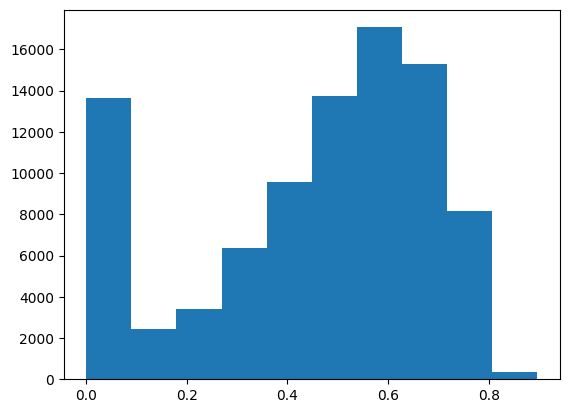

In [33]:
plt.hist(test_pred_total_mean)

In [34]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('CODE_recentgit_lgbmcat_cpu_mac_sunghyun+StandardScaler.csv', index=False)